In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import seaborn as sns
import os, re, math
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import jensenshannon
#%matplotlib inline

sns.set(color_codes=True)

def mkdirs(dir_paths):
    for dir_path in dir_paths:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

DATA_SET_DIR = '/Users/emmanueldollinger/PycharmProjects/prediction_by_k/DATA/FEATURE_ANALYSIS/'
GENOMIC_FEATURES_DIR = '/Users/emmanueldollinger/PycharmProjects/prediction_by_k/DATA/Genomic_Features/'

ORIGIN_DATA_DIR = os.path.join(DATA_SET_DIR, 'ORIGIN_DATA')
CLASSIFIED_DATA_DIR = os.path.join(DATA_SET_DIR, 'CLASSIFIED_DATA')
ChrmoHMM_DIR = os.path.join(DATA_SET_DIR, 'ChrmoHMM_INTERSECTED')
HISTONE_DIR = os.path.join(DATA_SET_DIR, 'HISTONE_INTERSECTED')
K_METHY_DIR = os.path.join(DATA_SET_DIR, "K_Methylation_Analysis")

Tile_window_szs = [2]  #  100, 500, 1000
TILE_LABLES = ['Site K'] # 'Tile 100bp', 'Tile 500bp', 'Tile 1000bp'
CG_CONTENT_LABELS = ["LCG < 30%", "ICG 30%-60%", "HCG > 60%"]
HISTONE_TYPES = ["H3K4me1", "H3K4me3", "H3K9Me3", "H3K27ac", "H3K27Me3", "H3K36me3"]
ChrmoHMM_LABELS="Active Promoter","Weak Promoter","Poised Promoter","Strong Enhancer","Strong Enhancer","Weak Enhancer","Weak Enhancer","Insulator","Txn Transition","Txn Elongation","Weak Txn","Repressed","Heterochrom/lo","Repetitive/CNV","Repetitive/CNV"

REPLIS = [55]#1, 41
EACH_SUB_FIG_SIZE = 5
NUMBER_OF_CHRMM_CLASS = 15
CHROMOSOMES = [i for i in range(1, 23)]

mkdirs([ORIGIN_DATA_DIR, CLASSIFIED_DATA_DIR])

In [3]:
def plot_hist_of_distances_between_ks():
    MAX_DIST = 2000
    repli = 55
    data_fp = os.path.join(ORIGIN_DATA_DIR, 'Rep' + str(repli), 'tile_2.csv')
    df = pd.read_csv(data_fp, sep=',', header=None).values
    ks = df[:, 2]
    ks[ks <= 0] = 0.001
    df[:, 2] = np.log10(ks)
    dists = np.array([])
    K_pairs = np.array([])
    for chr_i in CHROMOSOMES:
        chr_indexs = df[:, 0].astype(int) == chr_i
        df_chr = df[chr_indexs, 1]
        ds = df_chr[1:] - df_chr[0:-1]
        dists = np.concatenate((dists, ds), axis=0) if dists.size != 0 else ds

        k_arr = df[chr_indexs, 2].reshape(-1,1)
        kps = np.concatenate((k_arr[0:-1], k_arr[1:]), axis=1)
        K_pairs = np.concatenate((K_pairs, kps), axis=0) if K_pairs.size != 0 else kps

    dists = dists[dists < MAX_DIST]
    corr_coef = np.corrcoef(K_pairs[:, 0], K_pairs[:, 1])[0][1]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    ax = axs[0]
    ax.hist(dists, 20, density=True, facecolor='b', alpha=0.75)
    ax.set_xlabel('Distance(bp)')
    ax.set_ylabel('Probability')
    ax.set_xlim(0, MAX_DIST)
    ax.set_title("Histogram of the distance between K")

    ax2 = axs[1]
    ax2.hist2d(K_pairs[:, 0], K_pairs[:, 1], bins=(30, 30))
    ax2.set_xlabel('log10(K)')
    ax2.set_ylabel('log10(K) neighbor')
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_title("Hist2d of log10(K) and Neighbor log10(K) with Corr " + str(round(float(corr_coef), 2)))

    plt.savefig("../FIGURES/FEATURE_ANALYSIS/Hist_of_Distance.png", dpi=200)

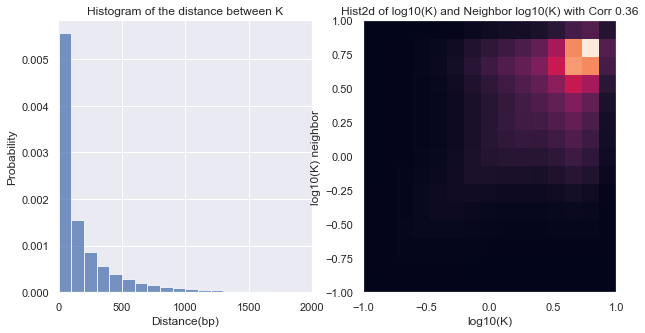

In [4]:
plot_hist_of_distances_between_ks()

In [5]:
def hist_for_logk_distribution(percentile):
    fig, axs = plt.subplots(1, 1, figsize=(4, 3))
    repli = 55
    for tid, tile_window_sz in enumerate(Tile_window_szs):
        data_fp = os.path.join(ORIGIN_DATA_DIR, 'Rep' + str(repli), 'tile_' + str(tile_window_sz) + '.csv')
        df = pd.read_csv(data_fp, sep=',', header=None).values
        ks = df[:, 2]
        ks[ks <= 0] = 0.001
        ks = np.log10(ks)
        ax = axs
        ax.hist(ks, 40, density=True, facecolor='b', alpha=0.75)
        ax.axvline(x=np.percentile(ks, percentile), color='r')
        ax.text(np.percentile(ks, percentile), 1, str(percentile) + " percentile", color="r")
        ax.set_ylabel('Probability')
        ax.set_xlim(-0.75, 1)
        ax.set_title("log10(k) in " + TILE_LABLES[tid])
        if tid!=len(Tile_window_szs) - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel('log10(k)')
    plt.savefig("../FIGURES/FEATURE_ANALYSIS/VIOLIN_PLOT.png", dpi=200)

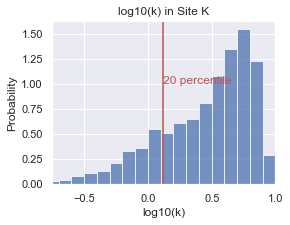

In [21]:
hist_for_logk_distribution(20)

In [6]:
def plot_for_logk_and_methy():
    data_fp = os.path.join(K_METHY_DIR, "K_and_methy_intersected.csv")

    plt.figure(figsize=(4, 3), dpi=120)
    df = pd.read_csv(data_fp, sep=',', header=None).values
    ks = df[:, 2]
    methys = df[:, 3]
    ks[ks <= 0] = 0.001
    ks = np.log10(ks)
    corr_coef = np.corrcoef(ks,methys)[0][1]
    h = plt.hist2d(methys, ks, bins=(30, 30), normed=True, vmin=0, vmax=5)#, cmap='RdBu'
    plt.colorbar()
    plt.xlabel('Methylation level')
    plt.ylabel('log10(K)')
    plt.ylim(-1, 1)
    plt.xlim(0, 1)
    plt.title("Hist2d of Methy vs log10(K) with Correlation " + str(round(float(corr_coef), 2)))
    plt.savefig("../FIGURES/FEATURE_ANALYSIS/METHY_VS_K.png", dpi=200)

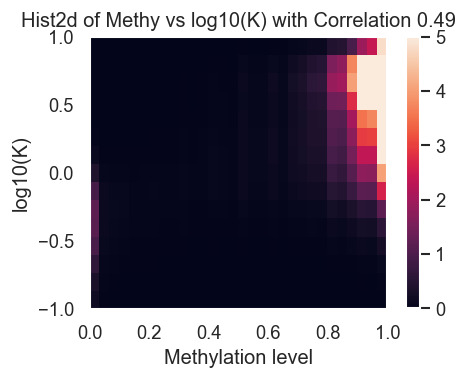

In [18]:
plot_for_logk_and_methy()

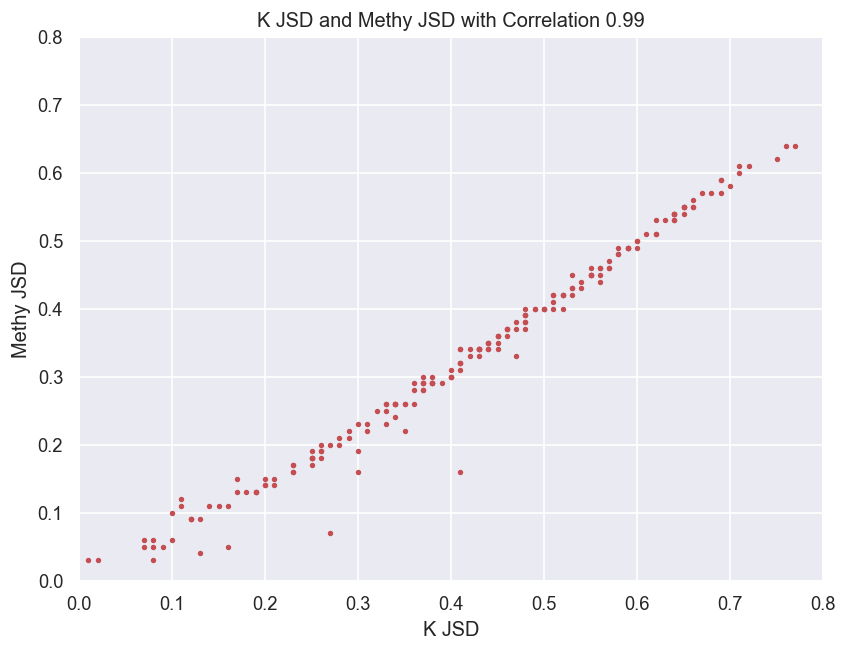

In [27]:
data_fp = os.path.join("/Users/emmanueldollinger/PycharmProjects/prediction_by_k/FIGURES/FEATURE_ANALYSIS/JSD_COMPARISON/JSD_Stat.tsv")
df = pd.read_csv(data_fp, sep='\t', header=None).values

plt.figure(figsize=(8, 6), dpi=120)
k_jsd = df[:, 0]
methy_jsd = df[:, 1]
corr_coef = np.corrcoef(k_jsd,methy_jsd)[0][1]

plt.scatter(k_jsd, methy_jsd, color='r', s=5)#, cmap='RdBu'
plt.xlabel('K JSD')
plt.ylabel('Methy JSD')
plt.ylim(0, 0.8)
plt.xlim(0, 0.8)
plt.title("K JSD and Methy  JSD  with Correlation " + str(round(float(corr_coef), 2)))
plt.savefig("../FIGURES/FEATURE_ANALYSIS/METHY_VS_K_JSD.png", dpi=200)

In [119]:
def plot_gc_content_percentage_in_each_K_class(wrting_data=False):
    CG_CONTENT_LABELS = ["LCG < 30%", "ICG 30%-60%", "HCG > 60%"]
    MCLASS_LABELS = ['empty', 'slowest k', 'slow k', 'middle k', 'fast k', 'fastest k']
    REPLIS = [55]#1, 41
    wrting_data=False
    cm = plt.get_cmap('gist_rainbow')

    indir = os.path.join(DATA_SET_DIR, "CG_Analysis")
    outdir = os.path.join(indir, "Classified_data")
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    radius = [25, 50, 75]
    k_col_index = 3
    cg_col_index = 5
    lcg = 0.35 #threshold between low_cg_percent and intermediate
    hcg = 0.6 # threshold between intermediate and high
    fig_dir = os.path.join(FIGURE_DIR, "CG_CONTENT")
    if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
    r = 25
    input_fp = os.path.join(indir, "55_flank_" + str(r) +"_GC.csv")
    output_filename = os.path.join(outdir, "55_flank_" + str(r) +"_GC")

    percs = []
    df = pd.read_csv(input_fp, sep=',', header=None).values

    ks = df[:, k_col_index]
    ks[ks <= 0] = 0.001
    ks = np.log10(ks)
    df[:, k_col_index] = ks

    percentiles = [-2.0]
    percentile_names = []
    for i in range(1, N_CLASSES + 1):
        percentile = i * 20
        percentile_names.append(str(percentile))
        percentiles.append(float(np.percentile(ks, percentile)))
    percs.append(percentiles[1:])

    class_datas = []
    for p_idx in range(0, N_CLASSES):
        df_indexs = np.logical_and(ks > percentiles[p_idx], ks < percentiles[p_idx + 1])
        origin_data = df[df_indexs, :]
        cg_category = np.ones((origin_data.shape[0], 1)).reshape(-1,1) * 2.0
        lcg_indexs = origin_data[:, cg_col_index] < lcg
        hcg_indexs = origin_data[:, cg_col_index] > hcg
        cg_category[lcg_indexs] = 1
        cg_category[hcg_indexs] = 3
        class_datas.append(np.concatenate((origin_data, cg_category), axis=1))
    # wring data
    if wrting_data:
        for c_i, class_data in enumerate(class_datas):
            out_fp = os.path.join(output_filename + "_" + CLASS_LABELS[c_i] + '.csv')
            np.savetxt(out_fp, class_data[:, :],fmt = "%d,%d,%d,%.4f,%.4f,%.4f,%d", delimiter = '\n')
            print("finish %s" % out_fp)
    fig = plt.figure(figsize=(10, 6), dpi=120)

    ind = np.arange(len(CLASS_LABELS))
    CGS = np.arange(len(CG_CONTENT_LABELS))

    class_data = np.zeros((len(CGS), len(ind)))
    class_data_non_normed = np.zeros((len(CGS), len(ind)))
    for cid, class_label in enumerate(CLASS_LABELS):
        origin_data = class_datas[cid]
        cg_classes = origin_data[:, -1].astype(int)

        unique, counts = np.unique(cg_classes, return_counts=True)
        unique = unique.astype(int)
        normed_counts = counts / float(counts.sum())
        unique_dc = dict(zip(unique, normed_counts))
        unique_dc_non_normed = dict(zip(unique, counts))
        for cls in CGS:
            class_data[cls][cid] = unique_dc[cls + 1]
            class_data_non_normed[cls][cid] = unique_dc_non_normed[cls + 1]
    pls = []
    for cls in CGS:
        if cls == 0:
            pl = plt.bar(ind, tuple(list(class_data[cls, :])), 0.35)
        else:
            sum_prev = list(np.sum(class_data[0: cls, :], axis=0))
            pl = plt.bar(ind, tuple(list(class_data[cls, :])), 0.35, bottom=tuple(sum_prev))
        for item in pl:
            item.set_color(cm(1. * cls / len(CG_CONTENT_LABELS)))
        pls.append(pl)
    plt.xlabel('K Class')
    plt.ylabel('Percentage')
    plt.xticks(ind, CLASS_LABELS)
    plt.yticks(np.arange(0.2, 1.1, 0.2))
    plt.legend(tuple(pls), tuple(CG_CONTENT_LABELS))
    plt.title("Percentage of CG Content in Each K class with local radius" + str(r))
    plt.savefig(os.path.join(fig_dir, "CG_CONTENT_PERCENTAGE_OF_K_R_" + str(r) + ".png"), dpi=200)

    N_COL = len(CGS)
    fig, axs = plt.subplots(1, N_COL,figsize=(N_COL * EACH_SUB_FIG_SIZE, 1 * EACH_SUB_FIG_SIZE))
    for cls in CGS:
        ax = axs[cls]
        y_max = np.max(class_data[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / N_COL))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data[cls, cid] + 0.002, str(round(class_data[cls, cid] * 100.0, 2)) + "%", fontsize= 14, weight="bold")
        if cls == 0:
            ax.set_ylabel("Percentage" +", CG local radius " + str(r),  fontsize=22)
        ax.set_xticklabels(MCLASS_LABELS, fontsize=18)
        ax.set_ylim(0, y_max)
        ax.set_title(CG_CONTENT_LABELS[cls], fontsize=22)
    plt.savefig(os.path.join(fig_dir, "CG_CONTENT_PERCENTAGE_OF_K_SEP_R_" + str(r) + ".png"), dpi=200)
    
    fig, axs = plt.subplots(1, N_COL,figsize=(N_COL * EACH_SUB_FIG_SIZE, 1 * EACH_SUB_FIG_SIZE))
    for cls in CGS:
        ax = axs[cls]
        class_data_non_normed[cls, :] = class_data_non_normed[cls, :] / np.sum(class_data_non_normed[cls, :])
        y_max = np.max(class_data_non_normed[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data_non_normed[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / N_COL))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data_non_normed[cls, cid] + 0.002, str(round(class_data_non_normed[cls, cid] * 100.0, 2)) + "%", fontsize= 14, weight="bold")
        if cls == 0:
            ax.set_ylabel("Percentage" +", CG local radius " + str(r),  fontsize=22)
        ax.set_xticklabels(MCLASS_LABELS, fontsize=18)
        ax.set_ylim(0, y_max)
        ax.set_title(CG_CONTENT_LABELS[cls], fontsize=22)
    plt.savefig(os.path.join(fig_dir, "CG_CONTENT_PERCENTAGE_OF_CG_SEP_R_" + str(r) + ".png"), dpi=200)

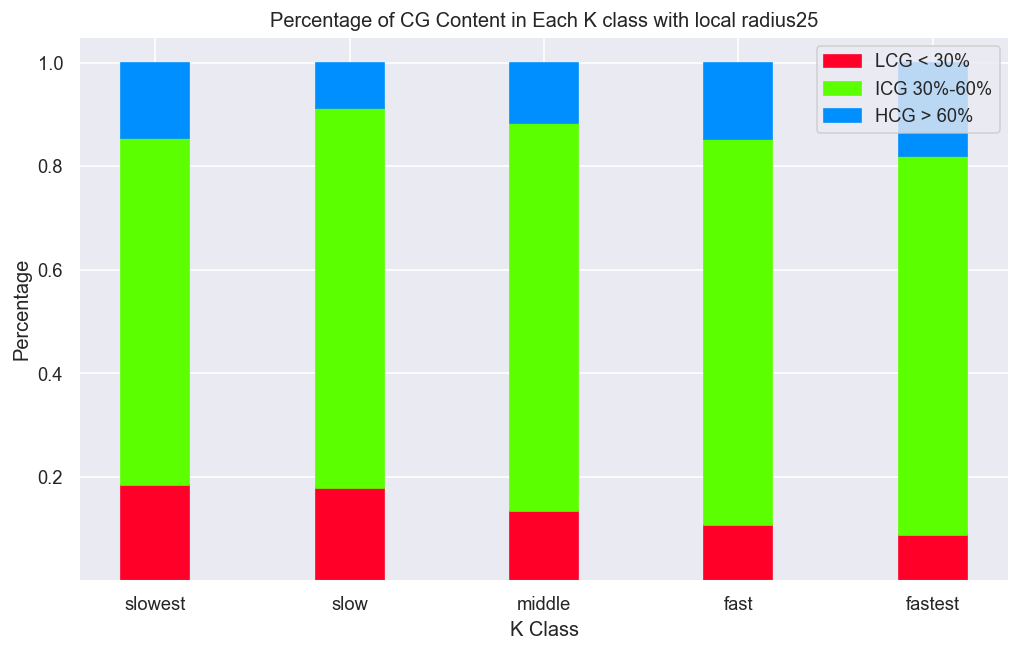

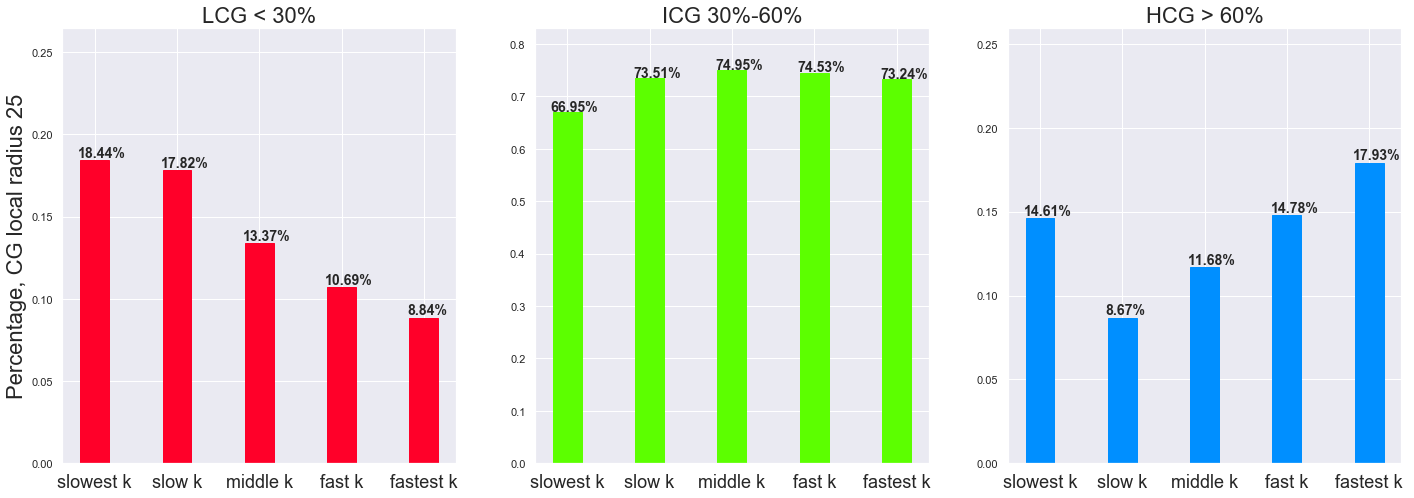

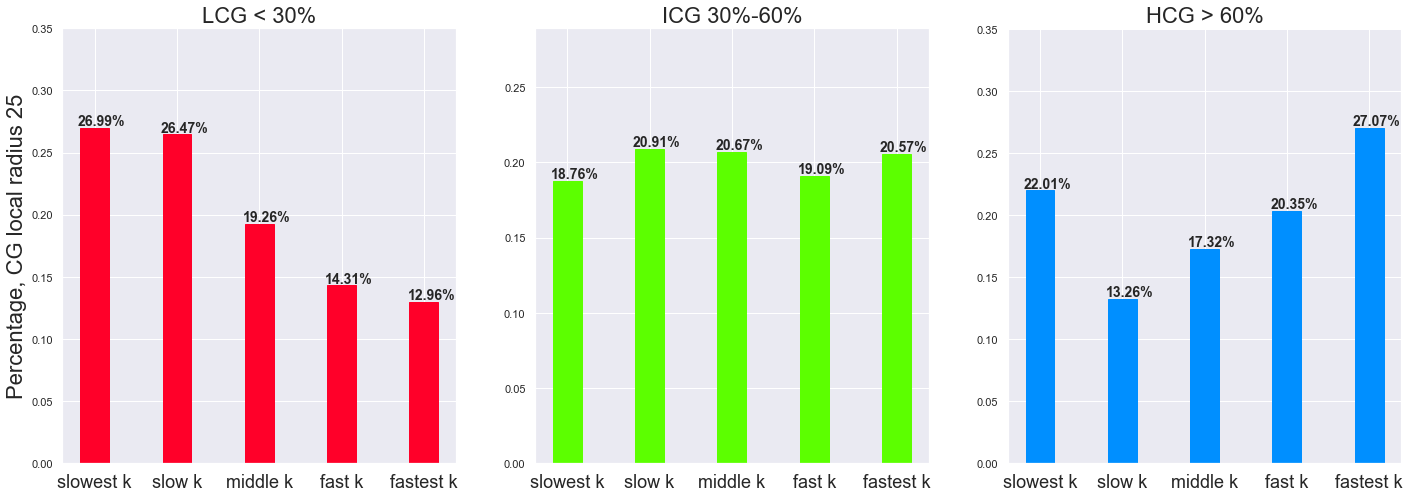

In [120]:
plot_gc_content_percentage_in_each_K_class()

In [12]:
def plot_K_in_methy_context():
    indir = os.path.join(DATA_SET_DIR, "K_Methylation_Analysis")
    METHY_LABELS = ["Unmethy: < 0.3", "IM: 0.3-0.7", "Methylated: > 0.7"]
    cm = plt.get_cmap('gist_rainbow')

    k_col_index = 2
    methy_col_index = 3

    unmethy_threshold = 0.3  # threshold between unmethylated and intermediate methylated
    methy_threshold = 0.7  # threshold between intermediate methylated and methylated

    fig_dir = os.path.join(FIGURE_DIR, "K_METHYLATION")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    input_fp = os.path.join(indir, "K_and_methy_intersected.csv")

    # Classify K by percentile and label K by methylation level
    percs = []
    df = pd.read_csv(input_fp, sep=',', header=None).values

    ks = df[:, k_col_index]

    ks[ks <= 0] = 0.001
    ks = np.log10(ks)
    df[:, k_col_index] = ks

    percentiles = [-2.0]
    percentile_names = []
    for i in range(1, N_CLASSES + 1):
        percentile = i * 20
        percentile_names.append(str(percentile))
        percentiles.append(float(np.percentile(ks, percentile)))
    percs.append(percentiles[1:])

    class_datas = []
    for p_idx in range(0, N_CLASSES):
        df_indexs = np.logical_and(ks > percentiles[p_idx], ks < percentiles[p_idx + 1])
        origin_data = df[df_indexs, :]

        methy_category = np.ones((origin_data.shape[0], 1)).reshape(-1, 1) * 2.0

        unmethy_indexs = origin_data[:, methy_col_index] < unmethy_threshold
        methy_category[unmethy_indexs] = 1

        methy_indexs = origin_data[:, methy_col_index] > methy_threshold
        methy_category[methy_indexs] = 3

        class_datas.append(np.concatenate((origin_data, methy_category), axis=1))

    fig = plt.figure(figsize=(10, 6), dpi=120)
    ind = np.arange(len(CLASS_LABELS))
    CGS = np.arange(len(METHY_LABELS))

    class_data = np.zeros((len(CGS), len(ind)))
    class_data_non_normed = np.zeros((len(CGS), len(ind)))
    for cid, class_label in enumerate(CLASS_LABELS):
        origin_data = class_datas[cid]
        cg_classes = origin_data[:, -1].astype(int)

        unique, counts = np.unique(cg_classes, return_counts=True)
        unique = unique.astype(int)
        normed_counts = counts / float(counts.sum())
        unique_dc = dict(zip(unique, normed_counts))
        unique_dc_non_normed = dict(zip(unique, counts))
        for cls in CGS:
            class_data[cls][cid] = unique_dc[cls + 1]
            class_data_non_normed[cls][cid] = unique_dc_non_normed[cls + 1]
    pls = []
    for cls in CGS:
        if cls == 0:
            pl = plt.bar(ind, tuple(list(class_data[cls, :])), 0.35)
        else:
            sum_prev = list(np.sum(class_data[0: cls, :], axis=0))
            pl = plt.bar(ind, tuple(list(class_data[cls, :])), 0.35, bottom=tuple(sum_prev))
        for item in pl:
            item.set_color(cm(1. * cls / len(METHY_LABELS)))
        pls.append(pl)
    plt.xlabel('K Class')
    plt.ylabel('Percentage')
    plt.xticks(ind, CLASS_LABELS)
    plt.yticks(np.arange(0.2, 1.1, 0.2))
    plt.legend(tuple(pls), tuple(METHY_LABELS))
    plt.title("Percentage of Methylation in Each K class")
    plt.savefig(os.path.join(fig_dir, "METHY_PERCENTAGE_OF_K.png"), dpi=200)

    N_COL = len(CGS)
    fig, axs = plt.subplots(1, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, 1 * EACH_SUB_FIG_SIZE))
    for cls in CGS:
        ax = axs[cls]
        y_max = np.max(class_data[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / N_COL))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data[cls, cid] + 0.002, str(round(class_data[cls, cid] * 100.0, 2)) + "%",
                    fontsize=14, weight="bold")
        if cls == 0:
            ax.set_ylabel("Percentage", fontsize=22)
        ax.set_xticks(ind)
        ax.set_xticklabels(CLASS_LABELS, fontsize=14)
        ax.set_ylim(0, y_max)
        ax.set_title(METHY_LABELS[cls], fontsize=22)
    plt.savefig(os.path.join(fig_dir, "METHY_PERCENTAGE_OF_K_SEP.png"), dpi=200)

    fig, axs = plt.subplots(1, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, 1 * EACH_SUB_FIG_SIZE))
    for cls in CGS:
        ax = axs[cls]
        class_data_non_normed[cls, :] = class_data_non_normed[cls, :] / np.sum(class_data_non_normed[cls, :])
        y_max = np.max(class_data_non_normed[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data_non_normed[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / N_COL))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data_non_normed[cls, cid] + 0.002,
                    str(round(class_data_non_normed[cls, cid] * 100.0, 2)) + "%",
                    fontsize=14, weight="bold")
        if cls == 0:
            ax.set_ylabel("Percentage", fontsize=22)
        ax.set_xticks(ind)
        ax.set_xticklabels(CLASS_LABELS, fontsize=14)
        ax.set_ylim(0, y_max)
        ax.set_title(METHY_LABELS[cls], fontsize=22)
    plt.savefig(os.path.join(fig_dir, "METHY_PERCENTAGE_OF_METHY_SEP.png"), dpi=200)

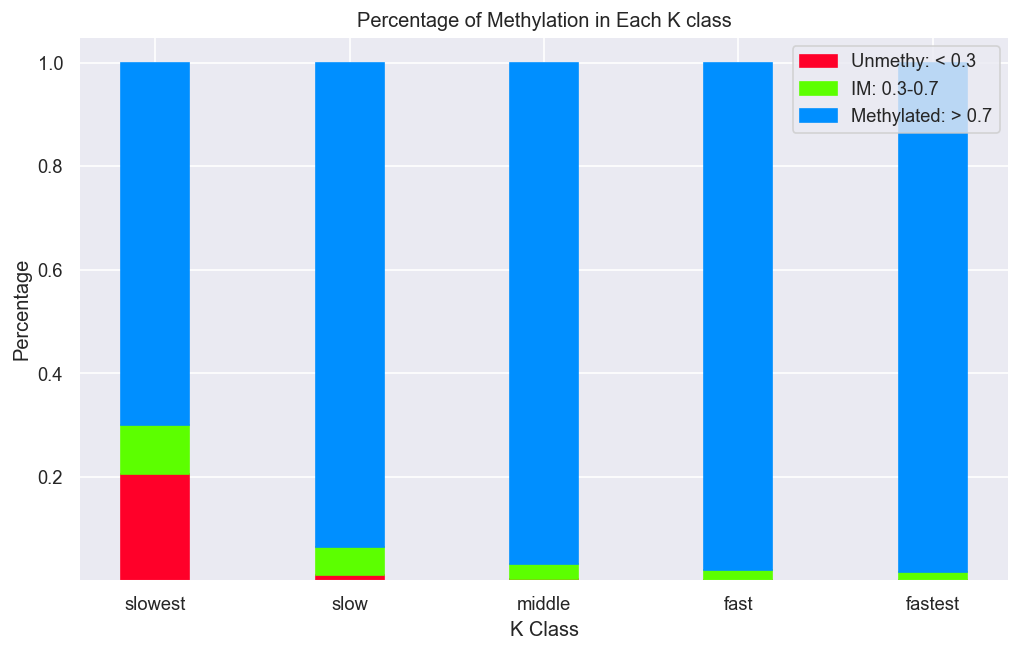

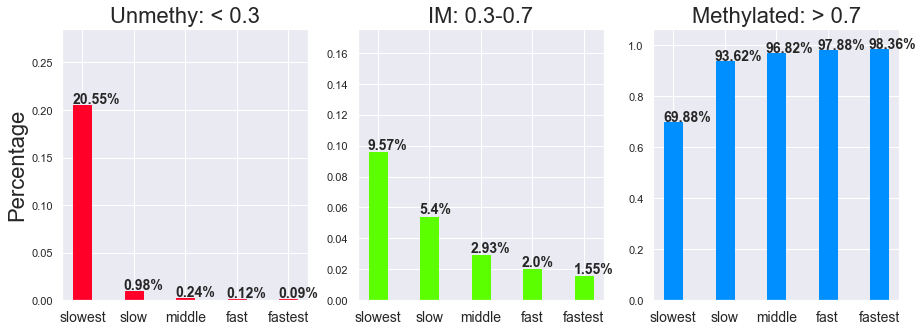

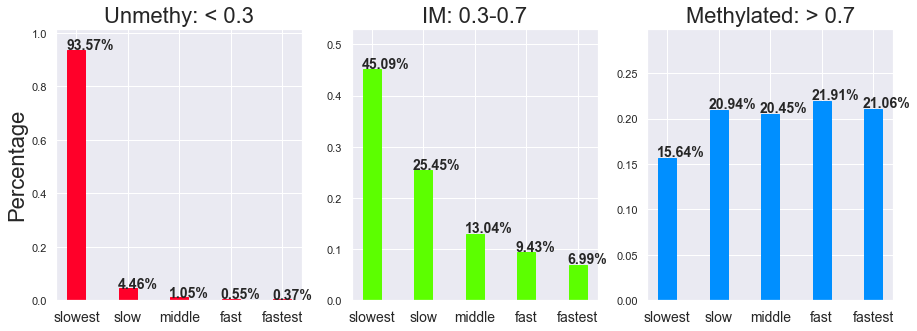

In [13]:
plot_K_in_methy_context()

In [7]:
def plot_K_in_promoter_or_CGI_context():
    PRO_CGI_LABELS = ["Promoter CGI", "Promoter Non-CGI", "Non-Promter CGI", "Non-Promter Non-CGI"]
    MCLASS_LABELS = ['empty', 'slowest k', 'slow k', 'middle k', 'fast k', 'fastest k']
    cm = plt.get_cmap('gist_rainbow')

    indir = os.path.join(DATA_SET_DIR, "CG_Analysis")

    k_col_index = 3
    promoter_col_index = 6
    cgi_col_index = 7
    ChrHMM_col_index = 8

    fig_dir = os.path.join(FIGURE_DIR, "CG_CONTENT")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    r = 25
    input_fp = os.path.join(indir, "55_flank_" + str(r) + "_Promoter_CGI_ChrHMM_annotated.csv")

    percs = []
    df = pd.read_csv(input_fp, sep=',', header=None).values

    ks = df[:, k_col_index]
    ks[ks <= 0] = 0.001
    ks = np.log10(ks)
    df[:, k_col_index] = ks

    percentiles = [-2.0]
    percentile_names = []
    for i in range(1, N_CLASSES + 1):
        percentile = i * 20
        percentile_names.append(str(percentile))
        percentiles.append(float(np.percentile(ks, percentile)))
    percs.append(percentiles[1:])

    non_promoter_cgi_k_slowest = None
    non_promoter_cgi_k_fastest = None

    class_datas = []
    for p_idx in range(0, N_CLASSES):
        df_indexs = np.logical_and(ks > percentiles[p_idx], ks < percentiles[p_idx + 1])
        origin_data = df[df_indexs, :]

        pro_cgi_category = np.ones((origin_data.shape[0], 1)).reshape(-1, 1)

        prom_cgi = np.logical_and(origin_data[:, promoter_col_index].astype(int) == 1,
                                  origin_data[:, cgi_col_index].astype(int) == 1)
        prom_non_cgi = np.logical_and(origin_data[:, promoter_col_index].astype(int) == 1,
                                      origin_data[:, cgi_col_index].astype(int) == 0)
        non_prom_cgi = np.logical_and(origin_data[:, promoter_col_index].astype(int) == 0,
                                      origin_data[:, cgi_col_index].astype(int) == 1)
        non_prom_non_cgi = np.logical_and(origin_data[:, promoter_col_index].astype(int) == 0,
                                          origin_data[:, cgi_col_index].astype(int) == 0)

        pro_cgi_category[prom_cgi] = 1
        pro_cgi_category[prom_non_cgi] = 2
        pro_cgi_category[non_prom_cgi] = 3
        pro_cgi_category[non_prom_non_cgi] = 4

        if p_idx == 0:  # slowest K
            non_promoter_cgi_k_slowest = origin_data[non_prom_cgi]
        elif p_idx == 4:  # fastest K
            non_promoter_cgi_k_fastest = origin_data[non_prom_cgi]

        class_datas.append(np.concatenate((origin_data, pro_cgi_category), axis=1))

    print(non_promoter_cgi_k_slowest.shape)

    ind = np.arange(len(CLASS_LABELS))
    CGS = np.arange(len(PRO_CGI_LABELS))

    class_data_non_normed = np.zeros((len(CGS), len(ind)))
    for cid, class_label in enumerate(CLASS_LABELS):
        origin_data = class_datas[cid]
        pro_cgi_classes = origin_data[:, -1].astype(int)

        unique, counts = np.unique(pro_cgi_classes, return_counts=True)
        unique = unique.astype(int)
        unique_dc_non_normed = dict(zip(unique, counts))
        for cls in CGS:
            class_data_non_normed[cls][cid] = unique_dc_non_normed[cls + 1]
    N_COL = 2
    N_ROW = 2
    fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))

    for cls in CGS:
        row = cls // N_COL
        col = cls % N_COL
        ax = axs[row][col]
        class_arr = class_data_non_normed[cls, :] / np.sum(class_data_non_normed[cls, :])
        y_max = np.max(class_arr) + 0.08
        pl = ax.bar(ind, tuple(list(class_arr)), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / len(PRO_CGI_LABELS)))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_arr[cid] + 0.002,
                    str(round(class_arr[cid] * 100.0, 2)) + "%", fontsize=14, weight="bold")
        if col == 0:
            ax.set_ylabel("Percentage", fontsize=22)
        ax.set_xticklabels(MCLASS_LABELS, fontsize=18)
        ax.set_ylim(0, y_max)
        ax.set_title(PRO_CGI_LABELS[cls], fontsize=22)
    plt.savefig(os.path.join(fig_dir, "CGI_Promoter_R_" + str(r) + ".png"), dpi=200)

(14712, 9)


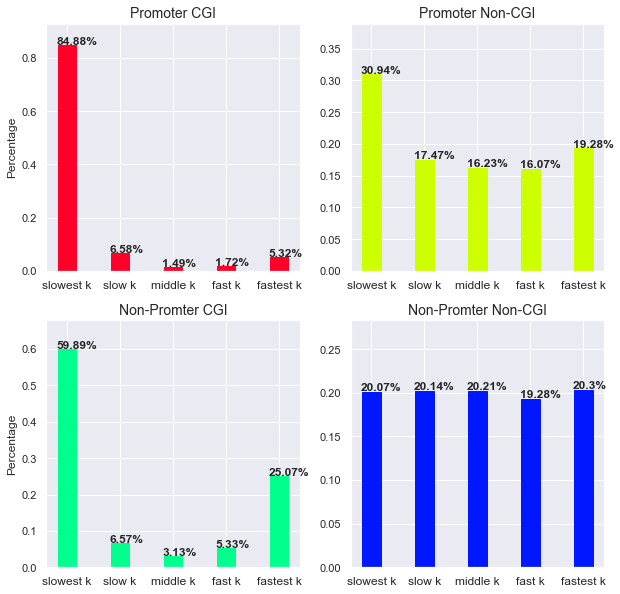

In [8]:
plot_K_in_promoter_or_CGI_context()

In [10]:
def get_percentile_index_arr(repli):
    col_index = 2
    if K_analyze:
        K_fp = os.path.join(ORIGIN_DATA_DIR, "Rep" + str(repli), "tile_2.csv")
        df = pd.read_csv(K_fp, sep=',', header=None).values
        ks = df[:, col_index]
        if LOG_SCALE:
            ks[ks <= 0] = 0.001
            ks = np.log10(ks)
            df[:, col_index] = ks
            percentiles = [-2.0]
        else:
            percentiles = [0.0]
        percentiles_to_query = np.array([i * 20 for i in range(1, N_CLASSES + 1)])
        percentiles_results = list(np.percentile(ks, percentiles_to_query))
        for item in percentiles_results:
            percentiles.append(float(item))
    else:
        K_fp = os.path.join(DATA_SET_DIR, "GSM1112841.csv")
        df = pd.read_csv(K_fp, sep='\t', header=None).values
        ks = df[:, col_index]
        ks[ks < 0] = 0
        ks[ks > 1] = 1
        percentiles = [0.0] #, 0.2, 0.8, 0.9, 1.0
        percentiles_to_query = np.array([25, 50, 65, 100])
        #print(percentiles_to_query)
        percentiles_results = list(np.percentile(ks, percentiles_to_query))
        for item in percentiles_results:
            percentiles.append(float(item))
    #print(percentiles)
    df_indexs_arr = []
    for p_idx in range(0, N_CLASSES):
        df_indexs = np.logical_and(ks > percentiles[p_idx], ks < percentiles[p_idx + 1])
        df_indexs_arr.append(df_indexs)
    return df_indexs_arr, df, percentiles

In [11]:
def hist_K_with_5_percentiles():
    fig_dir = os.path.join(FIGURE_DIR, "Others")
    mkdirs([fig_dir])
    repli = 55
    k_col_index = 2
    df_indexs_arr, df, percentiles = get_percentile_index_arr(repli)
    fig, ax = plt.subplots(1, 1,figsize=(8, 6))
    ax.hist(df[:, k_col_index], 50, density=True, facecolor='b', alpha=0.75)
    for percentile in percentiles:
        ax.axvline(x=percentile, color='r')
    if K_analyze:
        if LOG_SCALE:
            xlabel = 'log10(k)'
            xlim = [-1, 1]
        else:
            xlabel = 'k'
            xlim = [0, 10]
    else:
        xlabel = 'methylation'
        xlim = [0, 1]
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Probability')
    ax.set_title("Histogram of REP " + str(repli))
    ax.set_xlim(xlim)
    plt.savefig(os.path.join(fig_dir, "Hist_" + str(repli) + ".png"), dpi=200)

Methy_JSD


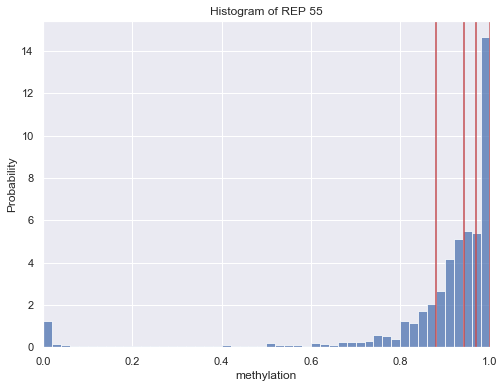

In [34]:
LOG_SCALE = False
JSD = True # Using JSD or Mutual information
HISTOGRAM = False # plot histogram or the distribution by pdf
K_analyze = False
NBIN=50 if LOG_SCALE else 30
METRIC ="JSD" if JSD else "1-MI"
if K_analyze:
    if LOG_SCALE:
        sub_fig_dir= "K_Log10"
    else:
        sub_fig_dir= "K"
else:
    sub_fig_dir= "Methy"
print(sub_fig_dir + "_" + METRIC)
FIGURE_DIR = os.path.join("../FIGURES/FEATURE_ANALYSIS/", sub_fig_dir)
if not os.path.exists(FIGURE_DIR):
    os.makedirs(FIGURE_DIR)
intersected_dir_name = "K_intersected" if K_analyze else "Methy_intersected"
CLASS_LABELS = ['slowest', 'slow', 'middle', 'fast', 'fastest'] if K_analyze else ['<25%', '25%-50%', '50%-65%', '>65%']
N_CLASSES = len(CLASS_LABELS)
percentile_names = [str(i*20) for i in range(1, N_CLASSES + 1)]
hist_K_with_5_percentiles()

In [12]:
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [13]:
def plot_K_hist_in_different_markers(BASE_DIR, SUB_DIR_NAME):
    repli = 55
    dist_dict = {}
    entropy_dict = {}
    df_indexs_arr, df,_ = get_percentile_index_arr(repli)
    ind = np.arange(len(CLASS_LABELS))
    cm = plt.get_cmap('gist_rainbow')
    input_fps = []
    file_names = []
    for file_name in os.listdir(BASE_DIR):
        if file_name.endswith(".csv"):
            input_fps.append(os.path.join(BASE_DIR, file_name))
            file_names.append(file_name.strip(".csv"))
    N_FILES = len(input_fps)
    N_COL = 5
    Max_NROW = 3
    N_SUBFIG_PER_FIG = Max_NROW * N_COL
    NFIG = int(math.ceil(N_FILES / N_SUBFIG_PER_FIG))
    fig_dir = os.path.join(FIGURE_DIR, SUB_DIR_NAME)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    for i in range(NFIG):
        if NFIG > 1:
            fig_fp = os.path.join(fig_dir, SUB_DIR_NAME + "_" + str(i) + ".png")
        else:
            fig_fp = os.path.join(fig_dir, SUB_DIR_NAME + ".png")
        base_index = i * N_SUBFIG_PER_FIG
        N_remaining_files = N_FILES - base_index
        N_ROW = int(math.ceil((N_remaining_files) / N_COL)) if N_remaining_files <= N_SUBFIG_PER_FIG else Max_NROW
        
        fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
        SUB_FIG_RANGE = N_SUBFIG_PER_FIG if N_remaining_files > N_SUBFIG_PER_FIG else N_remaining_files

        for j in range(SUB_FIG_RANGE):
            row = j // N_COL
            col = j % N_COL
            if N_ROW == 1:
                ax = axs[col]
            else:
                ax = axs[row][col]
            index = base_index + j
            class_fp = input_fps[index]
            categories = pd.read_csv(class_fp, sep="\t", header=None).values
            class_data = []
            cat_indexs = categories[:, -1] == 1
            for cid, class_label in enumerate(CLASS_LABELS):
                df_indexs = df_indexs_arr[cid]
                intersect = np.logical_and(df_indexs, cat_indexs)
                # int_data = df[intersect]
                cls_count = np.sum(categories[intersect, -1])
                class_data.append(cls_count)
            class_data=np.array(class_data)
            class_data = class_data[:] / np.sum(class_data)
            y_max = np.max(class_data) + 0.08
            pl = ax.bar(ind, tuple(list(class_data)), 0.35)
            for item in pl:
                item.set_color(cm(1. * j / SUB_FIG_RANGE))
            for cid, class_label in enumerate(CLASS_LABELS):
                ax.text(ind[cid] - 0.2, class_data[cid] + 0.002,
                        str(round(class_data[cid] * 100.0, 2)) + "%", fontsize=10, weight="bold")
            if col == 0:
                ax.set_ylabel("Percentage", fontsize=18)
            ax.set_xticks(ind)
            ax.set_xticklabels(CLASS_LABELS, fontsize=12)
            ax.set_xlim(-0.5, len(CLASS_LABELS)-0.5)
            ax.set_ylim(0, y_max)
            ax.set_title(file_names[index], fontsize=18)
        plt.savefig(fig_fp, dpi=200)
        if NFIG > 1:
            fig_fp = os.path.join(fig_dir, SUB_DIR_NAME + "_DIST_" + str(i) + "_"+ METRIC +".png")
        else:
            fig_fp = os.path.join(fig_dir, SUB_DIR_NAME + "_DIST_"+ METRIC +".png")
        # Plot the pdf
        if K_analyze:
            if LOG_SCALE:
                xlim = [-1, 1]
            else:
                xlim = [0, 10]
        else:
            xlim = [0, 1]
        fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
        for j in range(SUB_FIG_RANGE):
            row = j // N_COL
            col = j % N_COL
            if N_ROW == 1:
                ax = axs[col]
            else:
                ax = axs[row][col]
            index = base_index + j
            class_fp = input_fps[index]
            categories = pd.read_csv(class_fp, sep="\t", header=None).values
            class_data = []
            ks_indexs = categories[:, -1] == 1
            ks = df[ks_indexs, -1]
            xhist, _, _ = ax.hist(df[:, -1], bins=NBIN, density=True, color='black', edgecolor='black', alpha = 0.5, linewidth=0.5)#
            yhist, _, _ = ax.hist(ks, bins=NBIN, density=True, color=cm(1. * j / SUB_FIG_RANGE), edgecolor='black', alpha = 0.5, linewidth=0.5)#
            if JSD:
                distance = jensenshannon(xhist, yhist)
            else:
                max_mi = calc_MI(xhist, xhist, MI_BIN)
                mi = calc_MI(xhist, yhist, MI_BIN) / max_mi
                distance = 1 - mi
            print(file_names[index] + "\t" + str(round(float(distance),2)))
            dist_dict[file_names[index]] = distance
            pK = yhist / yhist.sum()
            entropy = -np.sum(pK * np.log10(pK))
            entropy_dict[file_names[index]] = entropy
            ax.text(float(np.mean(np.array(xlim))), max([float(np.max(xhist)), float(np.max(yhist))]) * 0.75,
               "%s:%.2f" %(METRIC, distance), color='black', fontsize=18)

            ax.text(float(np.mean(np.array(xlim))), max([float(np.max(xhist)), float(np.max(yhist))]) * 0.6,
               "%s:%.2f" %("Entropy", entropy), color='black', fontsize=18)
            ax.set_ylabel('Probability')
            ax.set_xlim(xlim)
            ax.set_title(file_names[index], fontsize=18)
        plt.savefig(fig_fp, dpi=200)
    return [dist_dict, entropy_dict]

In [14]:
def plot_ChrMM():
    dist_dict = {}
    entropy_dict = {}
    repli = 55
    fig_dir = os.path.join(FIGURE_DIR, "ChromHMM")
    mkdirs([fig_dir])
    cm = plt.get_cmap('gist_rainbow')
    ind = np.arange(len(CLASS_LABELS))
    chrHMMs = np.arange(NUMBER_OF_CHRMM_CLASS)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    df_indexs_arr, df, percentiles = get_percentile_index_arr(repli)

    class_data = np.zeros((len(chrHMMs), len(ind)))
    class_data_non_normed = np.zeros((len(chrHMMs), len(ind)))
    class_fp = os.path.join(GENOMIC_FEATURES_DIR, "ChrmoHMM", intersected_dir_name, "HmmH1hescHMM.csv")
    categories = pd.read_csv(class_fp, sep="\t", header=None).values
    for cid, class_label in enumerate(CLASS_LABELS):
        classes = categories[df_indexs_arr[cid], -1]
        unique, counts = np.unique(classes, return_counts=True)
        unique = unique.astype(int)
        normed_counts = counts / float(counts.sum())
        unique_dc = dict(zip(unique, normed_counts))
        unique_dc_non_normed = dict(zip(unique, counts))
        for cls in chrHMMs:
            class_data[cls][cid] = unique_dc[cls + 1]
            class_data_non_normed[cls][cid] = unique_dc_non_normed[cls + 1]
    pls = []
    for cls in chrHMMs:
        if cls == 0:
            pl = ax.bar(ind, tuple(list(class_data[cls, :])), 0.35)
        else:
            sum_prev = list(np.sum(class_data[0: cls, :], axis=0))
            pl = ax.bar(ind, tuple(list(class_data[cls, :])), 0.35, bottom=tuple(sum_prev))
        for item in pl:
            item.set_color(cm(1. * cls / NUMBER_OF_CHRMM_CLASS))
        pls.append(pl)
    ax.set_xlabel('ChromHMM Class')
    ax.set_ylabel('Percentage')
    ax.set_xticks(ind)
    ax.set_xticklabels(CLASS_LABELS)
    ax.set_yticks(np.arange(0.2, 1.1, 0.2))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    ax.legend(tuple(pls), tuple(ChrmoHMM_LABELS), loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(os.path.join(fig_dir, "ChromHMM_Rep" + str(repli) + "_PERCENTAGE_OF_K.png"), dpi=200)

    N_ROW = 3
    N_COL = 5
    fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))

    for cls in chrHMMs:
        row = int(cls / N_COL)
        col = int(cls % N_COL)
        ax = axs[row][col]
        y_max = np.max(class_data[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / NUMBER_OF_CHRMM_CLASS))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data[cls, cid] + 0.002, str(round(class_data[cls, cid] * 100.0, 2)) + "%",
                    fontsize=14, weight="bold")
        if col == 0:
            ax.set_ylabel('Percentage')
        ax.set_xticks(ind)
        ax.set_xticklabels(CLASS_LABELS, fontsize=10)
        ax.set_ylim(0, y_max)
        ax.set_title(ChrmoHMM_LABELS[cls], fontsize=18)
    plt.savefig(os.path.join(fig_dir, "ChromHMM_Rep" + str(repli) + "_SEP_PERCENTAGE_OF_K.png"), dpi=200)

    fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
    for cls in chrHMMs:
        row = int(cls / N_COL)
        col = int(cls % N_COL)
        ax = axs[row][col]
        class_data_non_normed[cls, :] = class_data_non_normed[cls, :] / np.sum(class_data_non_normed[cls, :])
        y_max = np.max(class_data_non_normed[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data_non_normed[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / NUMBER_OF_CHRMM_CLASS))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data_non_normed[cls, cid] + 0.002,
                    str(round(class_data_non_normed[cls, cid] * 100.0, 2)) + "%", fontsize=14, weight="bold")
        if col == 0:
            ax.set_ylabel('Percentage')
        ax.set_xticks(ind)
        ax.set_xticklabels(CLASS_LABELS, fontsize=10)
        y_max = np.max(class_data_non_normed[cls, :]) + 0.08
        ax.set_ylim(0, y_max)
        ax.set_title(ChrmoHMM_LABELS[cls], fontsize=18)
    plt.savefig(os.path.join(fig_dir, "ChromHMM_Rep" + str(repli) + "_SEP_PERCENTAGE_OF_ChroMM.png"), dpi=200)

    # Plot the pdf
    fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
    if K_analyze:
        if LOG_SCALE:
            xlim = [-1, 1]
        else:
            xlim = [0, 10]
    else:
        xlim = [0, 1]
    for cls in chrHMMs:
        row = int(cls / N_COL)
        col = int(cls % N_COL)
        ax = axs[row][col]
        ks_indexs = categories[:, -1] == (cls + 1)
        ks = df[ks_indexs, -1]
        xhist, _, _ = ax.hist(df[:, -1], bins=NBIN, density=True, color='black', edgecolor='black', alpha = 0.5, linewidth=0.5)#
        yhist, _, _ = ax.hist(ks, bins=NBIN, density=True, color=cm(1. * cls / NUMBER_OF_CHRMM_CLASS), edgecolor='black', alpha = 0.5, linewidth=0.5)#
        if JSD:
            distance = jensenshannon(xhist, yhist)
        else:
            max_mi = calc_MI(xhist, xhist, MI_BIN)
            mi = calc_MI(xhist, yhist, MI_BIN) / max_mi
            distance = 1 - mi
        dist_dict[ChrmoHMM_LABELS[cls]] = distance
        print(ChrmoHMM_LABELS[cls] + "\t" + str(round(float(distance), 2)))
        pK = yhist / yhist.sum()
        entropy = -np.sum(pK * np.log10(pK))
        entropy_dict[ChrmoHMM_LABELS[cls]] = entropy
        ax.text(float(np.mean(np.array(xlim))), max([float(np.max(xhist)), float(np.max(yhist))]) * 0.75,
           "%s:%.2f" %(METRIC, distance), color='black', fontsize=18)

        ax.text(float(np.mean(np.array(xlim))), max([float(np.max(xhist)), float(np.max(yhist))]) * 0.6,
           "%s:%.2f" %("Entropy", entropy), color='black', fontsize=18)
        ax.set_ylabel('Probability')
        ax.set_xlim(xlim)
        ax.set_title(ChrmoHMM_LABELS[cls], fontsize=18)
    plt.savefig(os.path.join(fig_dir, "ChromHMM_Rep" + str(repli) + "_DIST_ChroMM_"+ METRIC +".png"), dpi=200)
    return [dist_dict, entropy_dict]

Methy_JSD
Active Promoter	0.71
Weak Promoter	0.53
Poised Promoter	0.56
Strong Enhancer	0.47
Strong Enhancer	0.29
Weak Enhancer	0.3
Weak Enhancer	0.15
Insulator	0.26
Txn Transition	0.09
Txn Elongation	0.16
Weak Txn	0.12
Repressed	0.12
Heterochrom/lo	0.1
Repetitive/CNV	0.27
Repetitive/CNV	0.41
EZH2	0.17
DNase	0.12
H2AZ	0.14
CTCF	0.29
P300	0.08
LINE	0.09
Exon	0.15
3UTR	0.08
CodingExon	0.1
5UTR	0.34
Enhancer	0.25
CGI	0.48
SINE	0.1
Intergeni	0.02
LTR	0.07
Intron	0.01
H3K4me2	0.41
H3K4me3	0.51
H3K4me1	0.18
H3K27Me3	0.26
H3K27a	0.38
H3K79me2	0.13
H3K9Me3	0.08
H3K36me3	0.07
H4K20me1	0.12
JMJD2A	0.33
HDAC6	0.04
SIRT6	0.04
PLU-1	0.03
PHF8	0.17
HDAC2	0.16
CHD7	0.08
RBBP5	0.28
SAP30	0.26
SUZ12	0.04
YY1	0.48
WRNIP1	0.49
MEF2C	0.36
ZBTB33	0.5
ESR1	0.23
SMARCB1	0.56
JUNB	0.34
RAD21	0.38
REST	0.47
BATF	0.2
ELF1	0.5
RXRA	0.36
GATA1	0.34
TFAP2A	0.44
PBX3	0.46
RPC155	0.32
SIX5	0.64
TFAP2C	0.43
GATA3	0.2
ELK4	0.65
PPARGC1A	0.48
JUN	0.25
NR2C2	0.57
GABPA	0.53
CTCFL	0.59
TAL1	0.23
GATA2	0.2
GTF3C2	0.37
MEF2

/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RUNX3	0.37
STAT2	0.46
IRF4	0.37
IKZF1	0.16
POLR3G	0.69
TCF3	0.43
MAX	0.43
RELA	0.45
STAT3	0.25
TAF1	0.56
SP4	0.69
E2F1	0.6
MTA3	0.4
RCOR1	0.43
ESRRA	0.39
IRF1	0.58
PHF8	0.65
KAP1	0.37
SP1	0.43
HDAC1	0.63
E2F4	0.62
TCF12	0.42
NFYB	0.41
BCL11A	0.25
FOXP2	0.52
HNF4A	0.28
E2F6	0.54
TBP	0.51
MBD4	0.41
PAX5	0.43
TAF7	0.67
SP2	0.64
IRF3	0.72
CTBP2	0.68
HDAC2	0.45
PML	0.49
NFYA	0.58
GRp20	0.77


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in log10
/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in multiply


CEBPD	0.52
HMGN3	0.6
MYC	0.4
NANOG	0.66
EP300	0.27
SIN3A	0.65
TRIM28	0.42
SREBP1	0.65
FAM48A	0.18
BHLHE40	0.4
RBBP5	0.64
CEBPB	0.23
STAT5A	0.38
BRF1	0.74
ZBTB7A	0.55
CHD1	0.61
SPI1	0.28
NRF1	0.66
HSF1	0.58
SRF	0.51
HDAC8	0.46
ZNF263	0.46
CTCF	0.34
GTF2B	0.65
BRF2	0.23
CHD2	0.51
EGR1	0.47
NR2F2	0.37
TEAD4	0.38
CCNT2	0.55
BACH1	0.55
SAP30	0.7
ZNF274	0.25
SUZ12	0.65
ZKSCAN1	0.54
NFATC1	0.33
BRCA1	0.59
MAFF	0.18
SMARCA4	0.4
KDM5A	0.76
ZZZ3	0.5
NFIC	0.33
ZEB1	0.58
MYBL2	0.47
FOS	0.21
SMC3	0.48
KDM5B	0.63
CBX3	0.44
SIN3AK20	0.57
FOXM1	0.43
FOXA2	0.25
UBTF	0.6
TCF7L2	0.39
BCLAF1	0.55
EBF1	0.3
NFE2	0.41
RDBP	0.69
FOXA1	0.26
BDP1	0.53
ARID3A	0.37
GTF2F1	0.58
ZNF217	0.19
K_JSD
Active Promoter	0.59
Weak Promoter	0.41
Poised Promoter	0.45
Strong Enhancer	0.33
Strong Enhancer	0.16
Weak Enhancer	0.19
Weak Enhancer	0.05
Insulator	0.18
Txn Transition	0.1
Txn Elongation	0.15
Weak Txn	0.09
Repressed	0.04
Heterochrom/lo	0.06
Repetitive/CNV	0.07
Repetitive/CNV	0.16
EZH2	0.12
DNase	0.08
H2AZ	0.1
CTCF	0.22


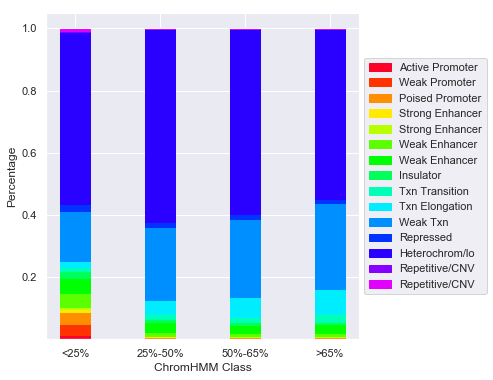

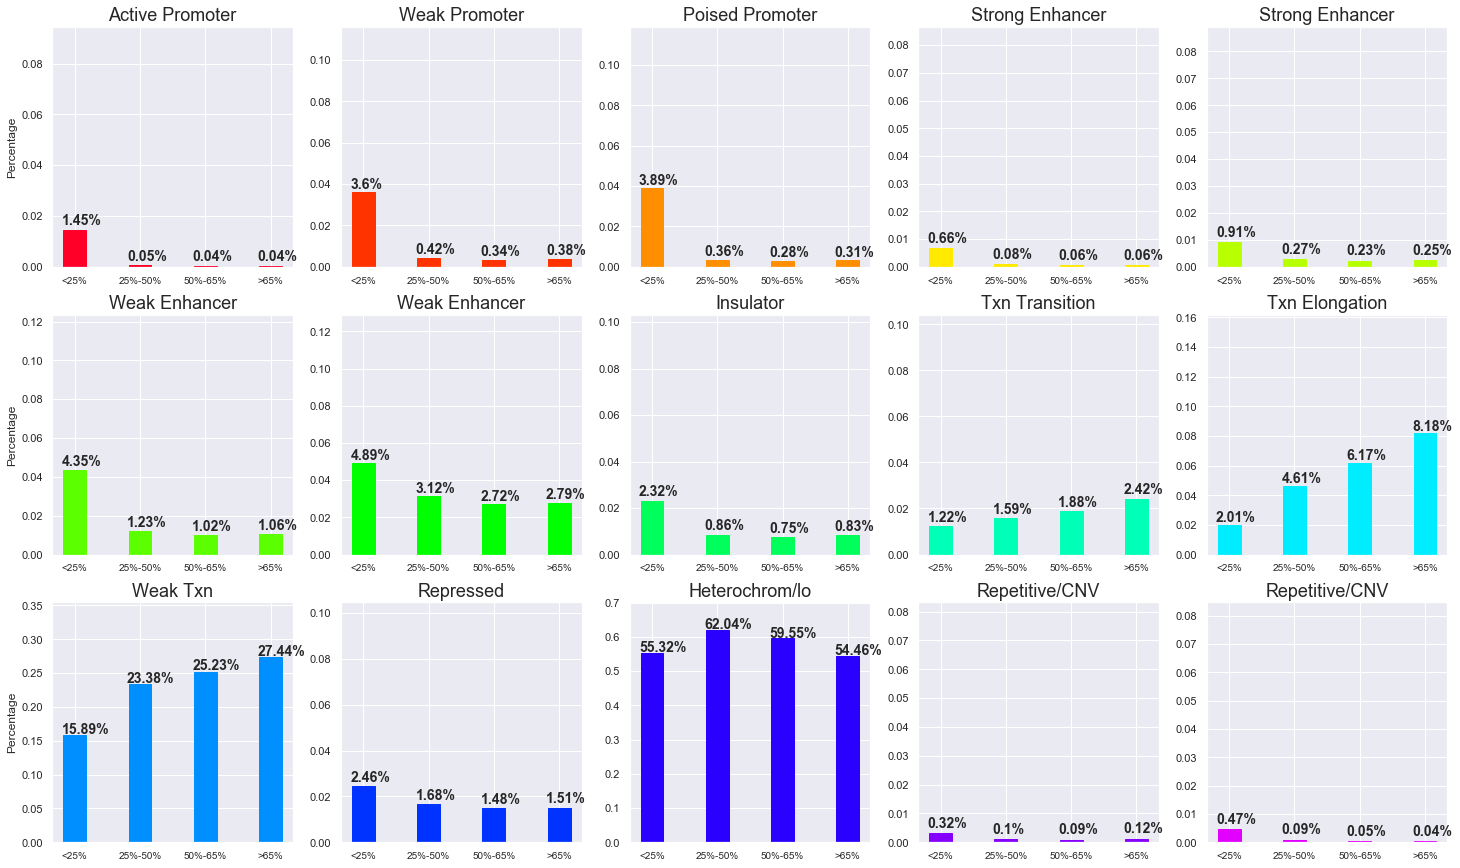

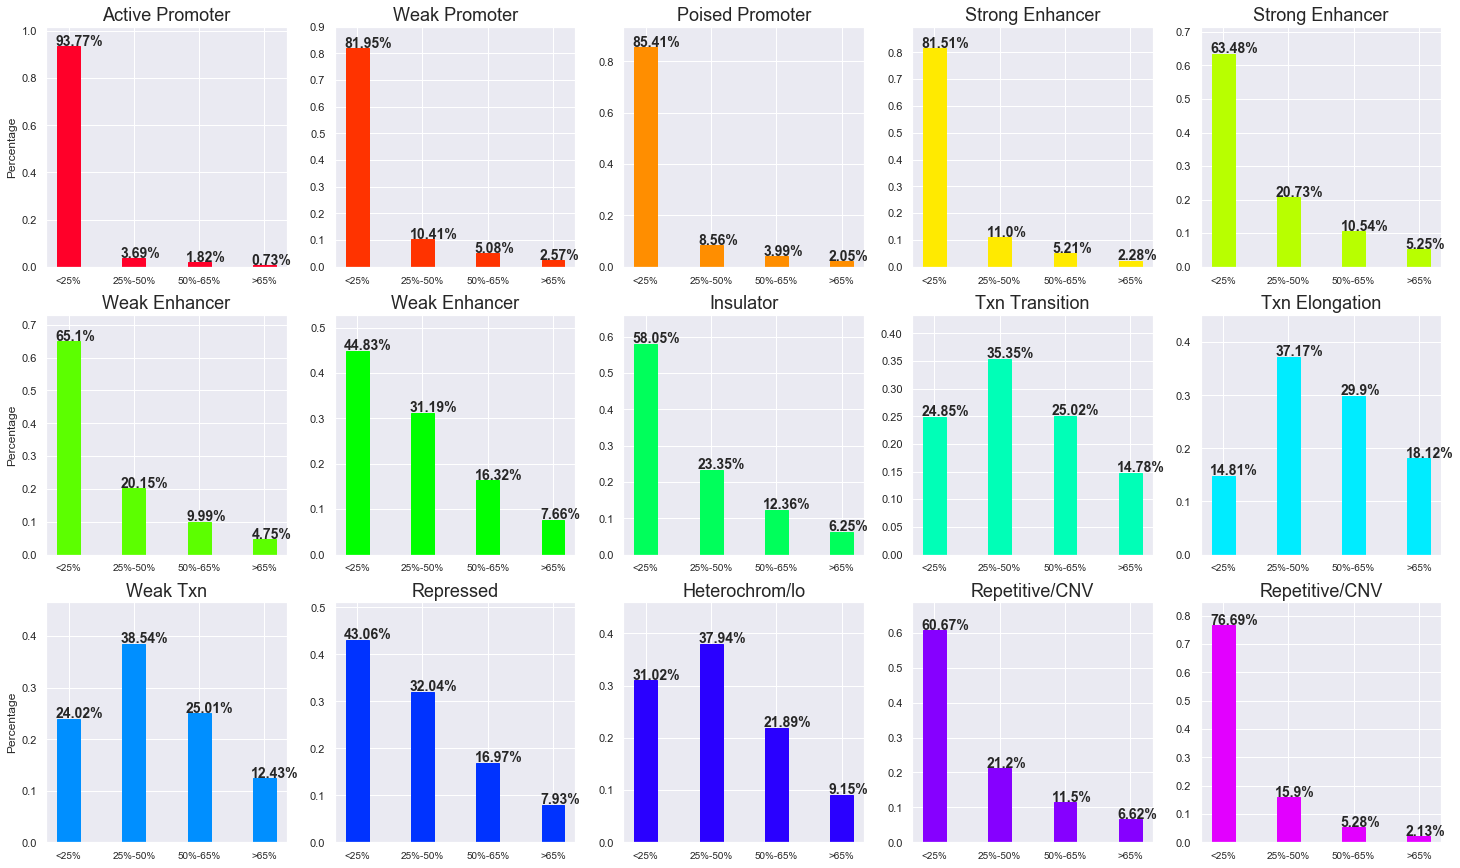

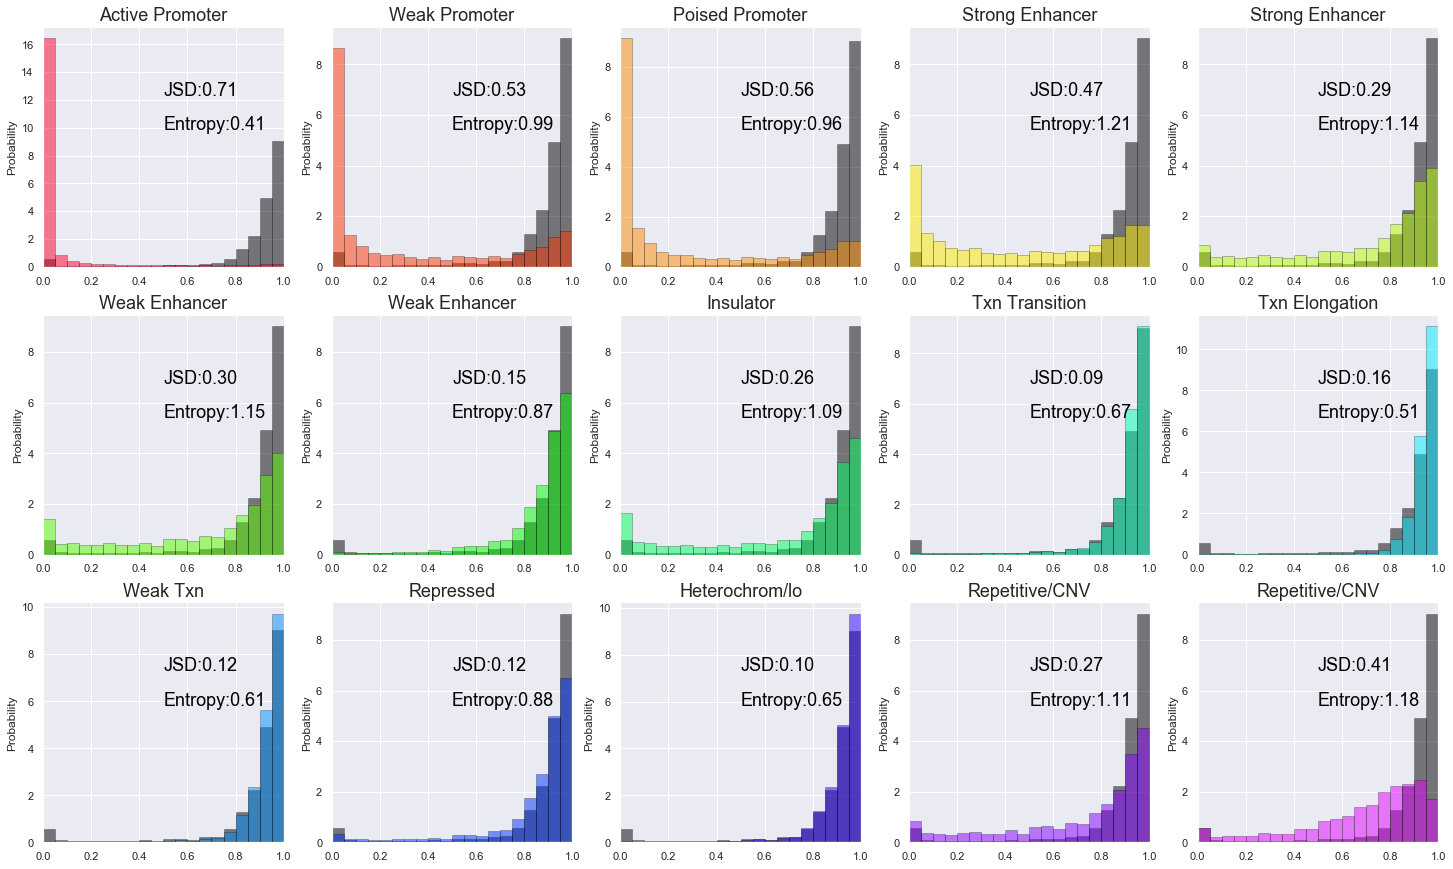

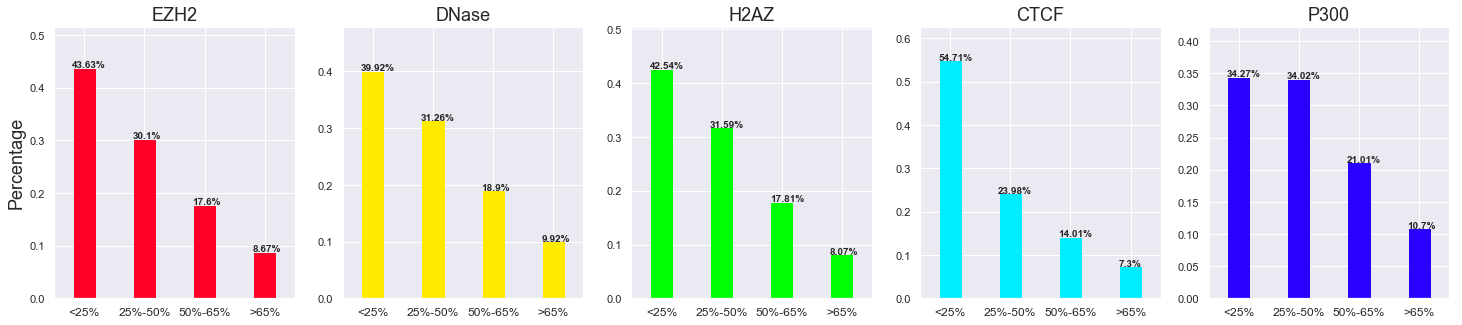

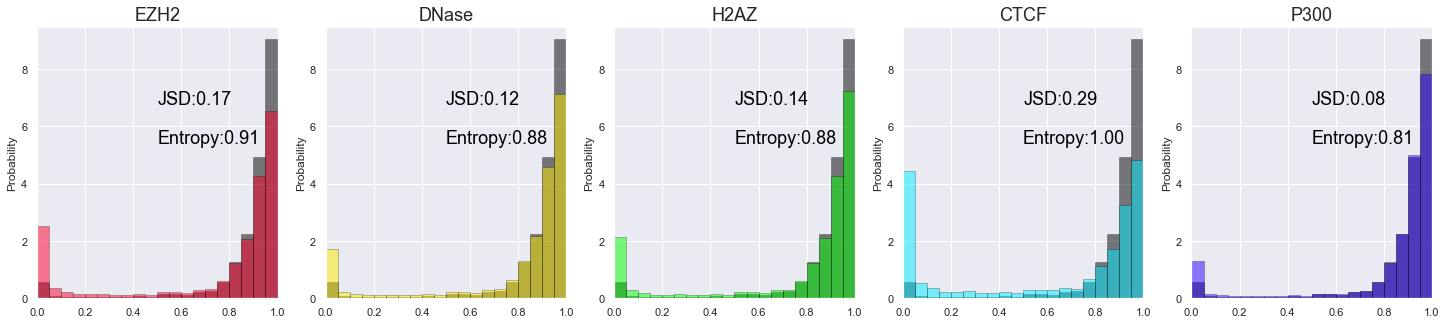

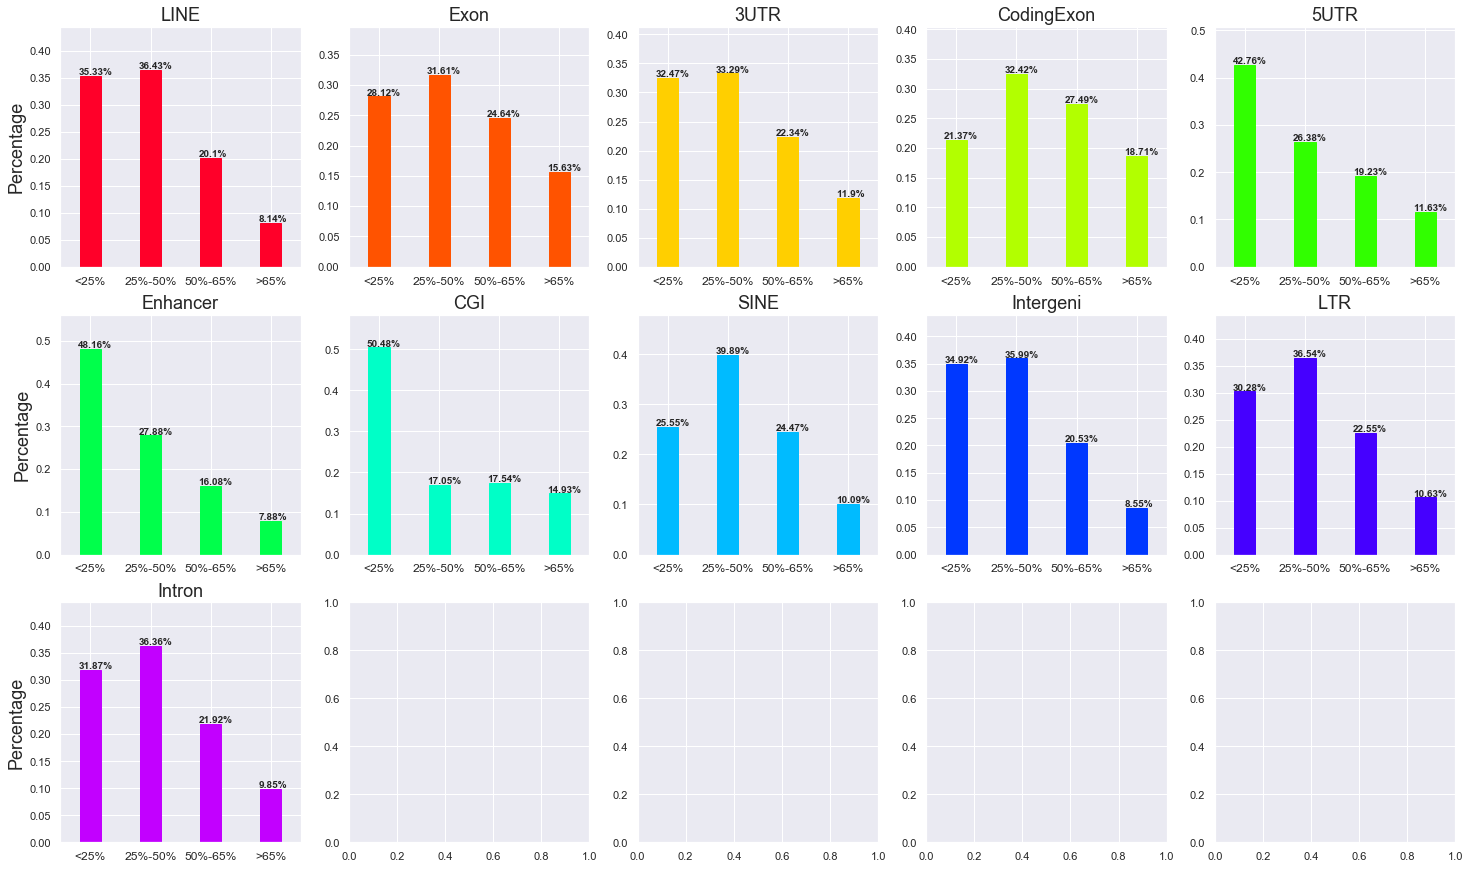

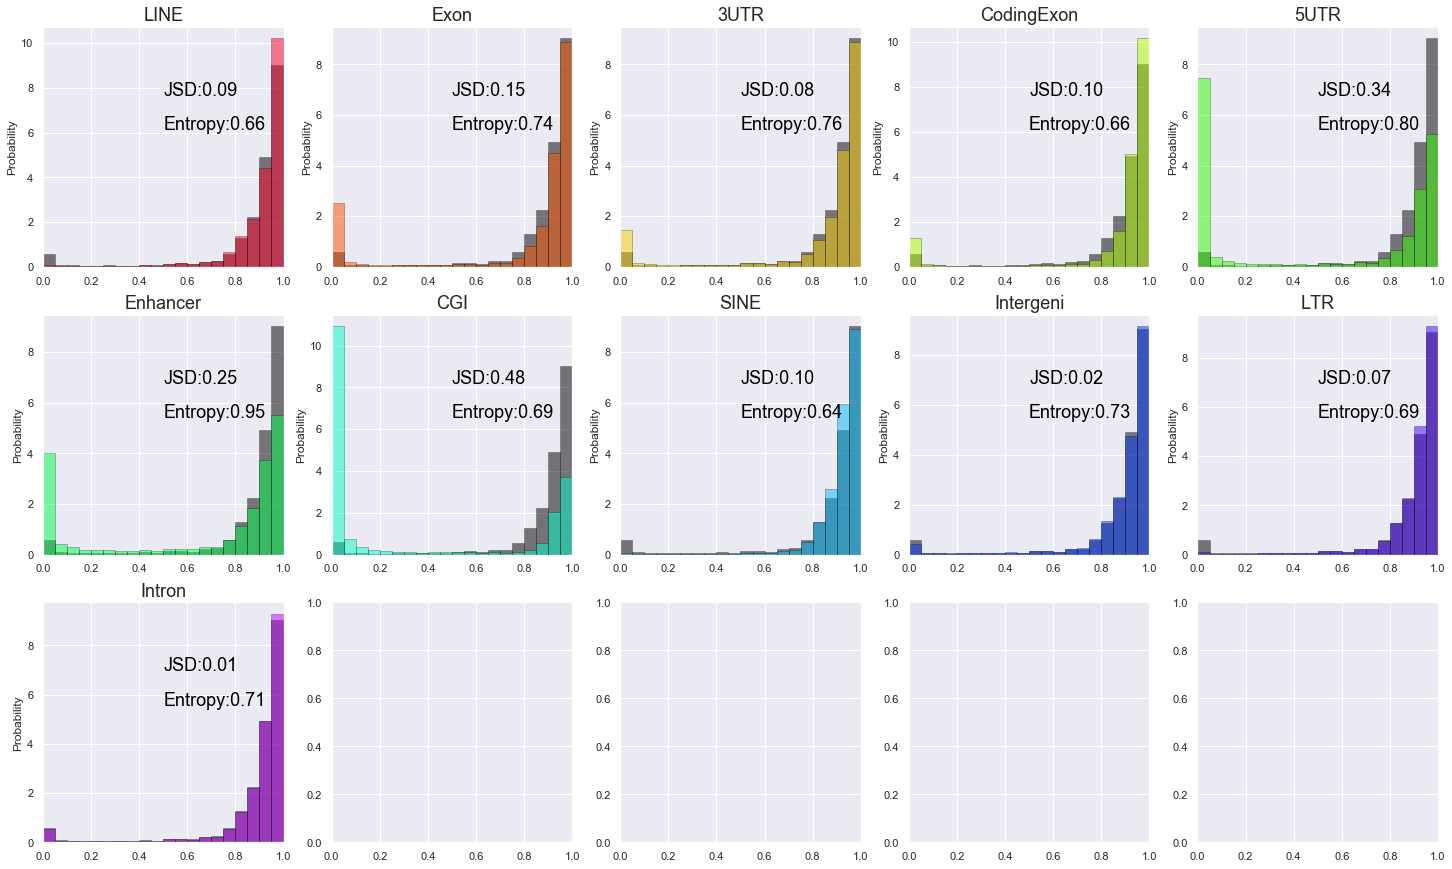

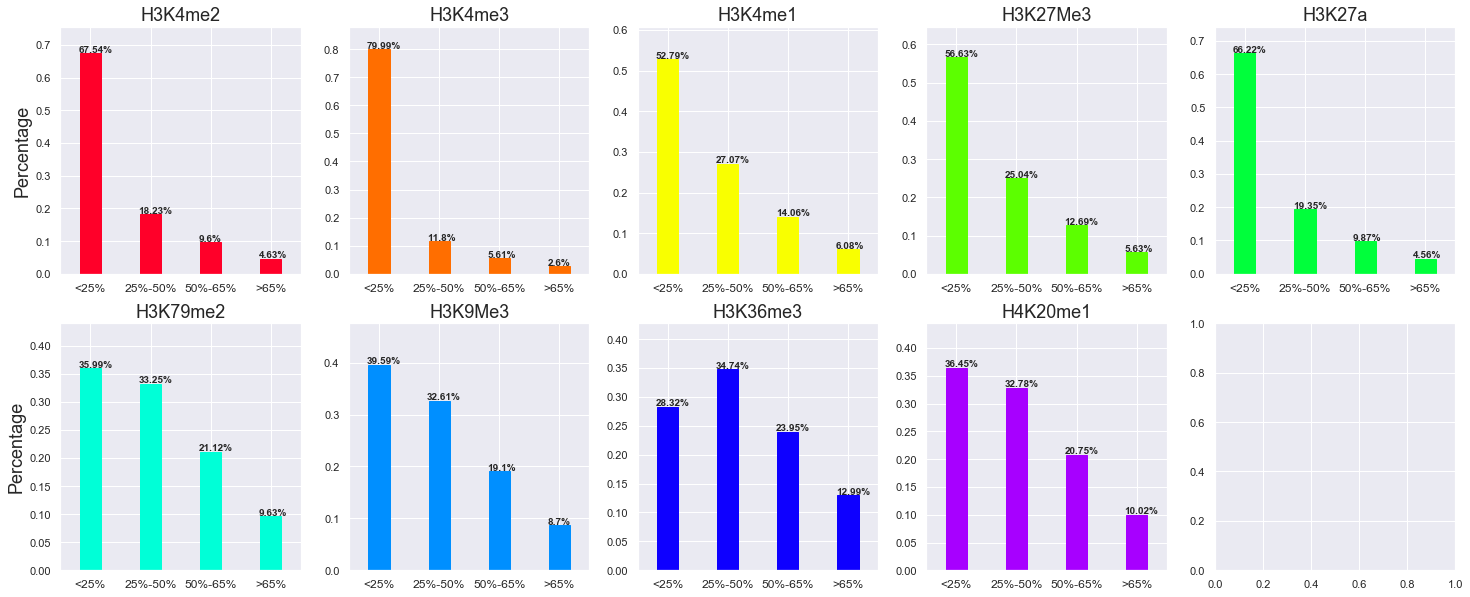

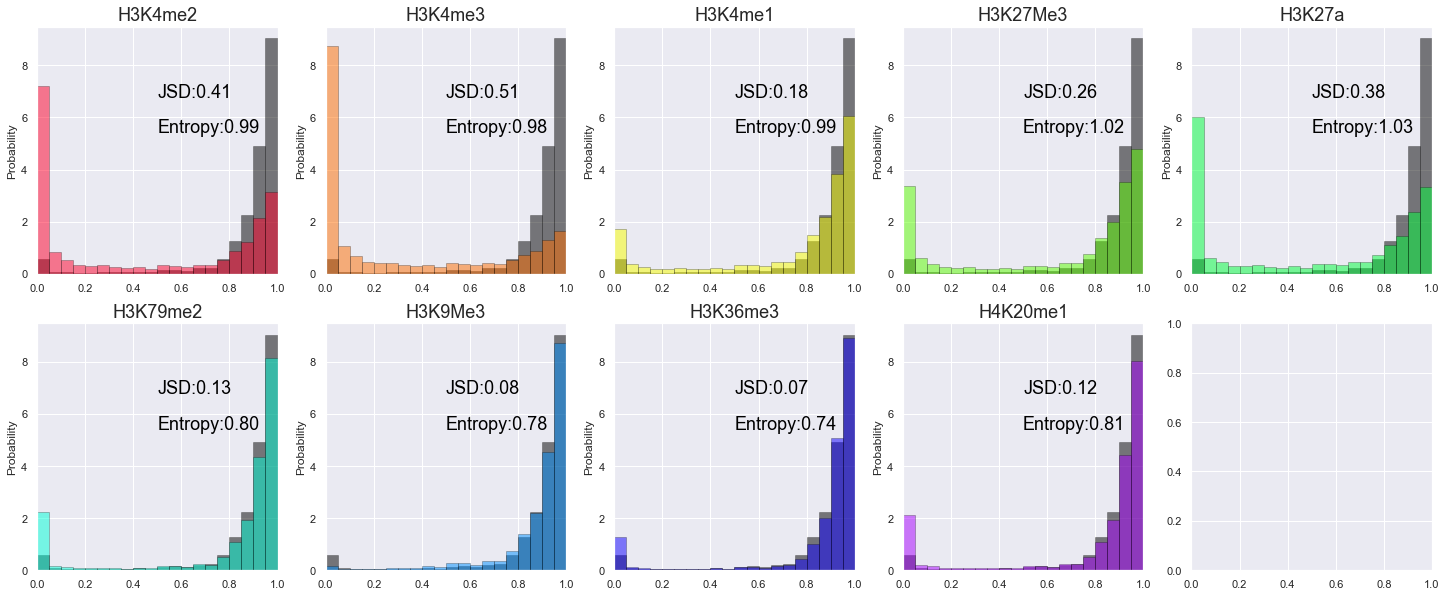

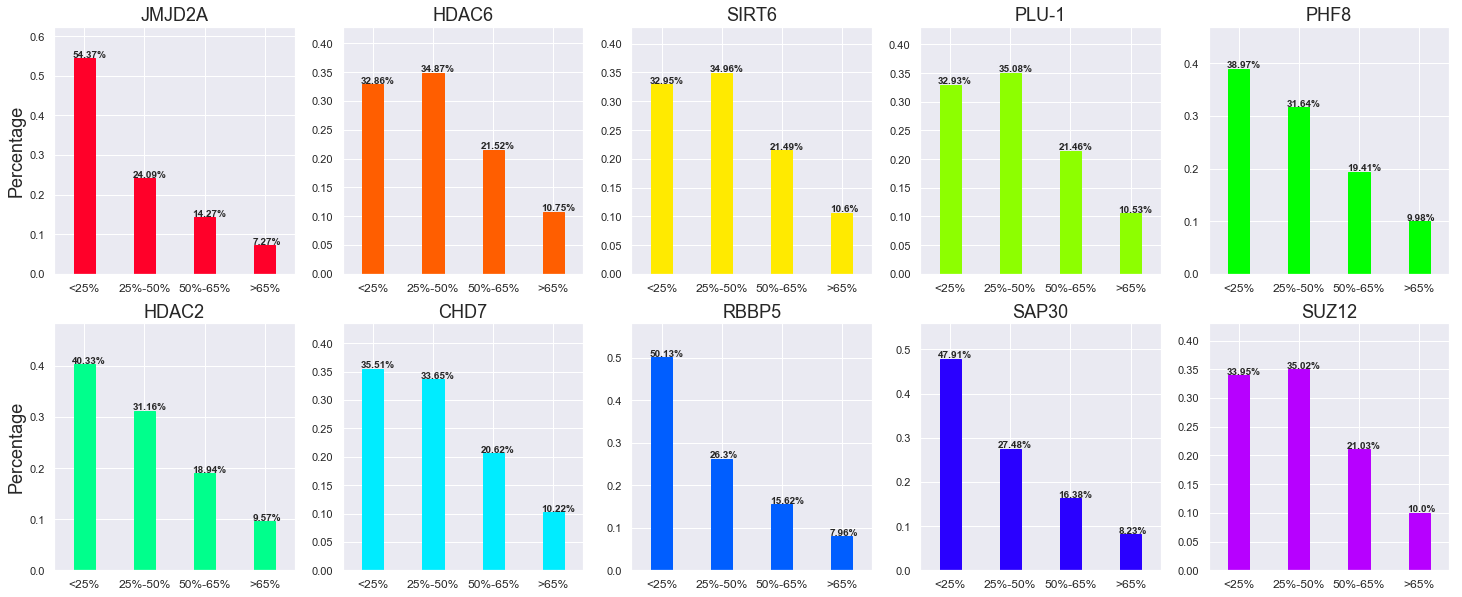

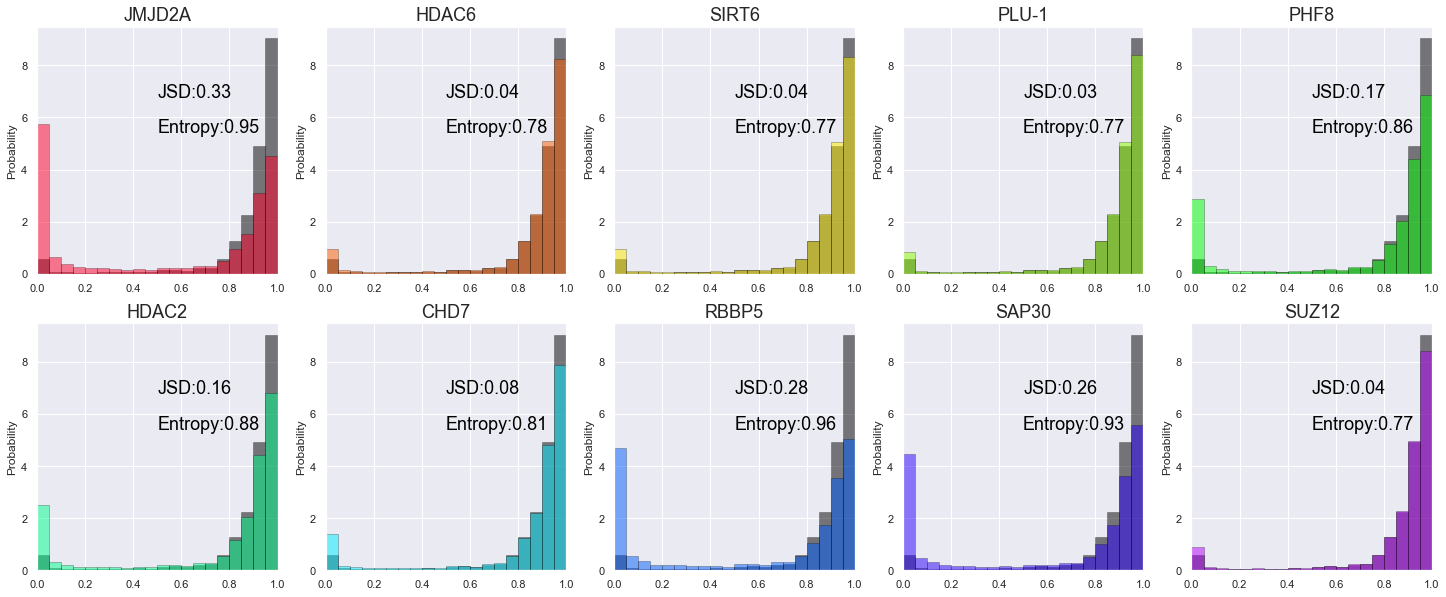

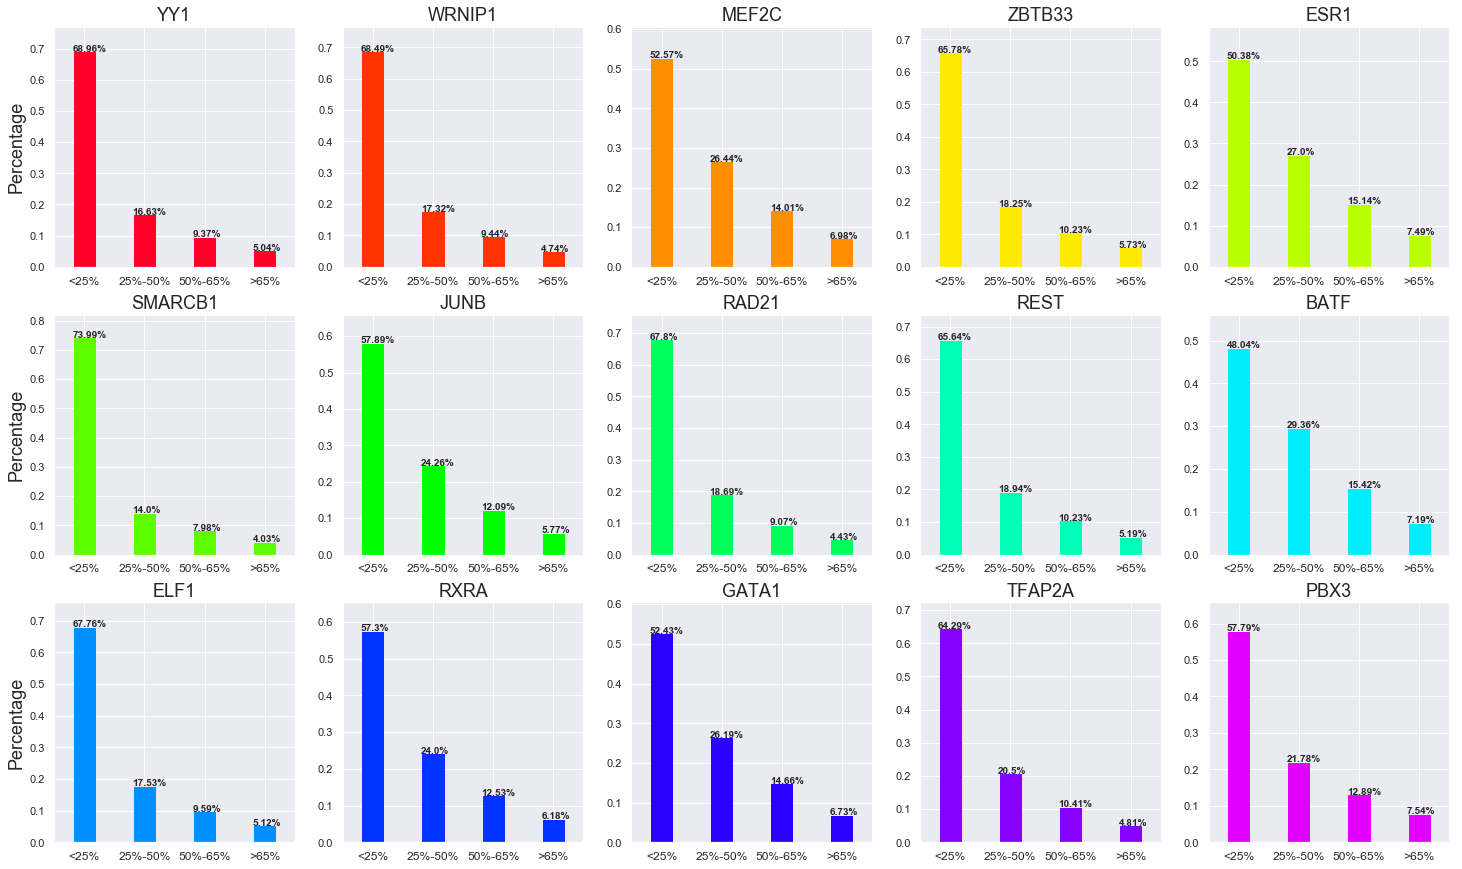

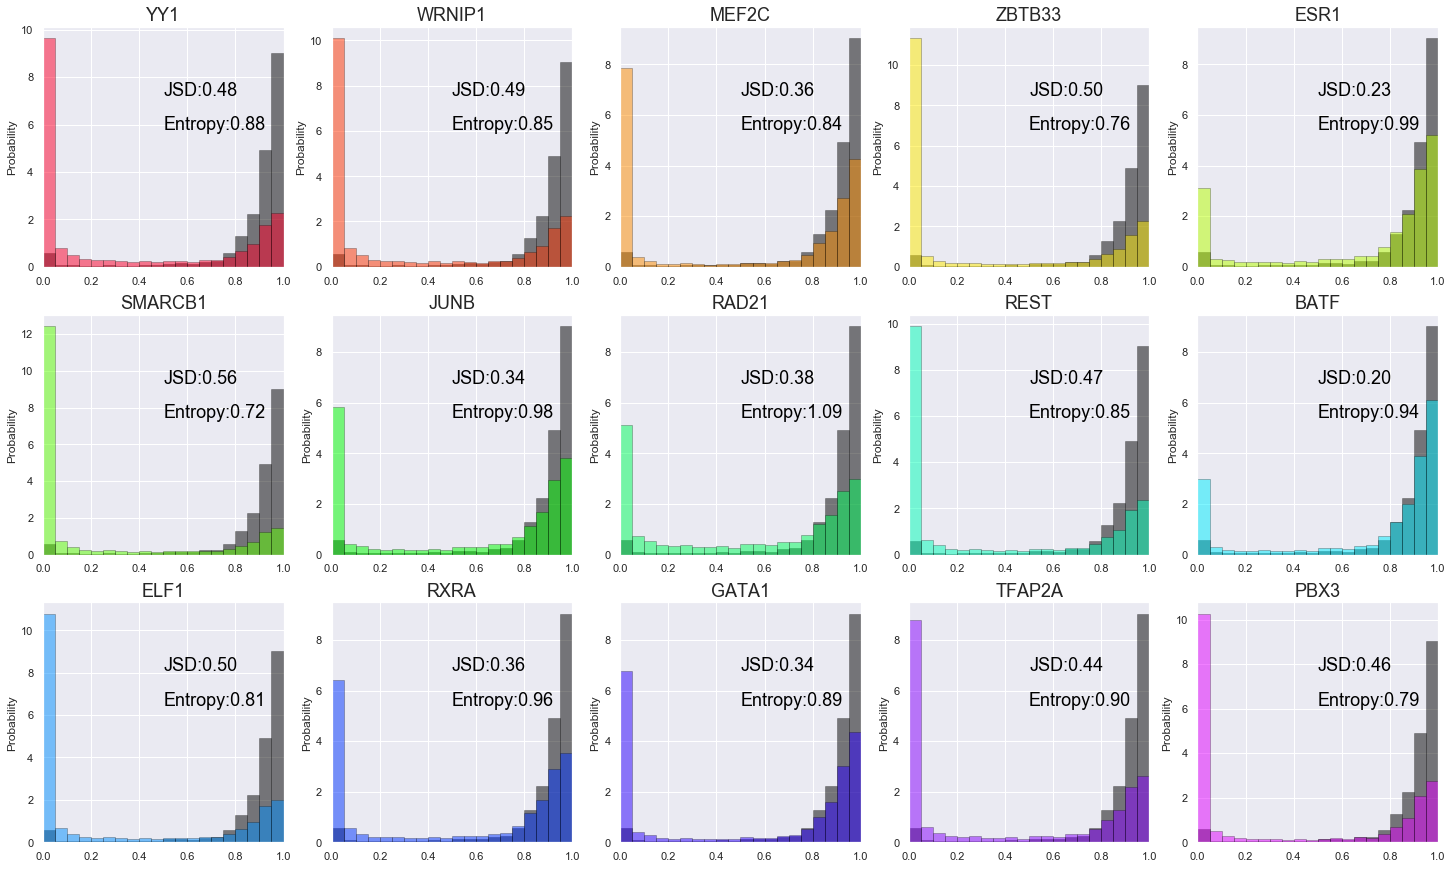

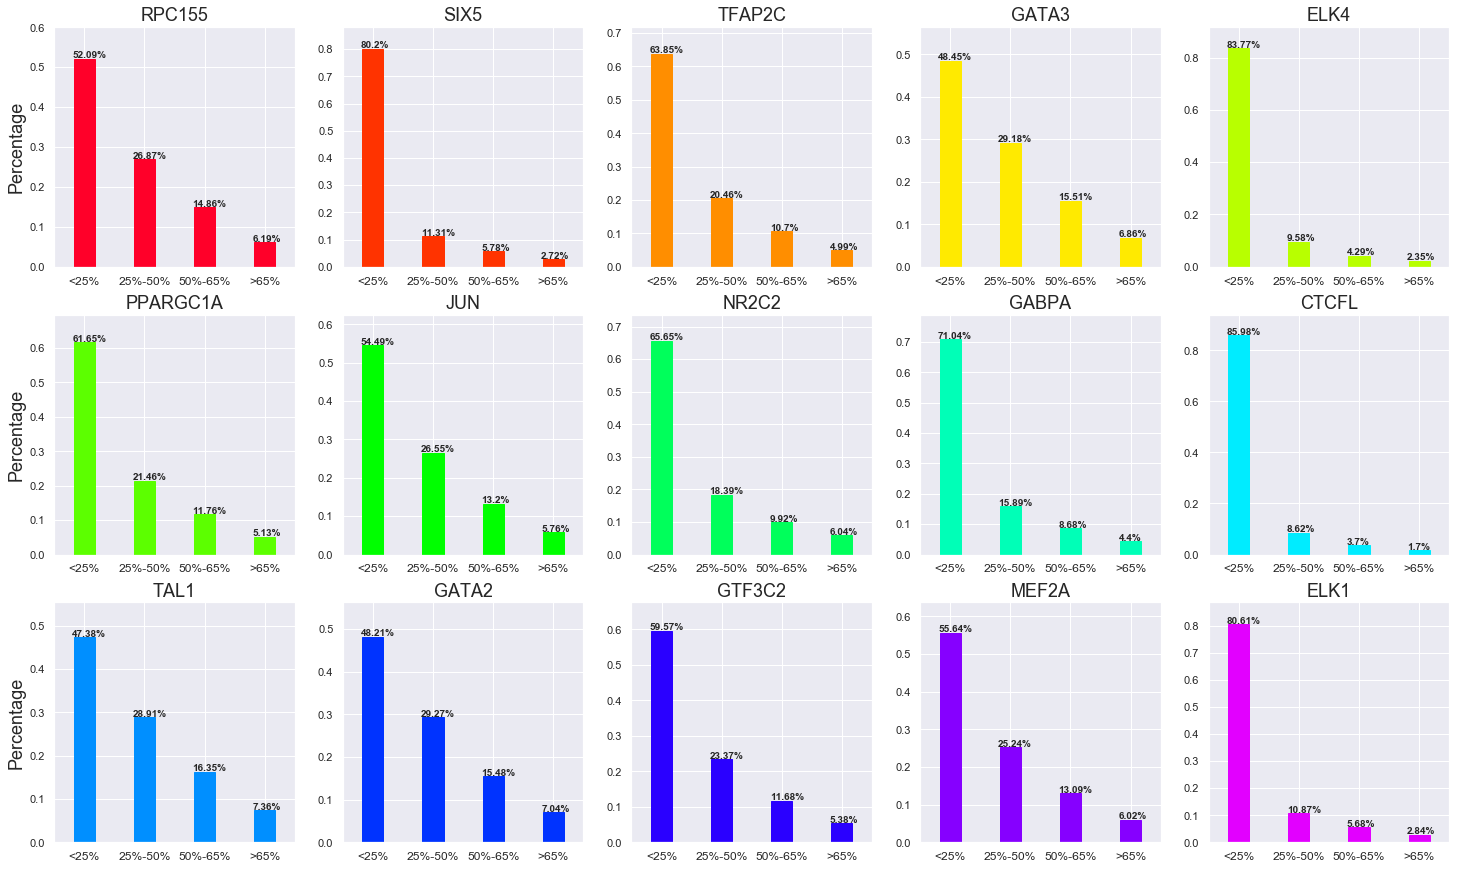

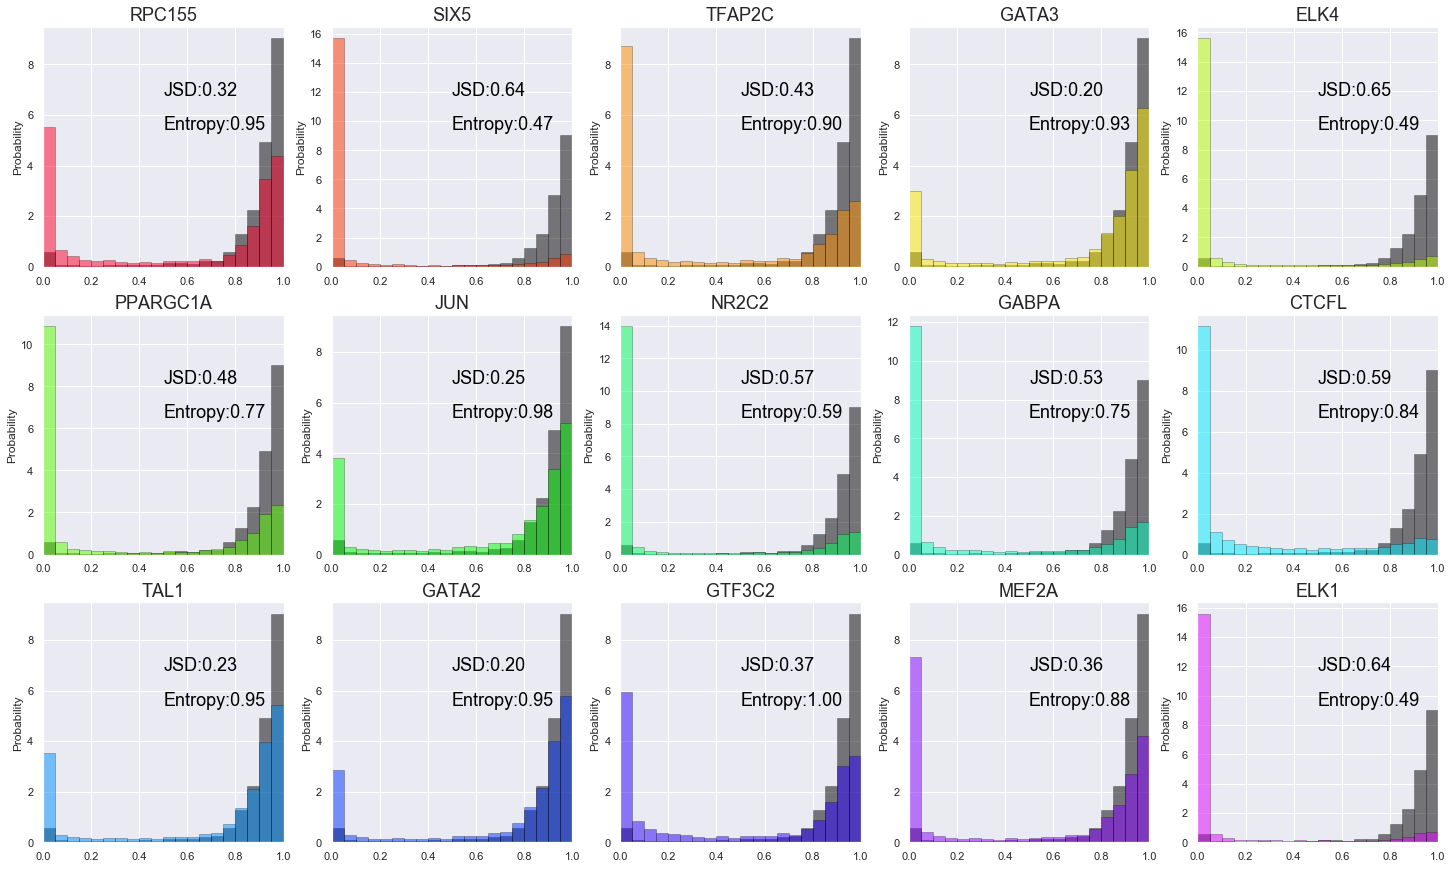

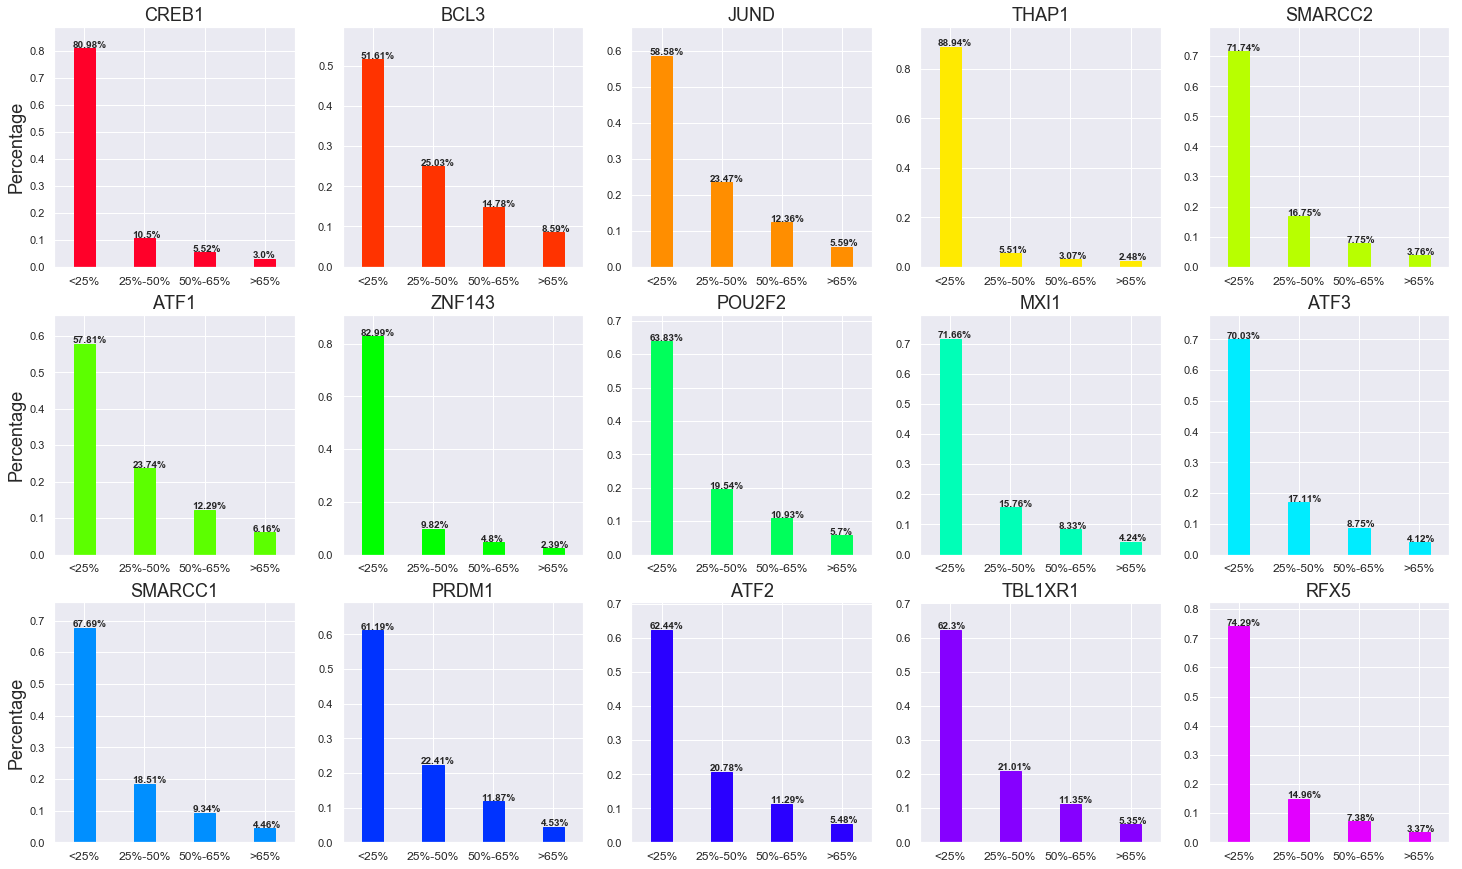

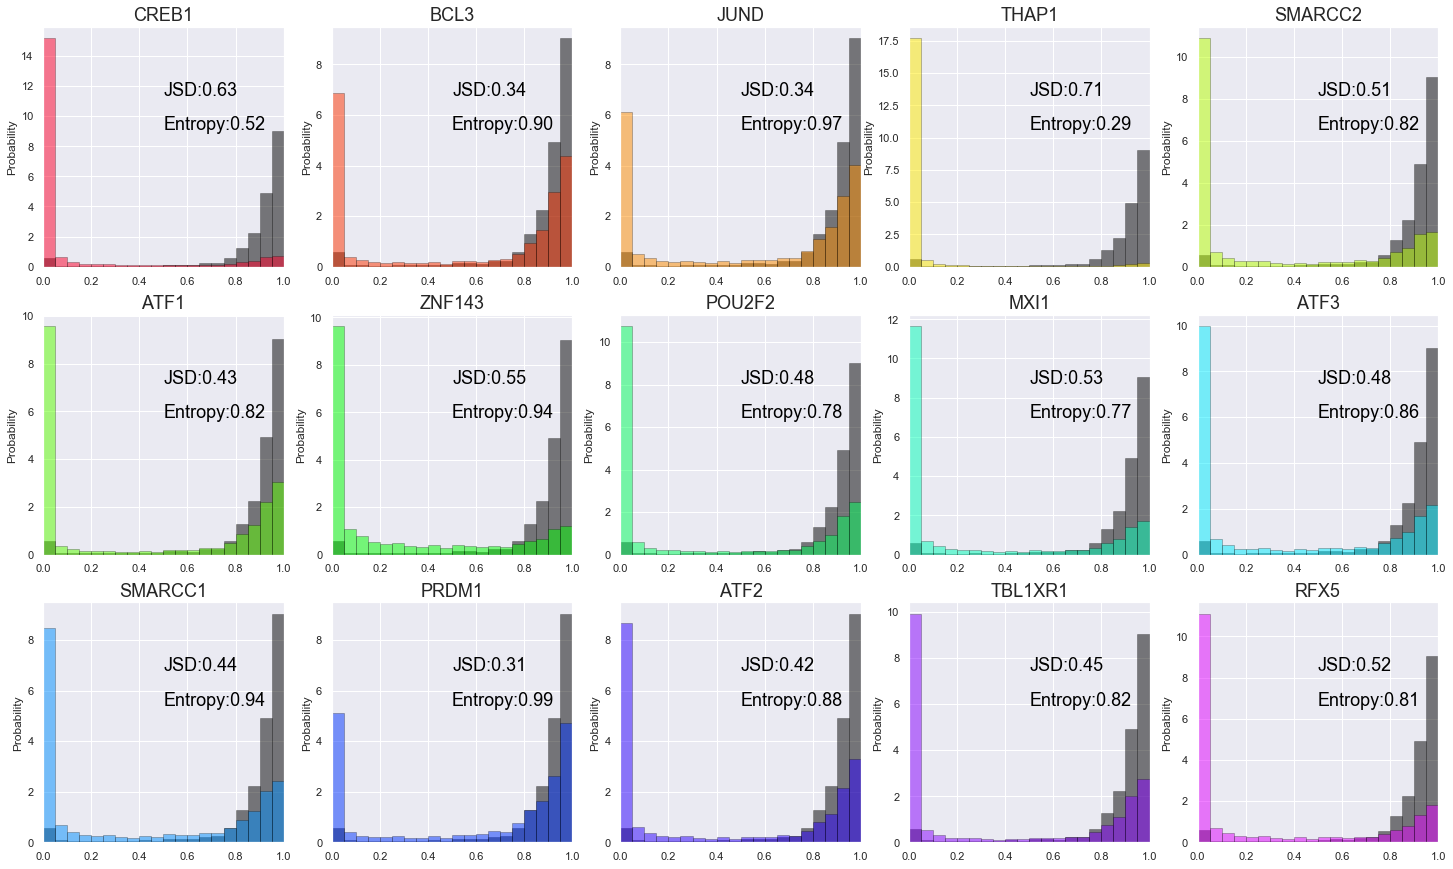

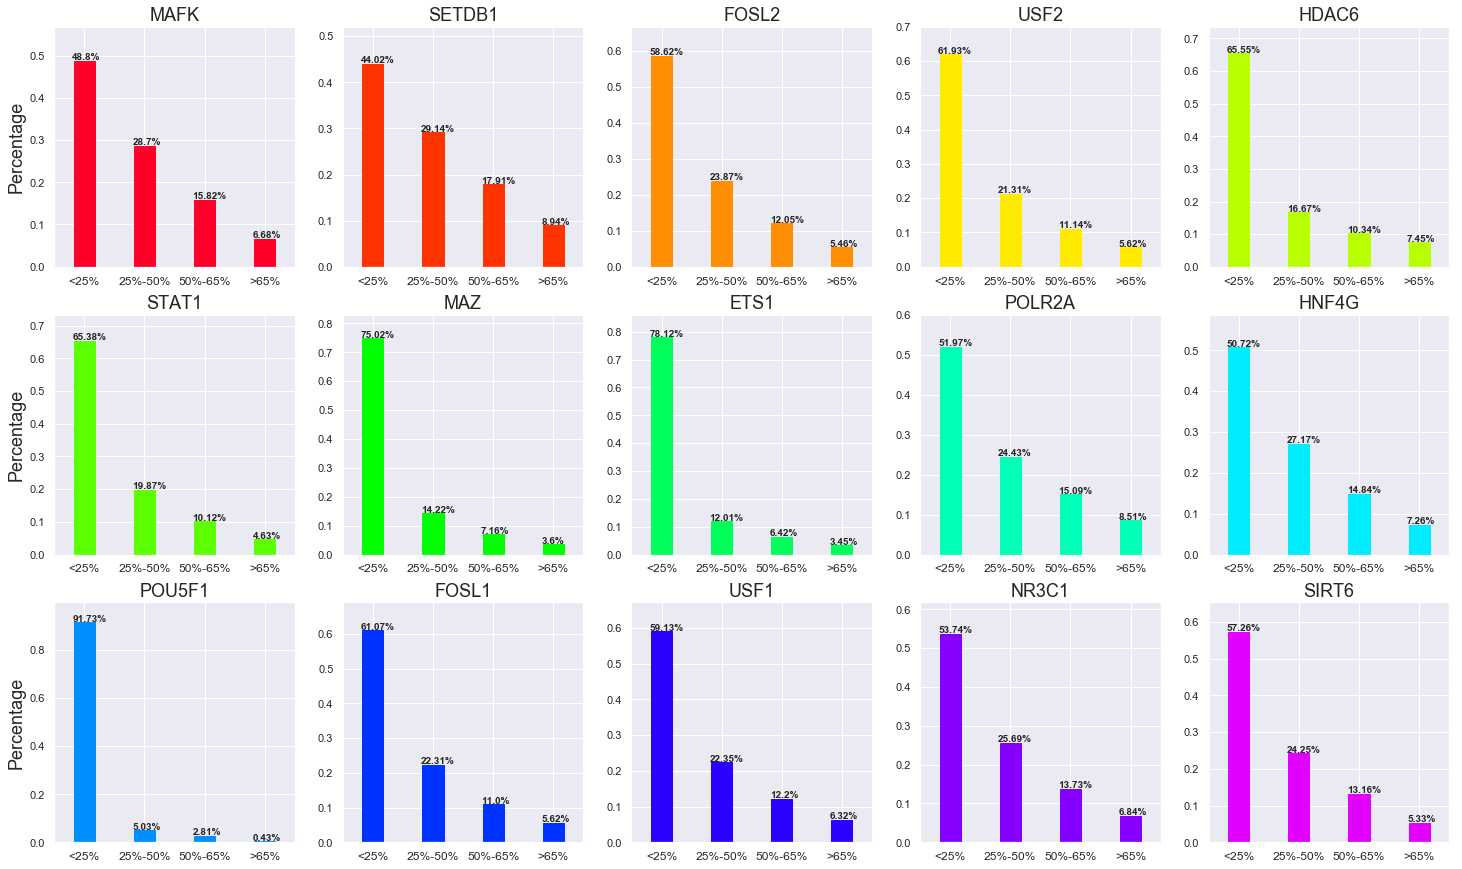

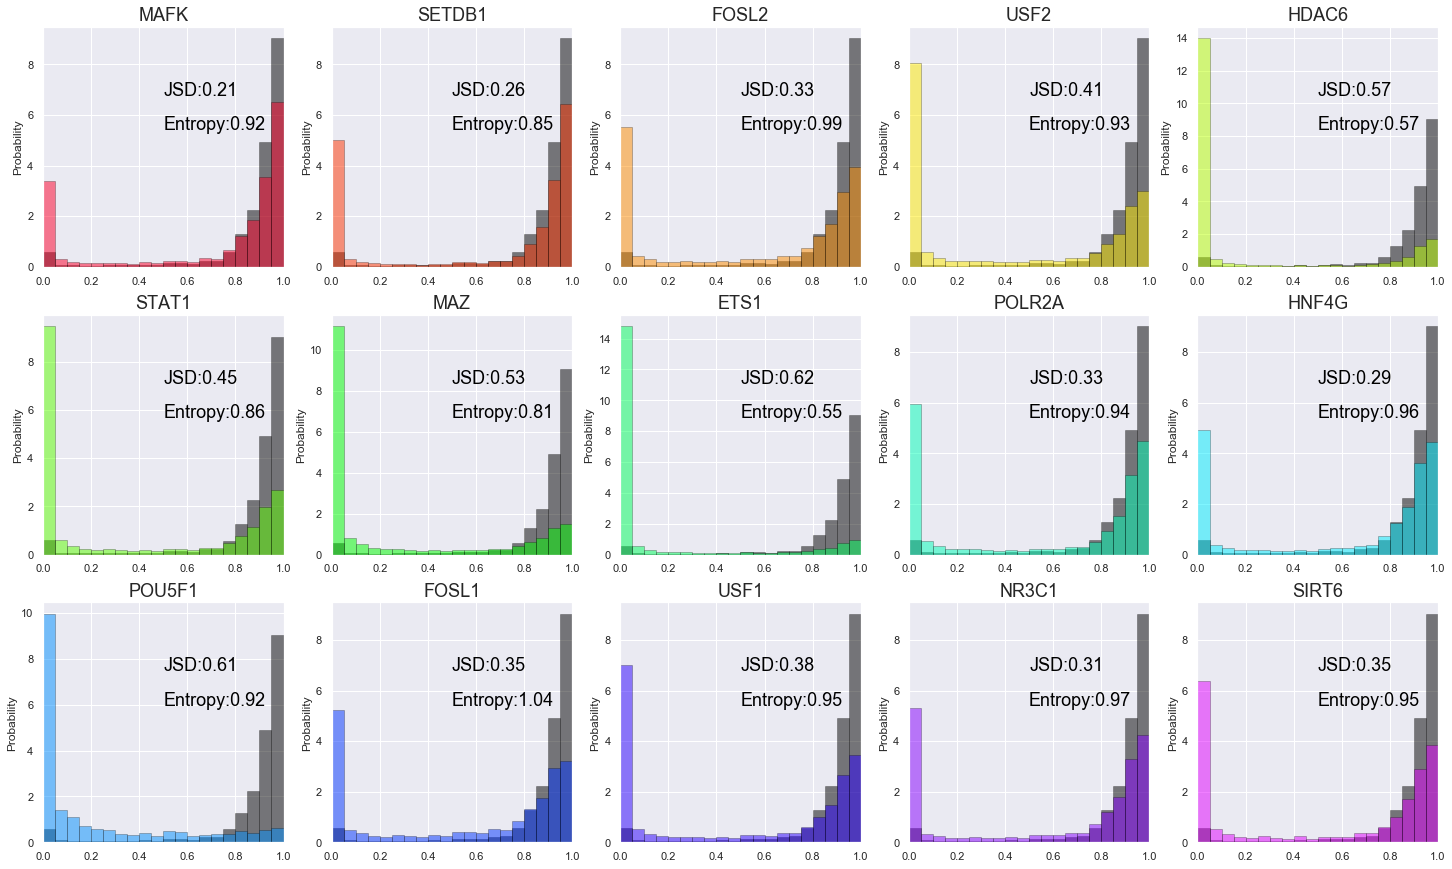

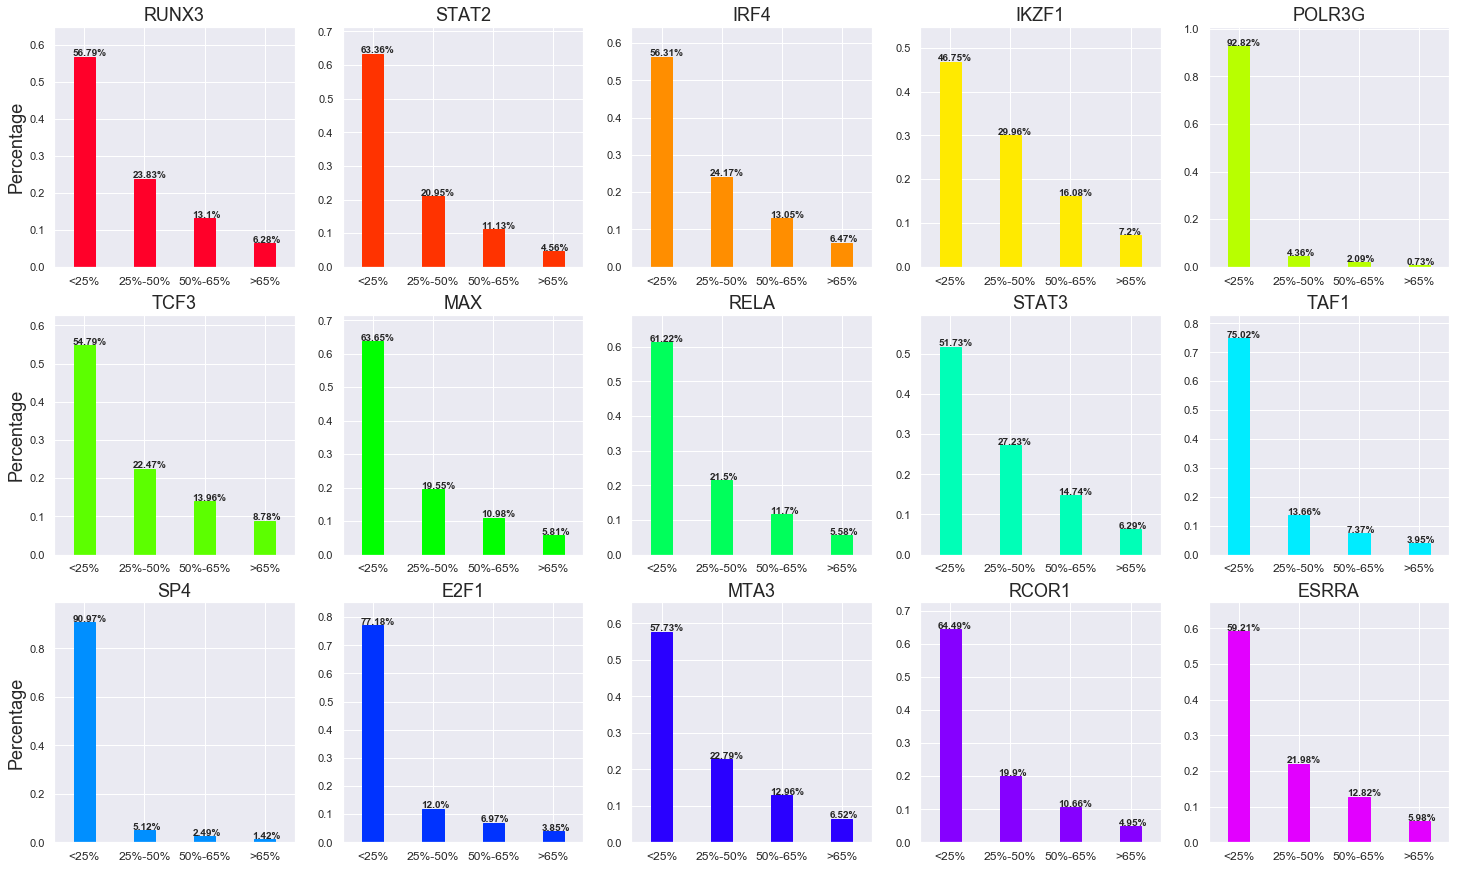

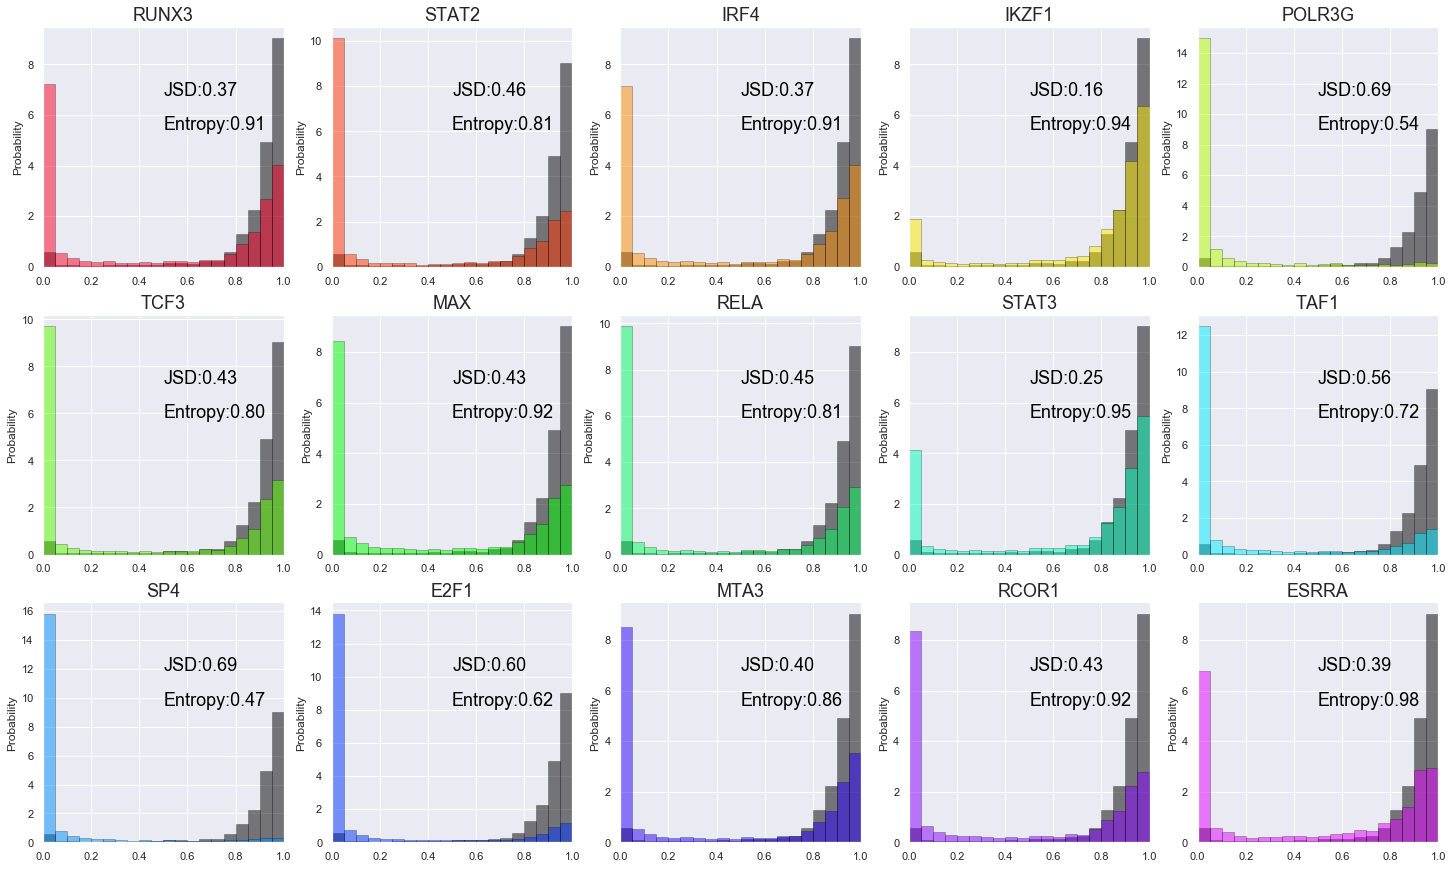

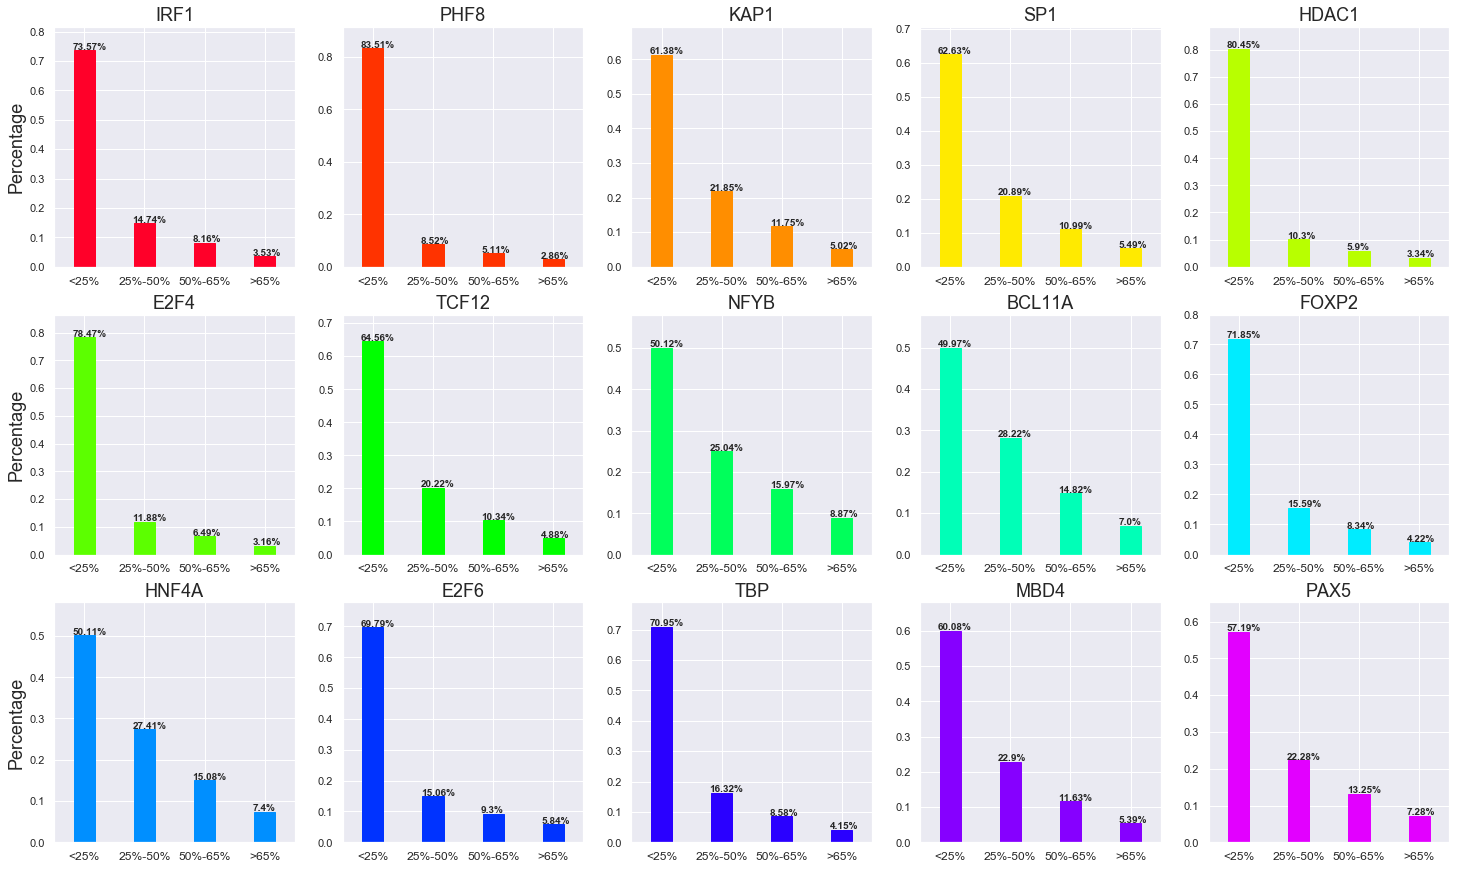

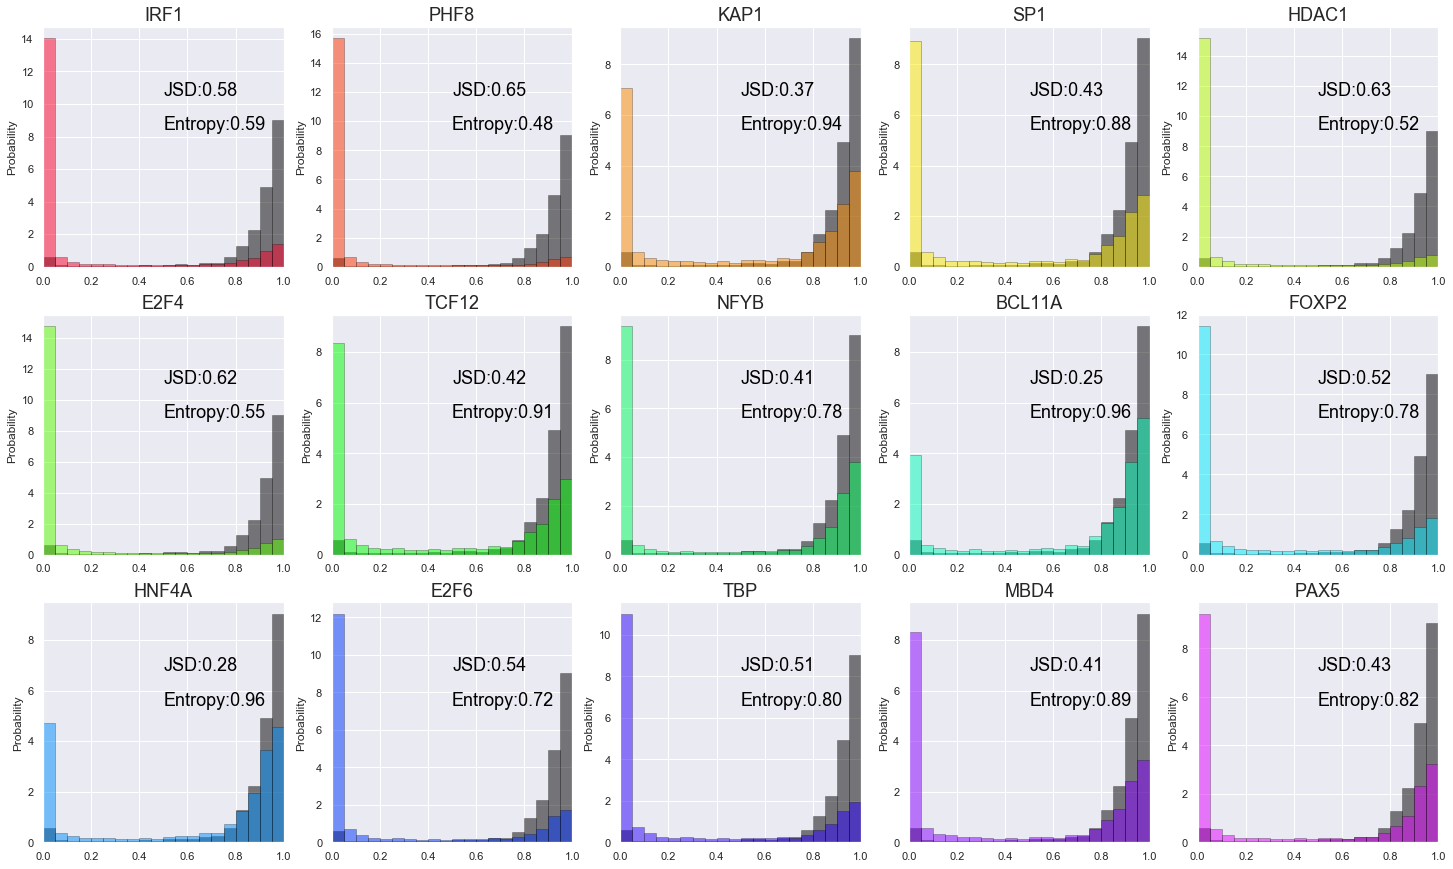

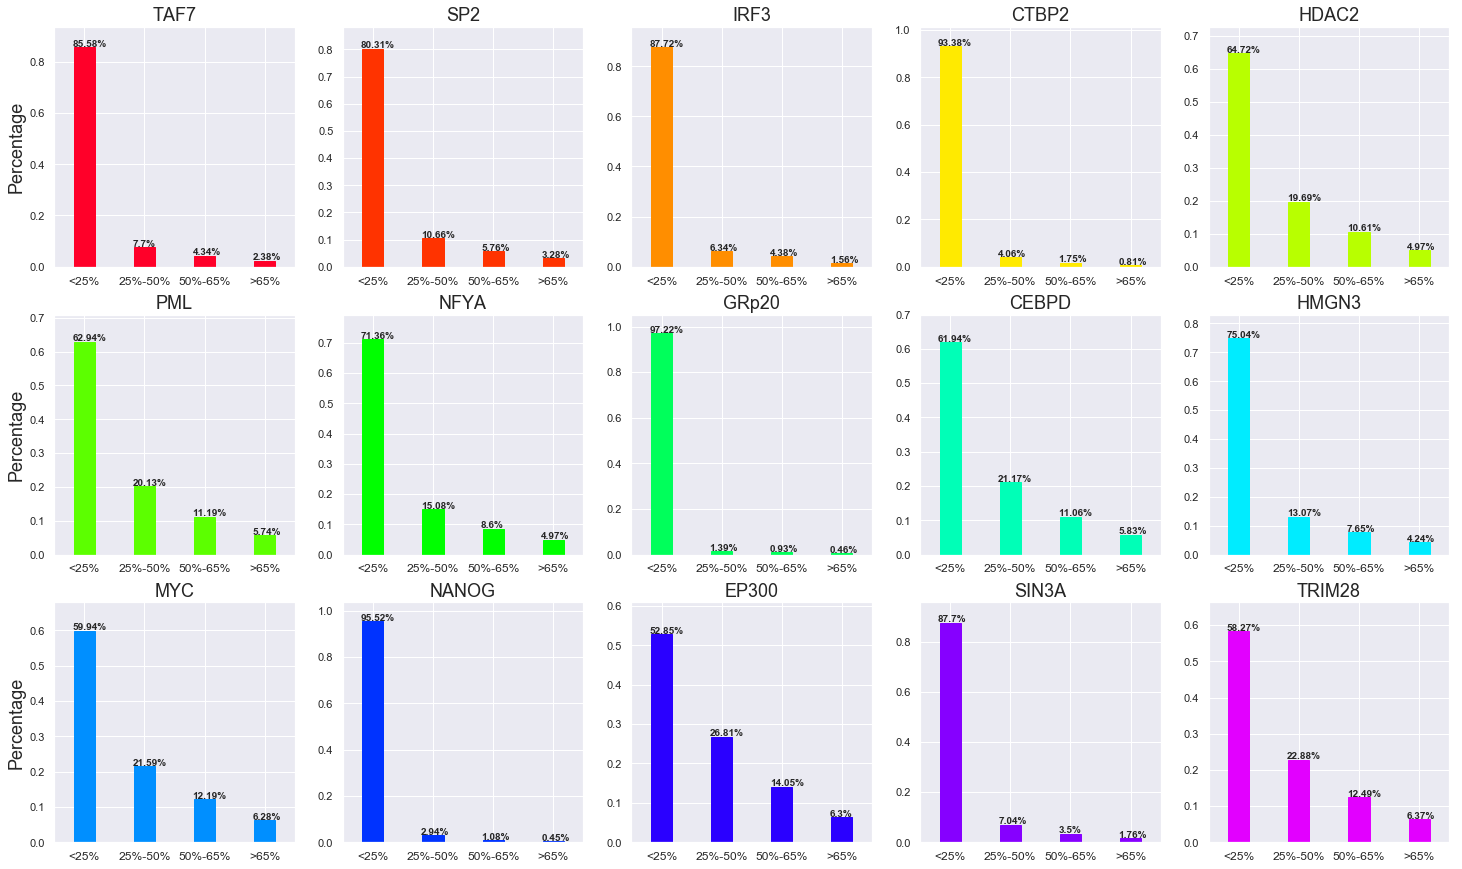

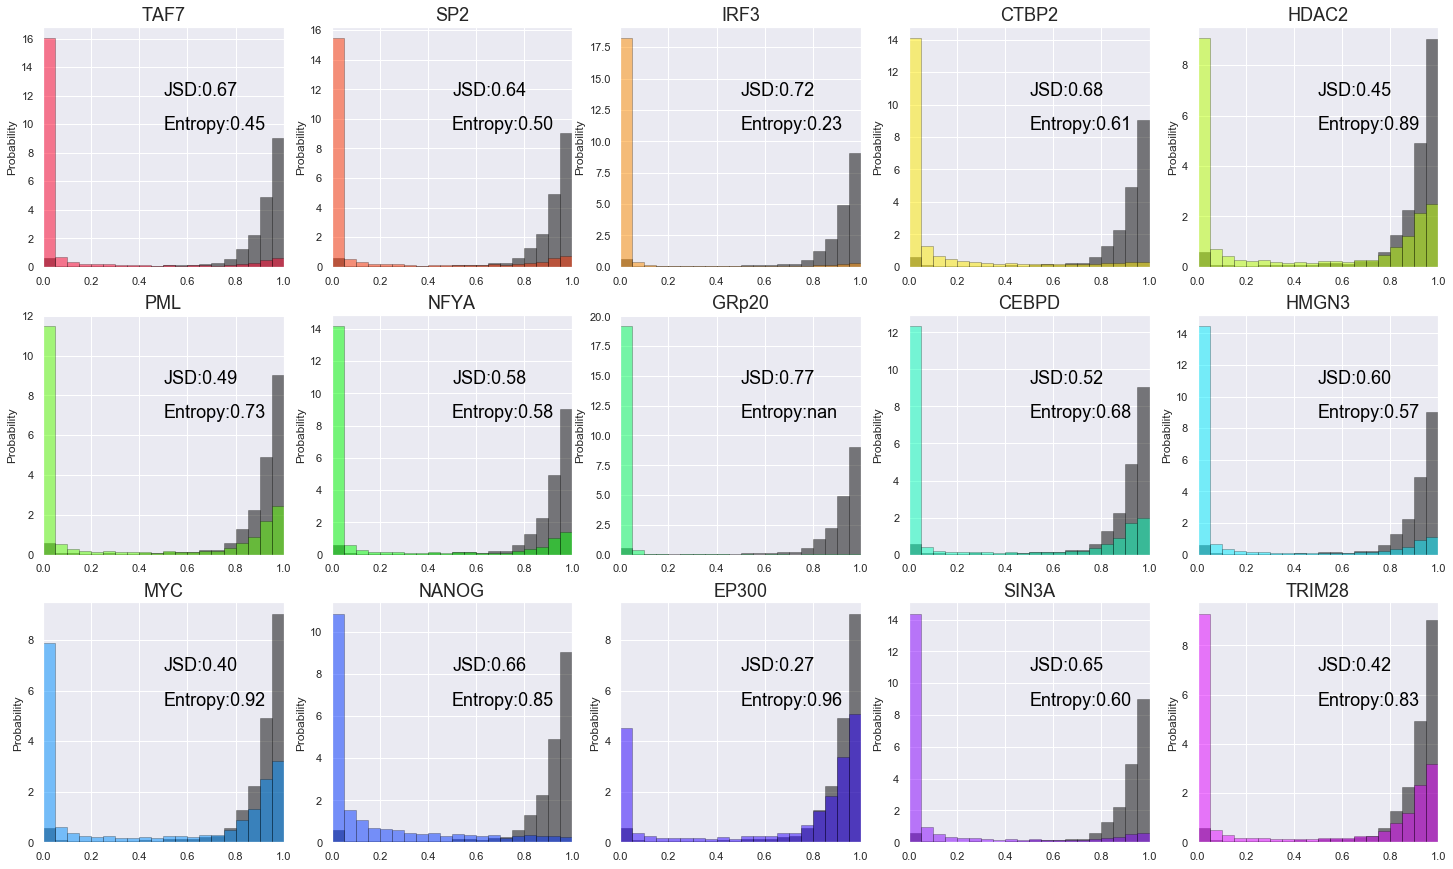

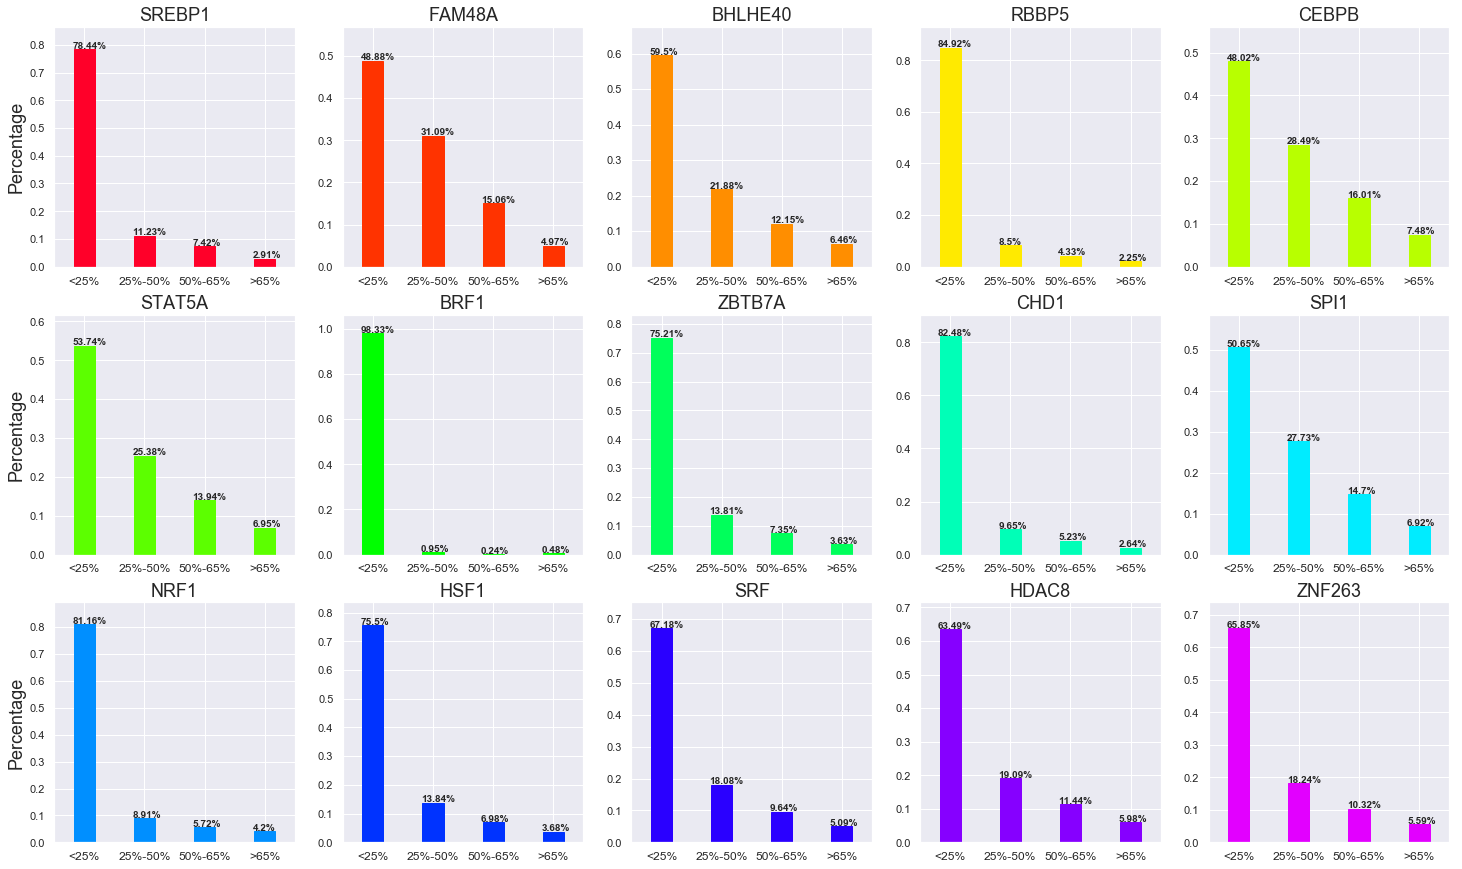

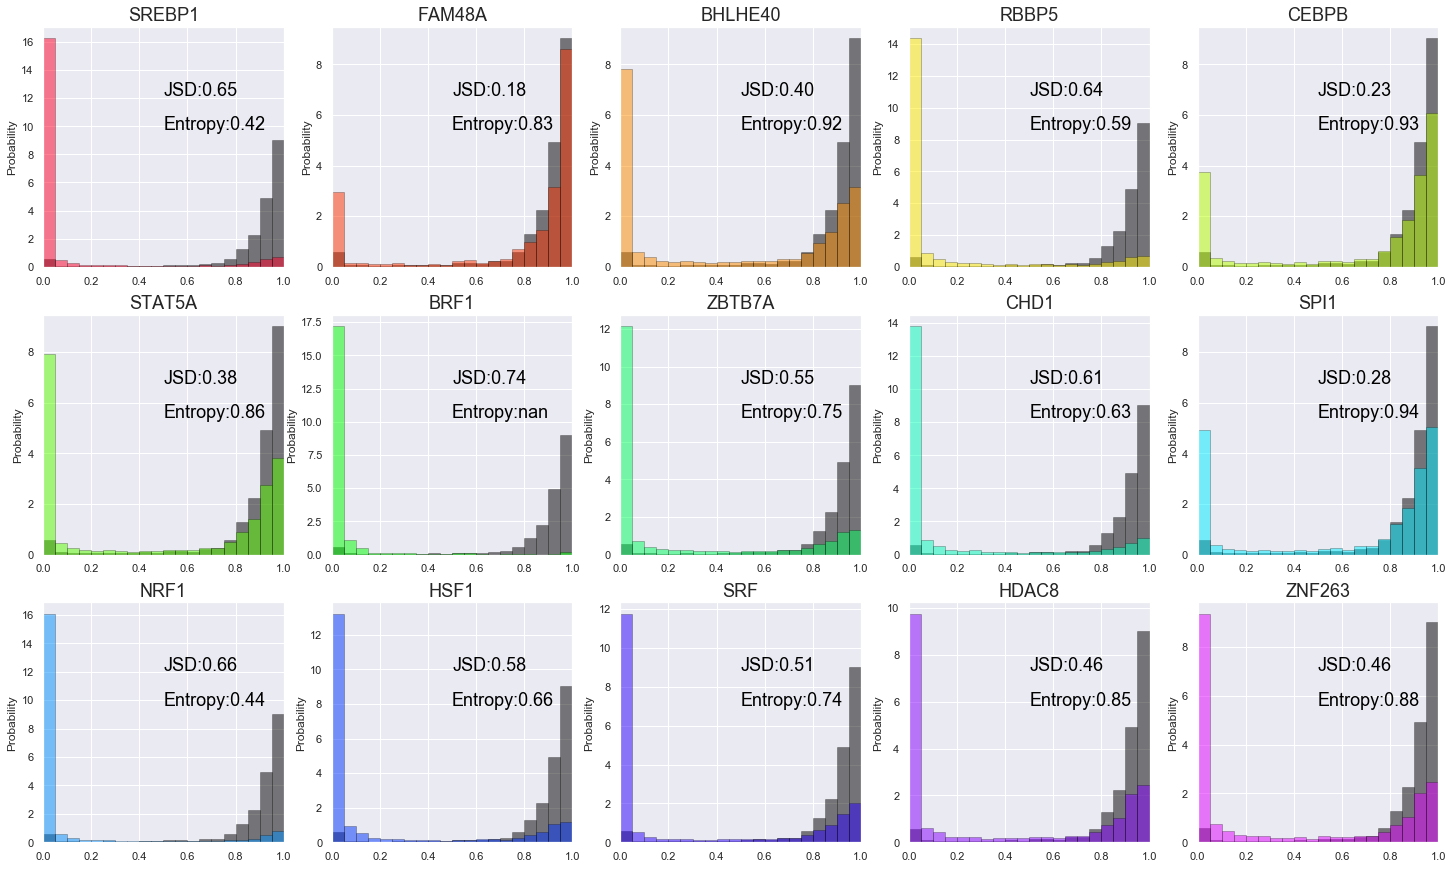

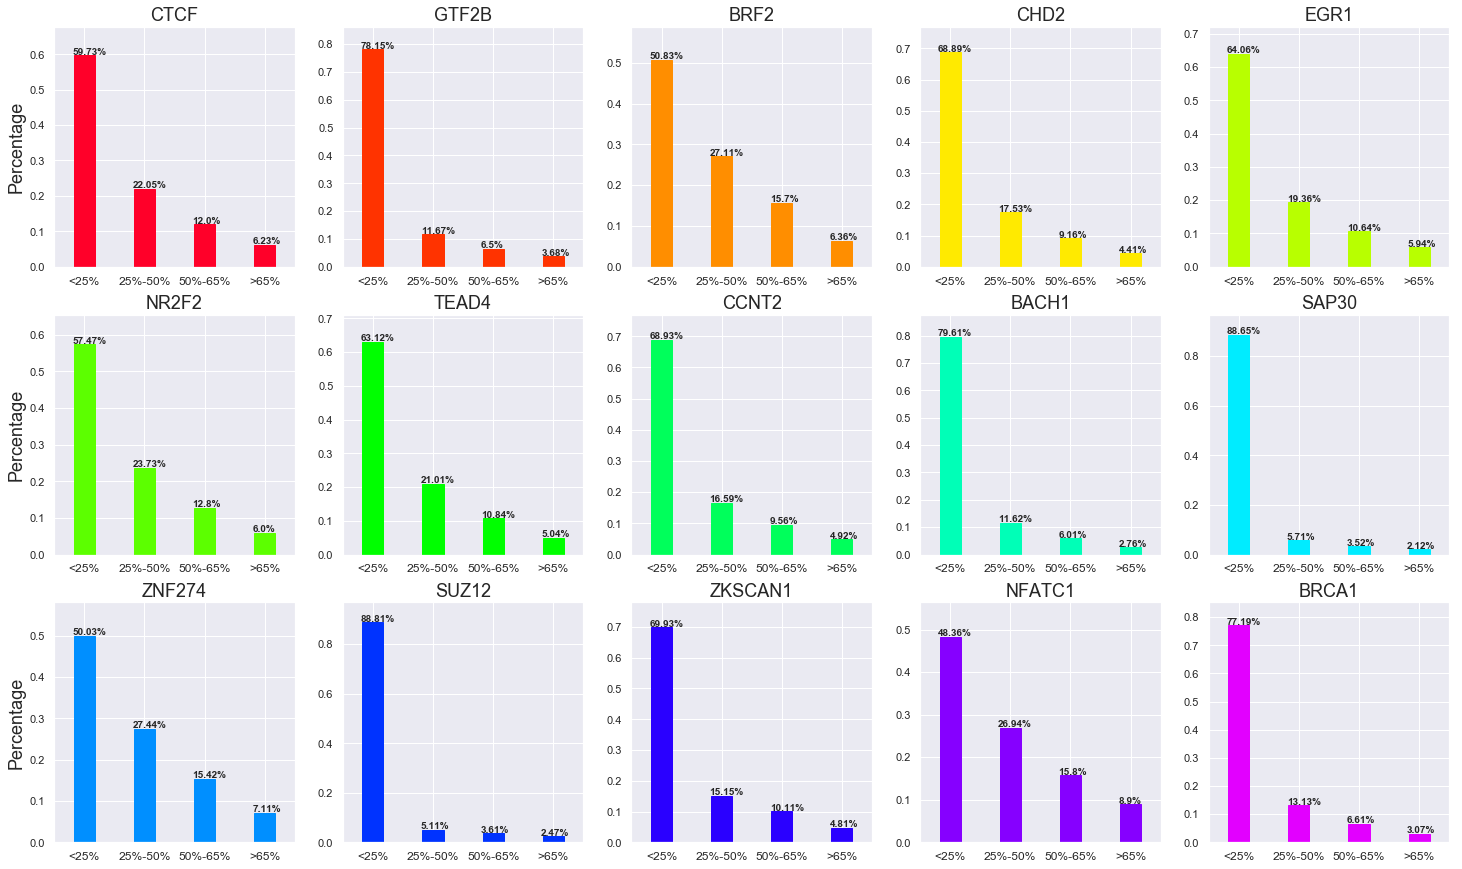

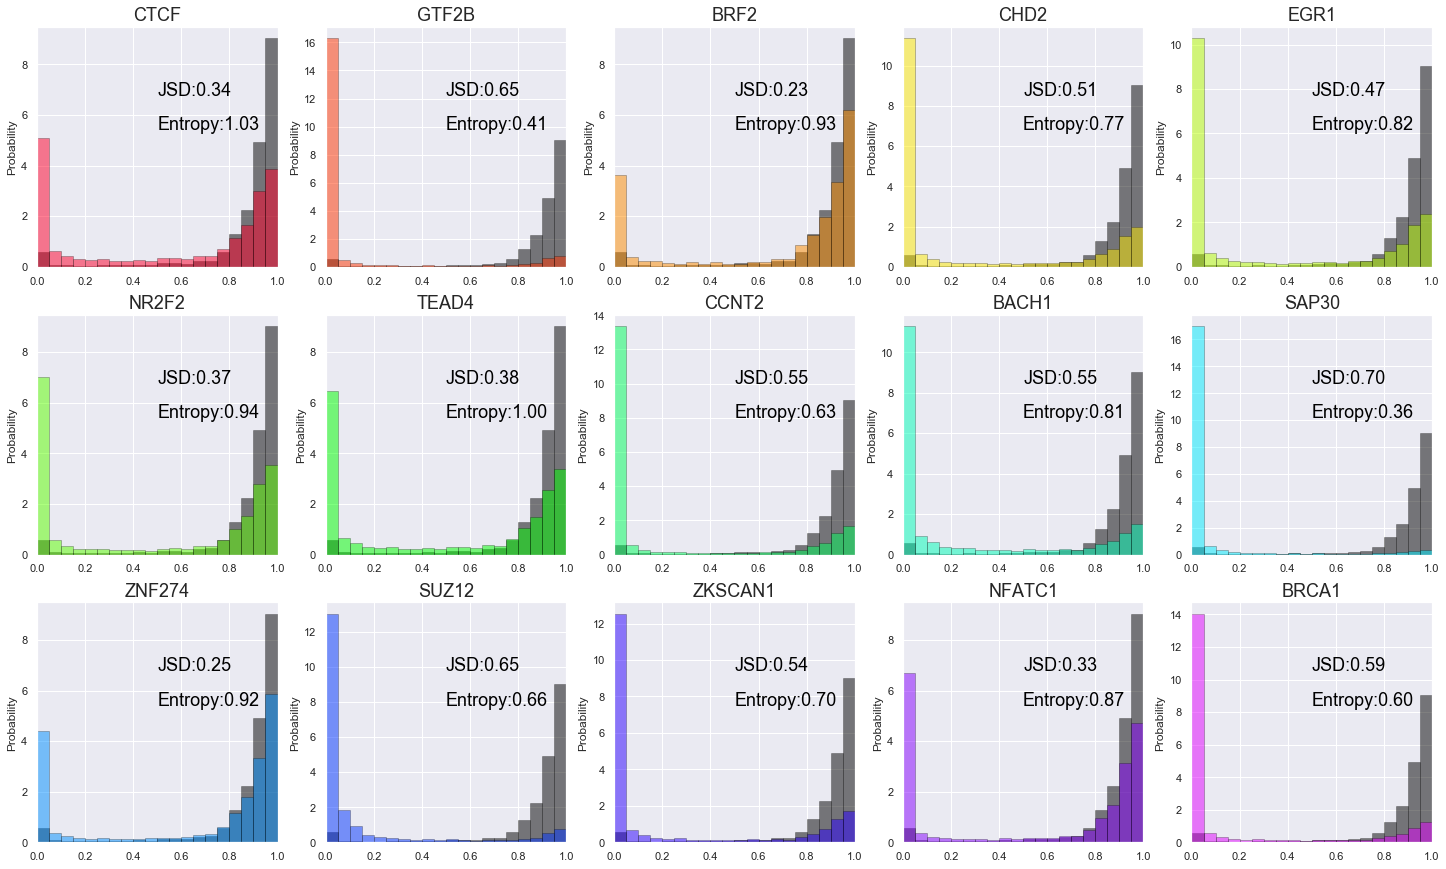

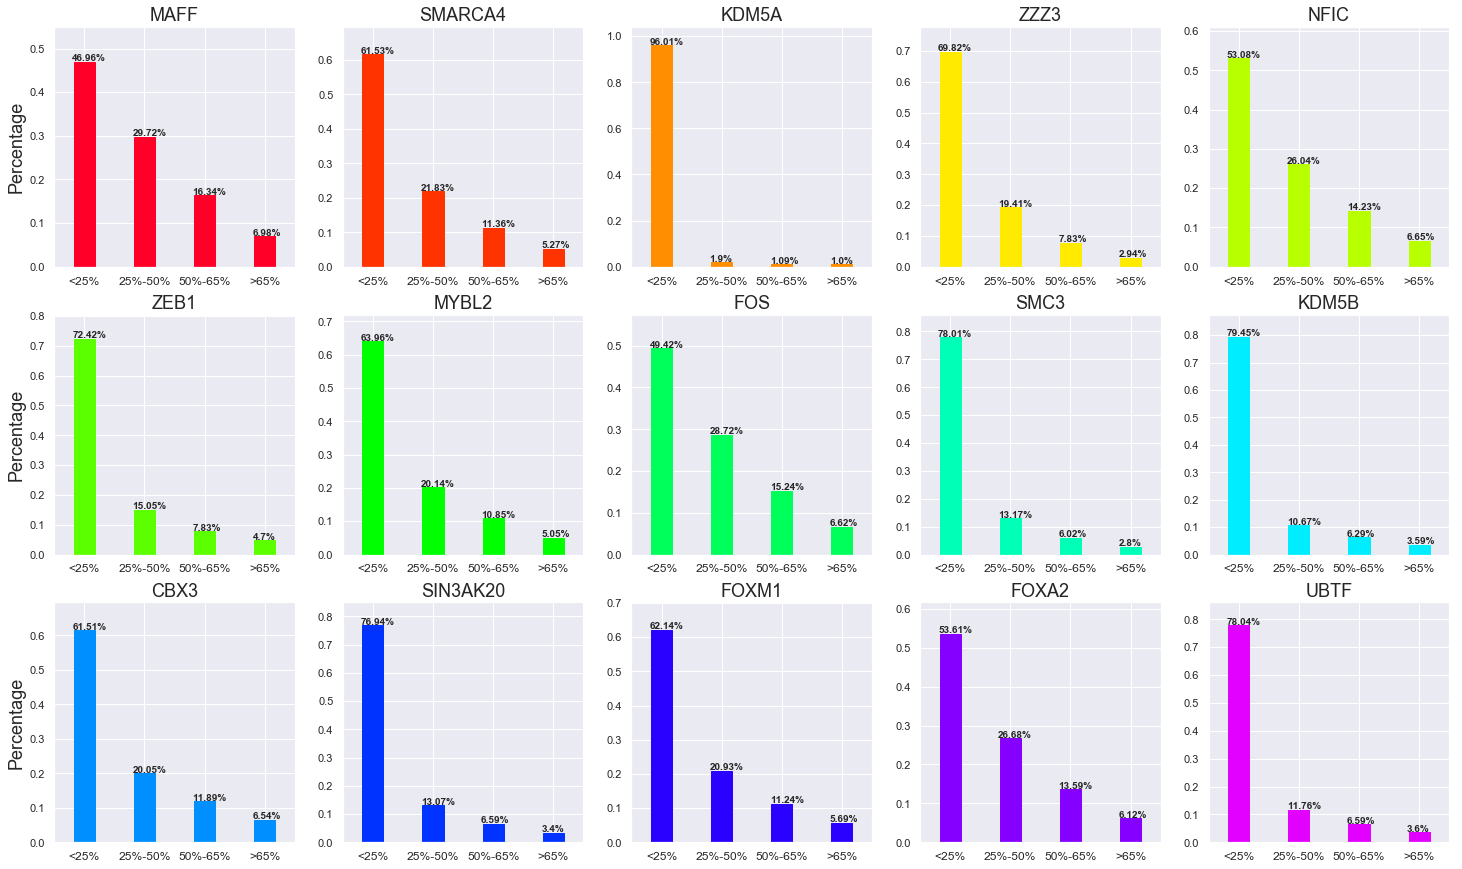

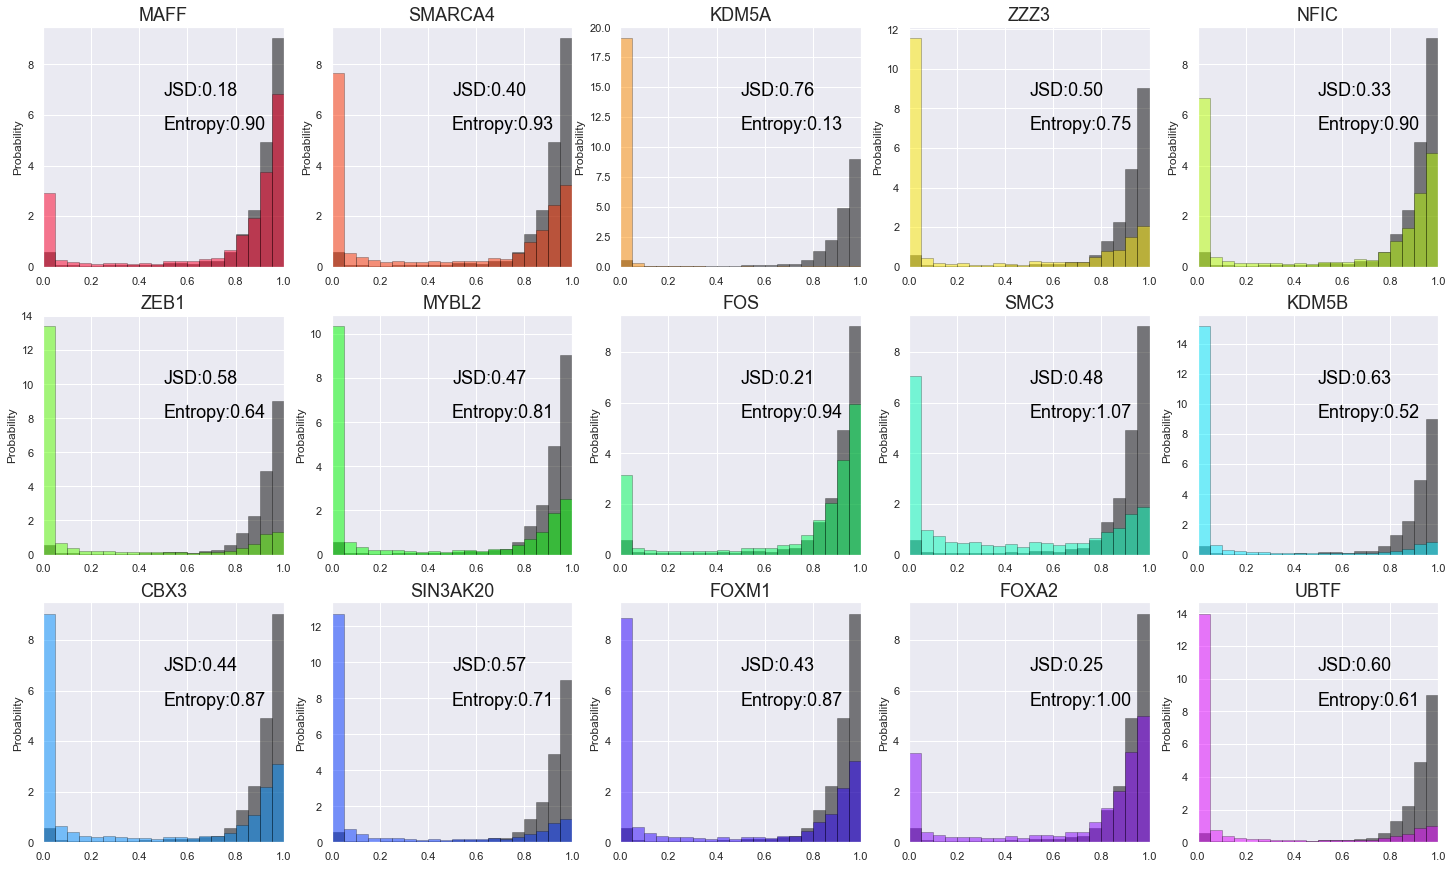

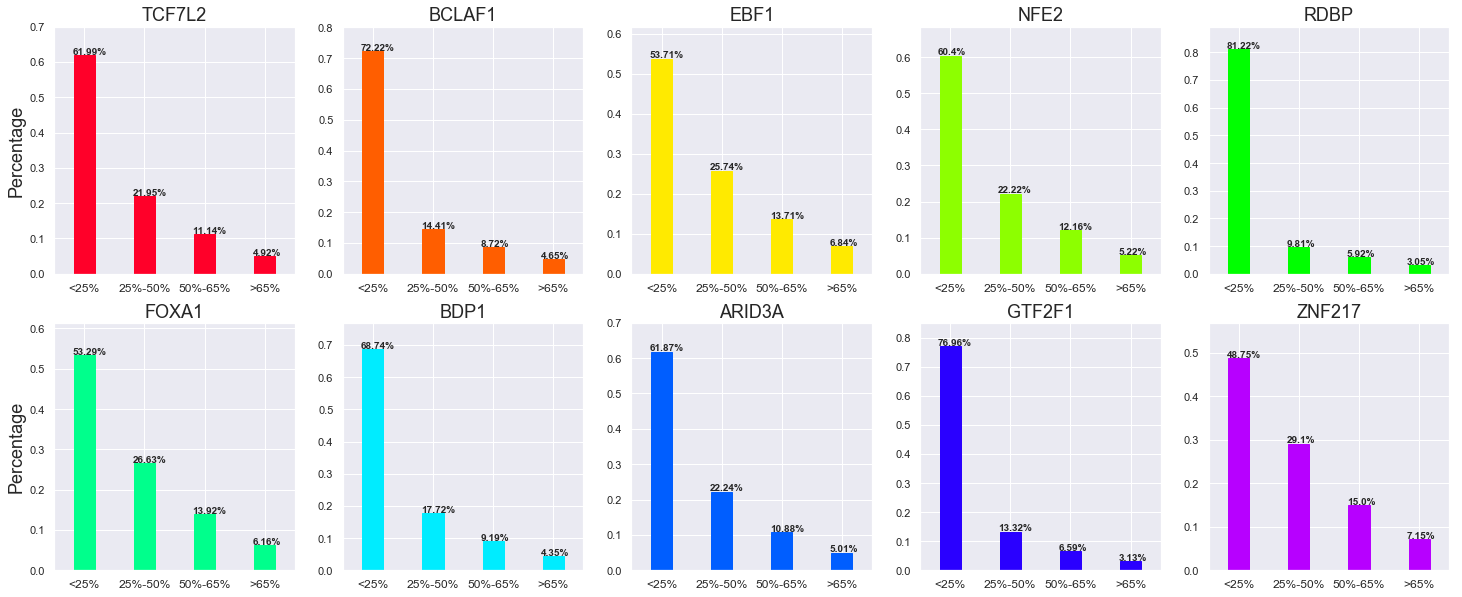

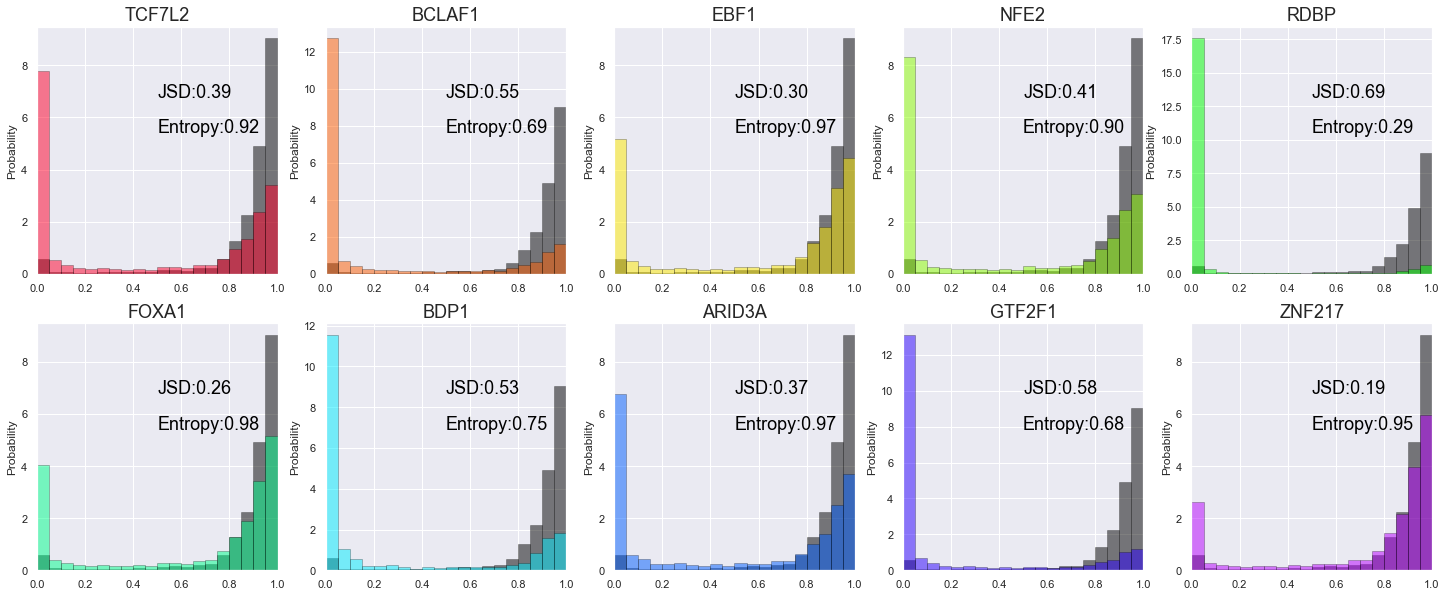

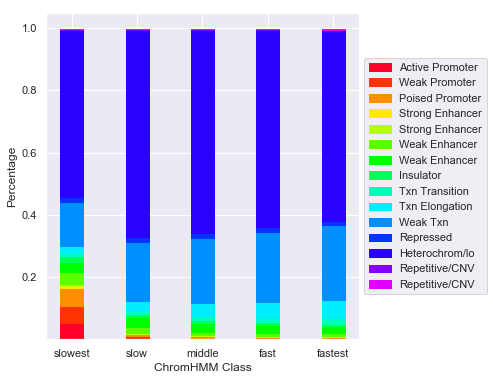

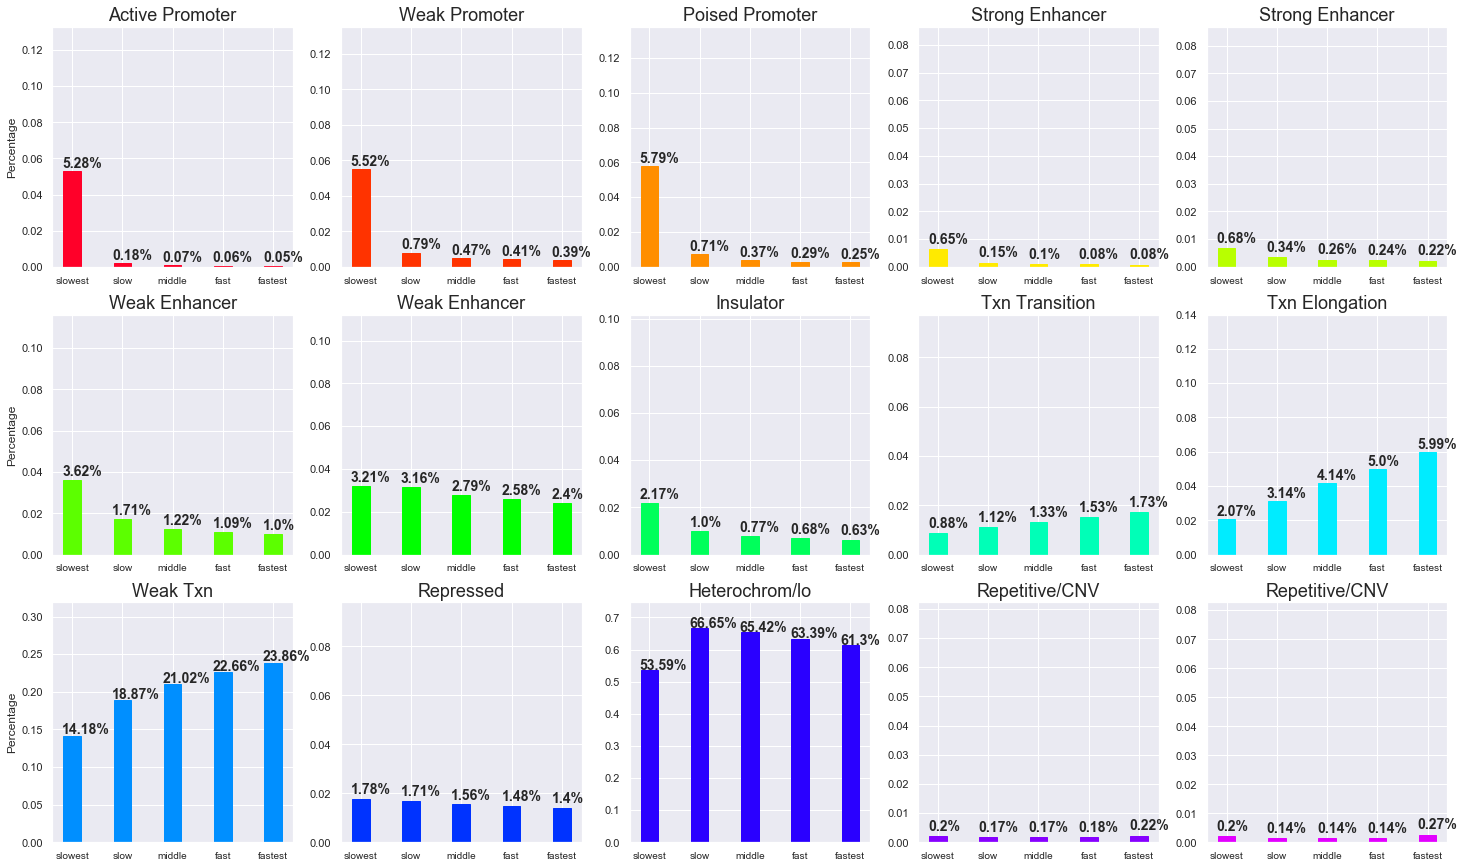

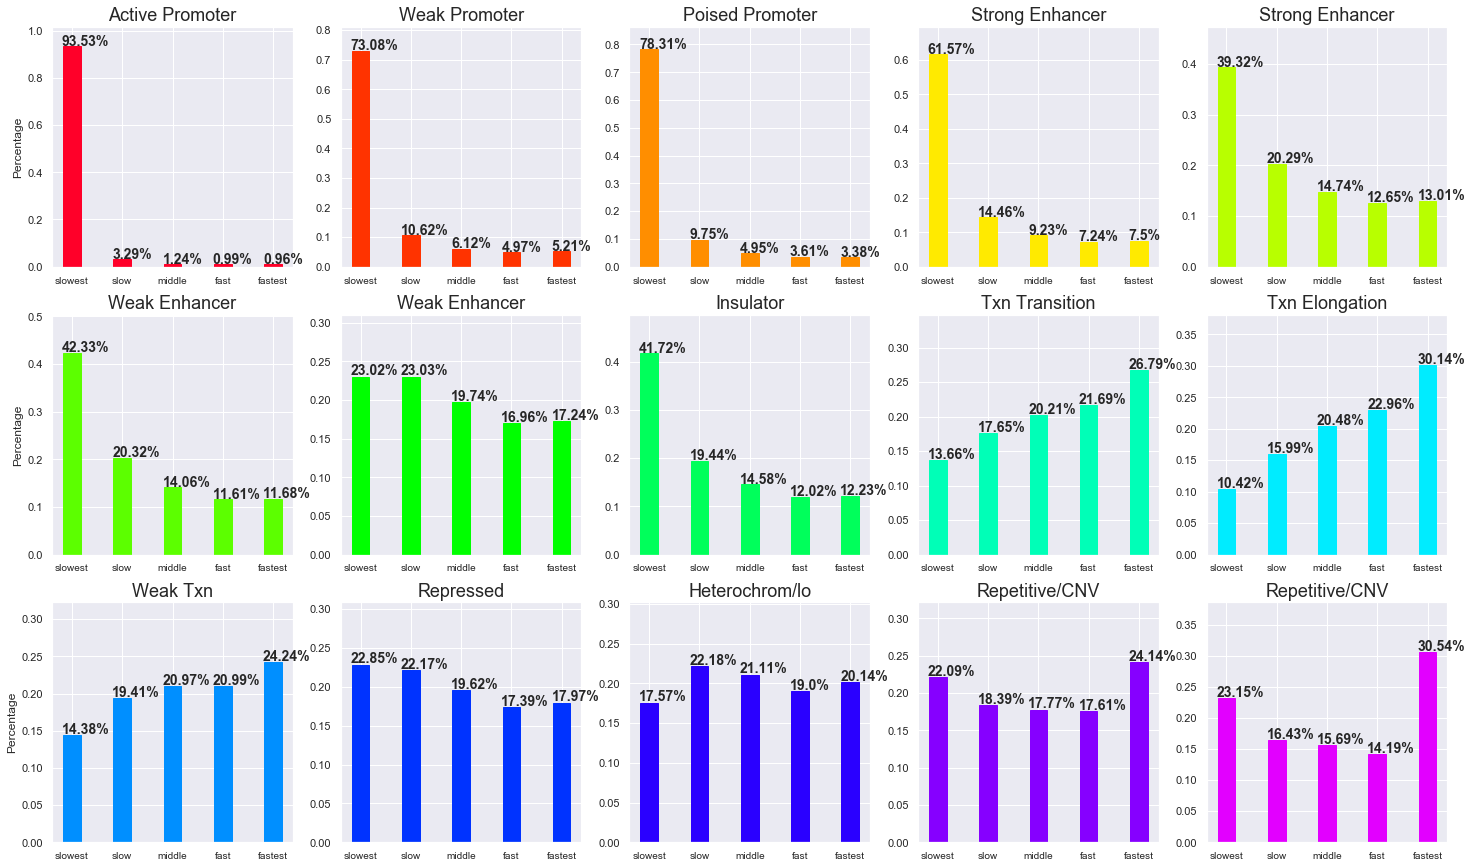

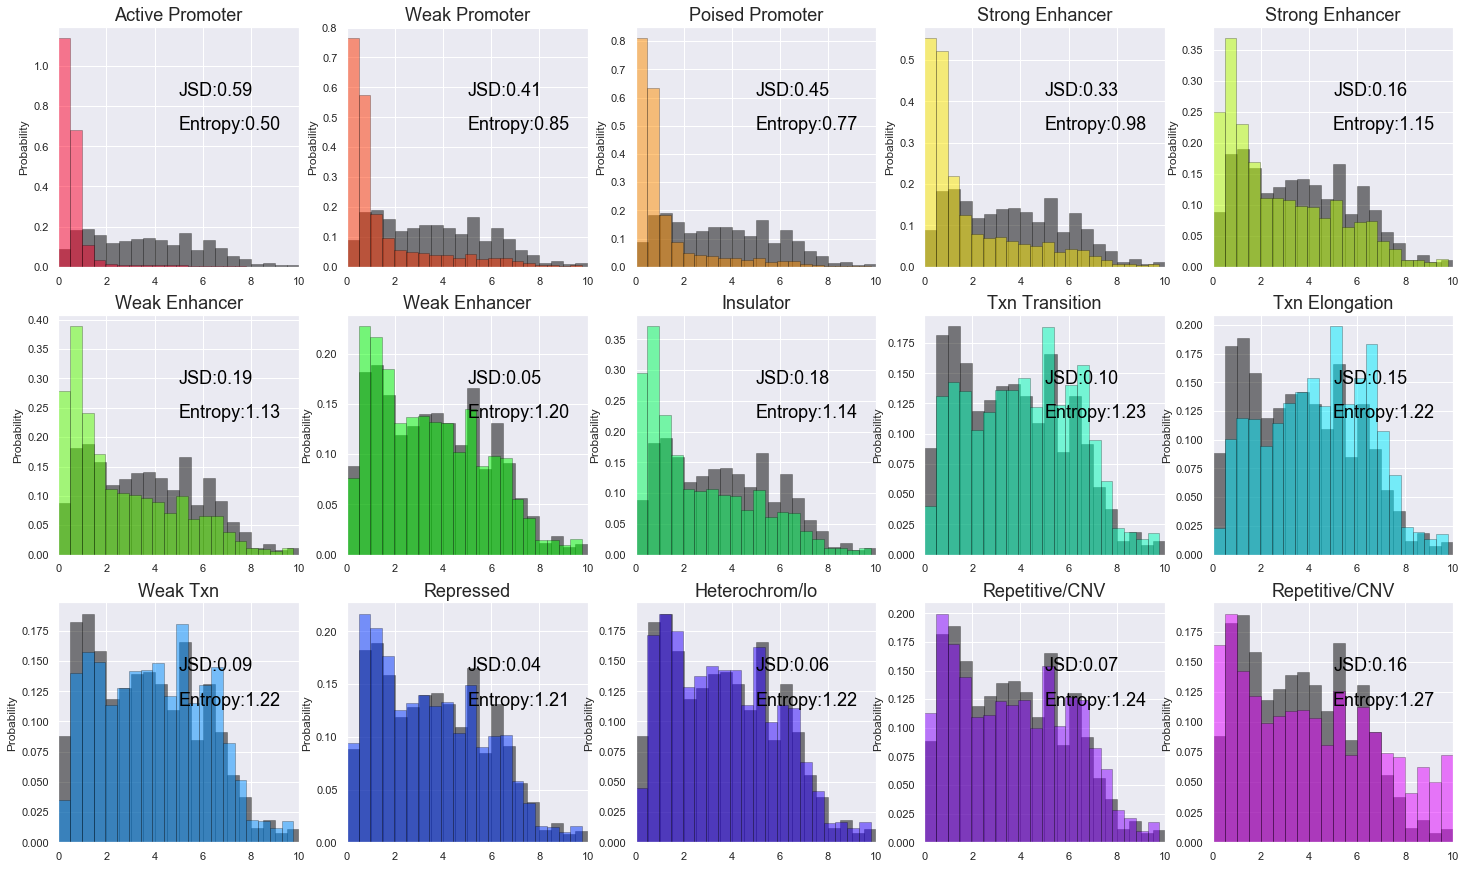

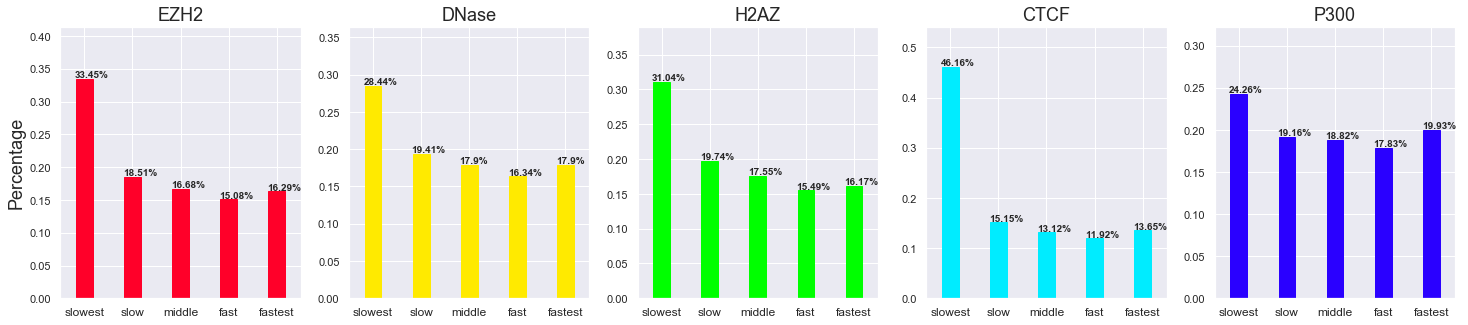

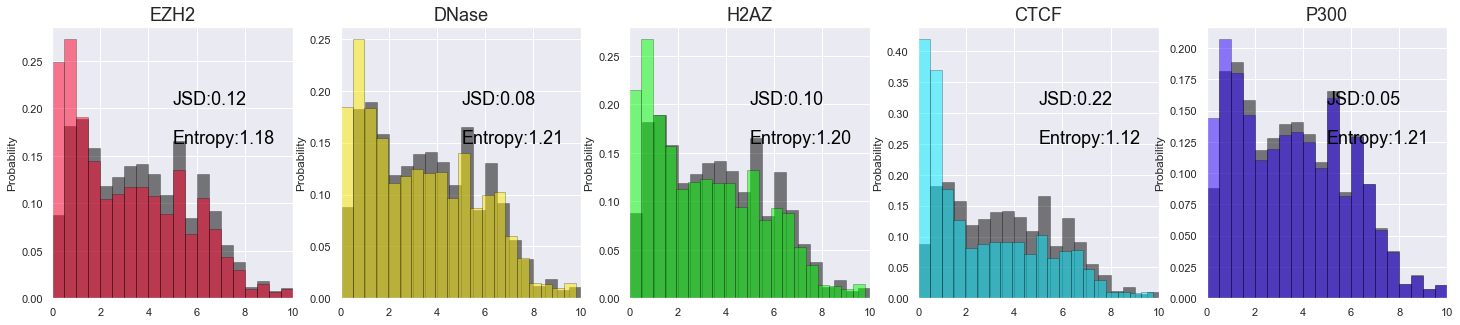

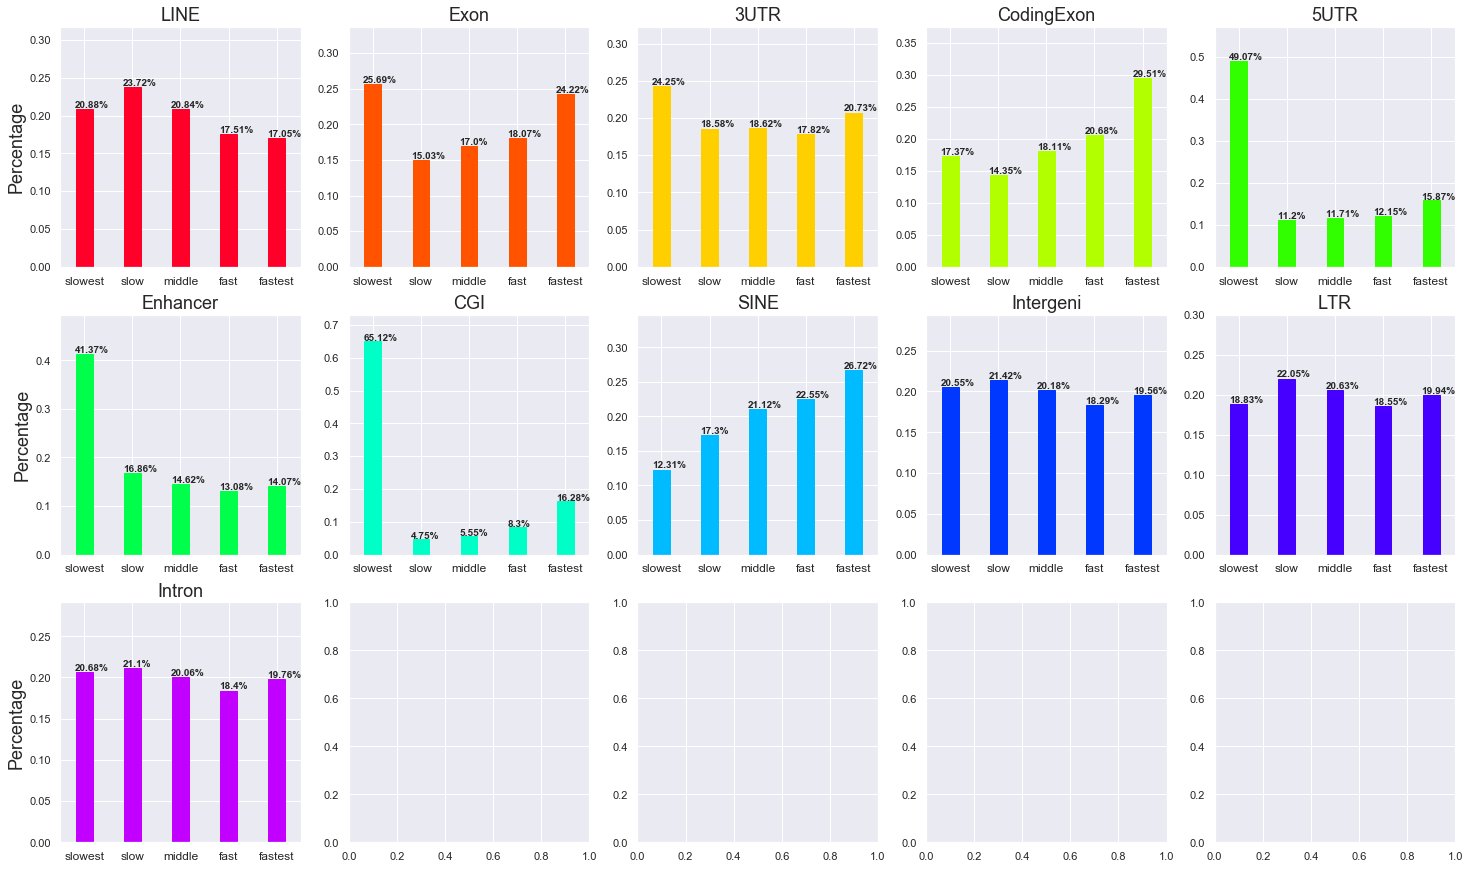

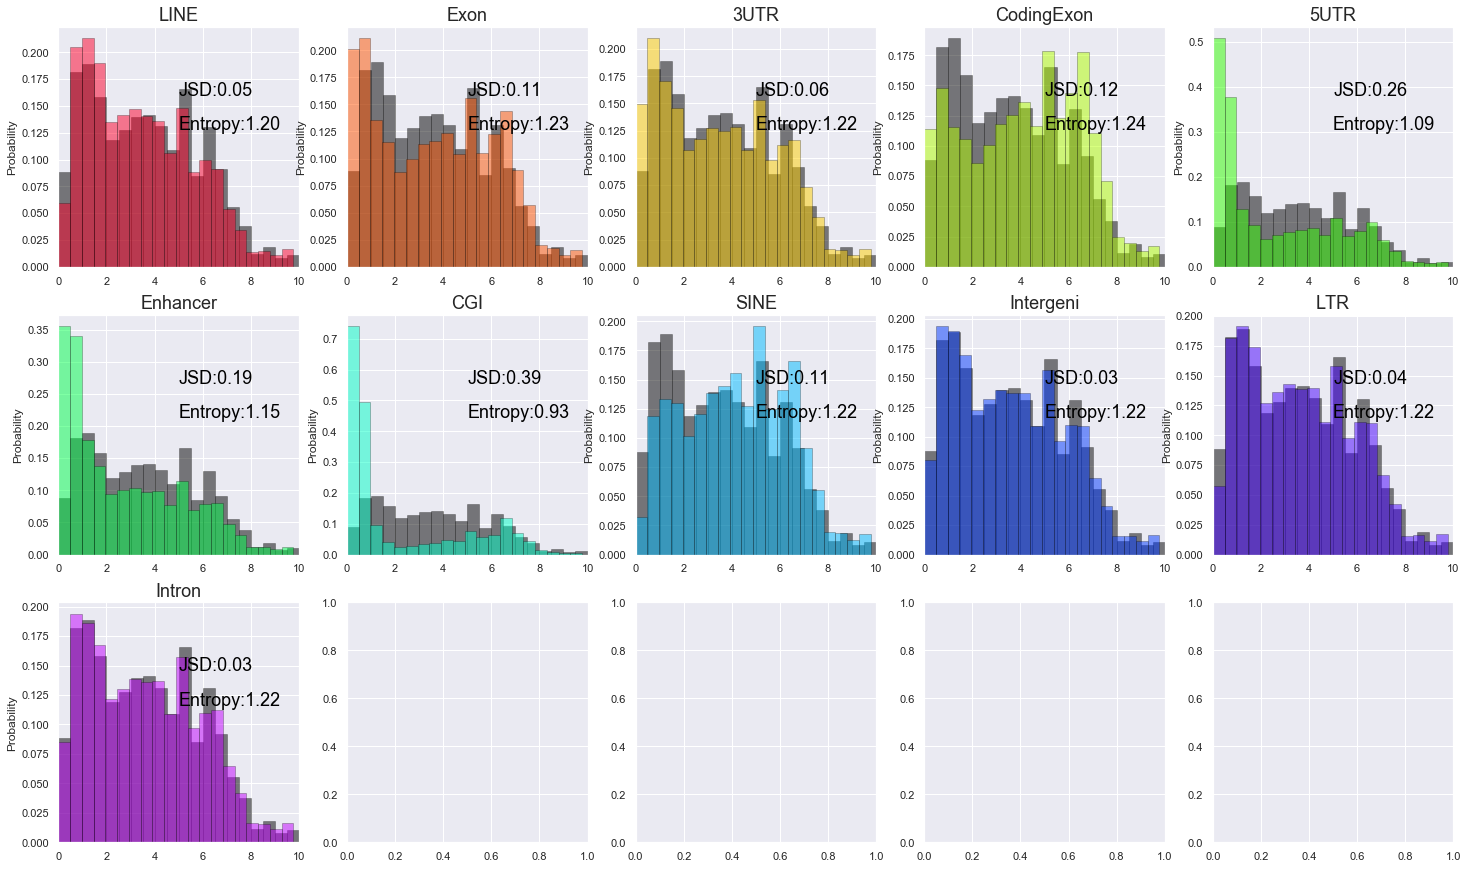

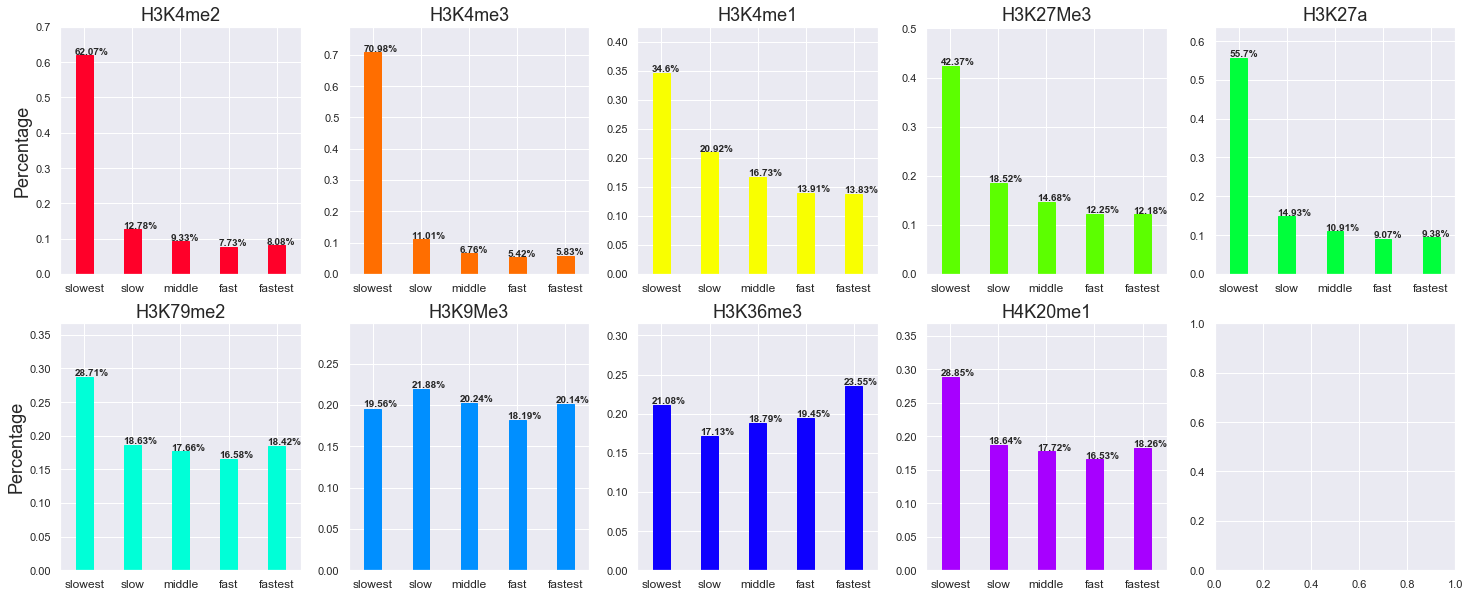

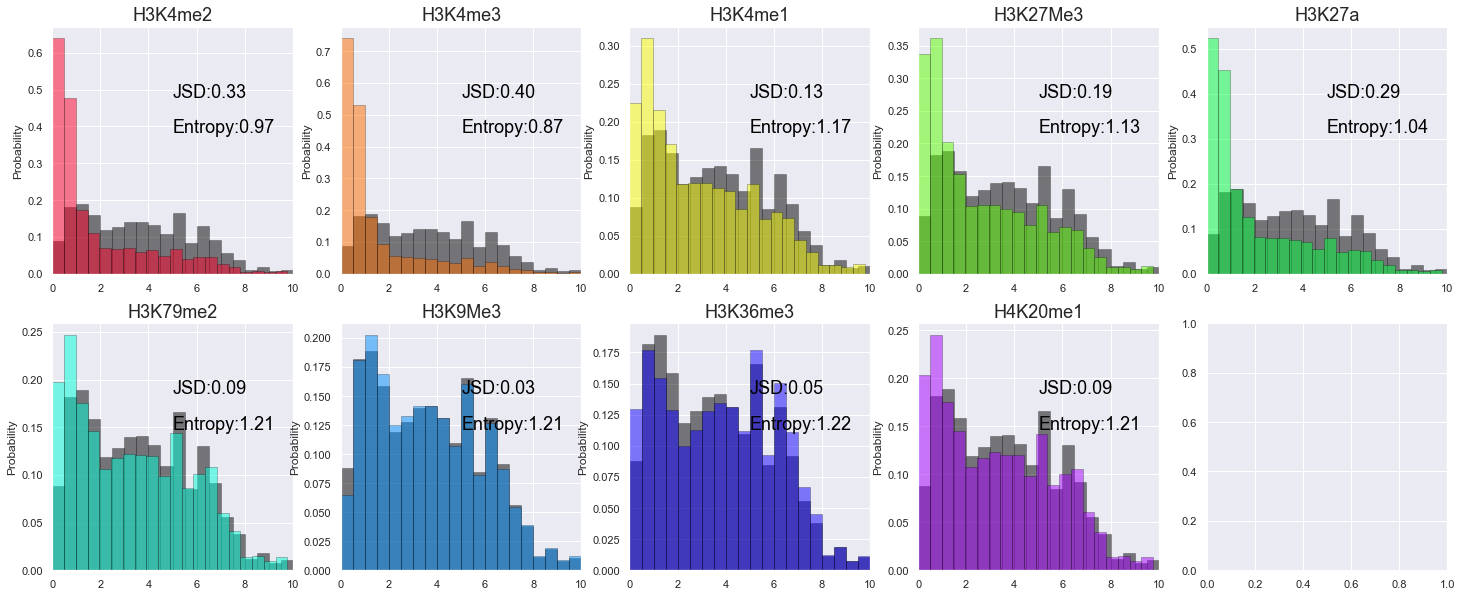

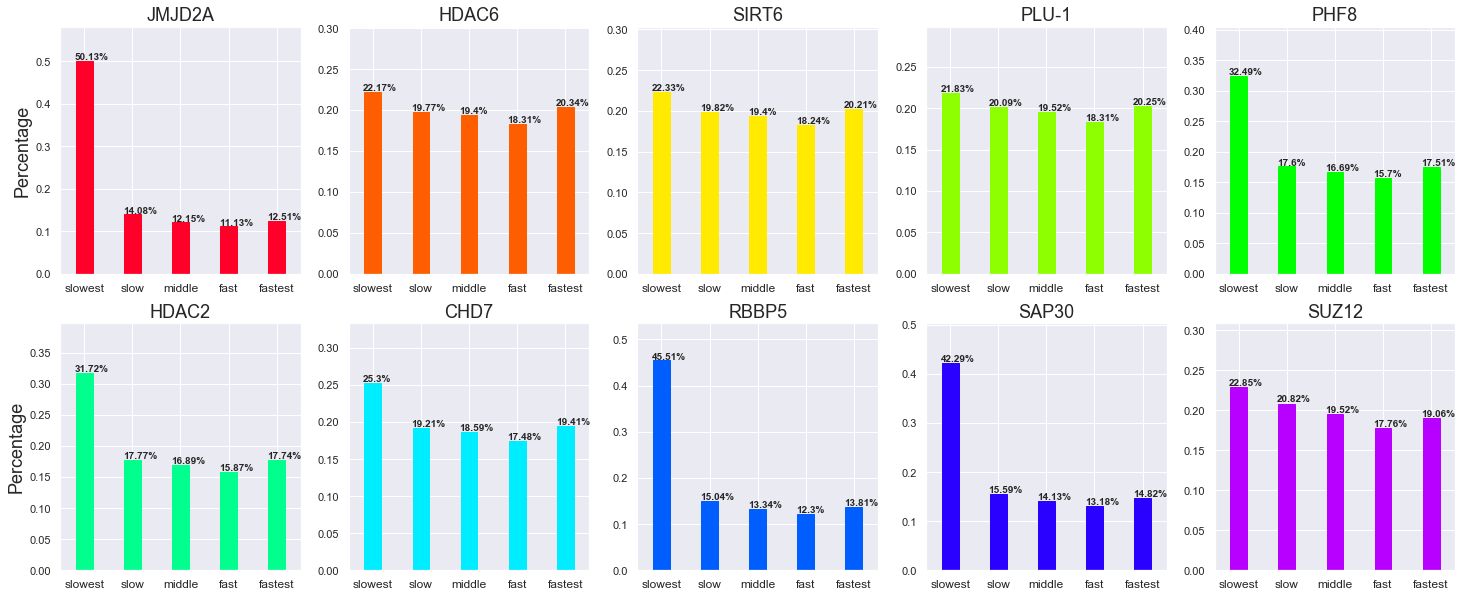

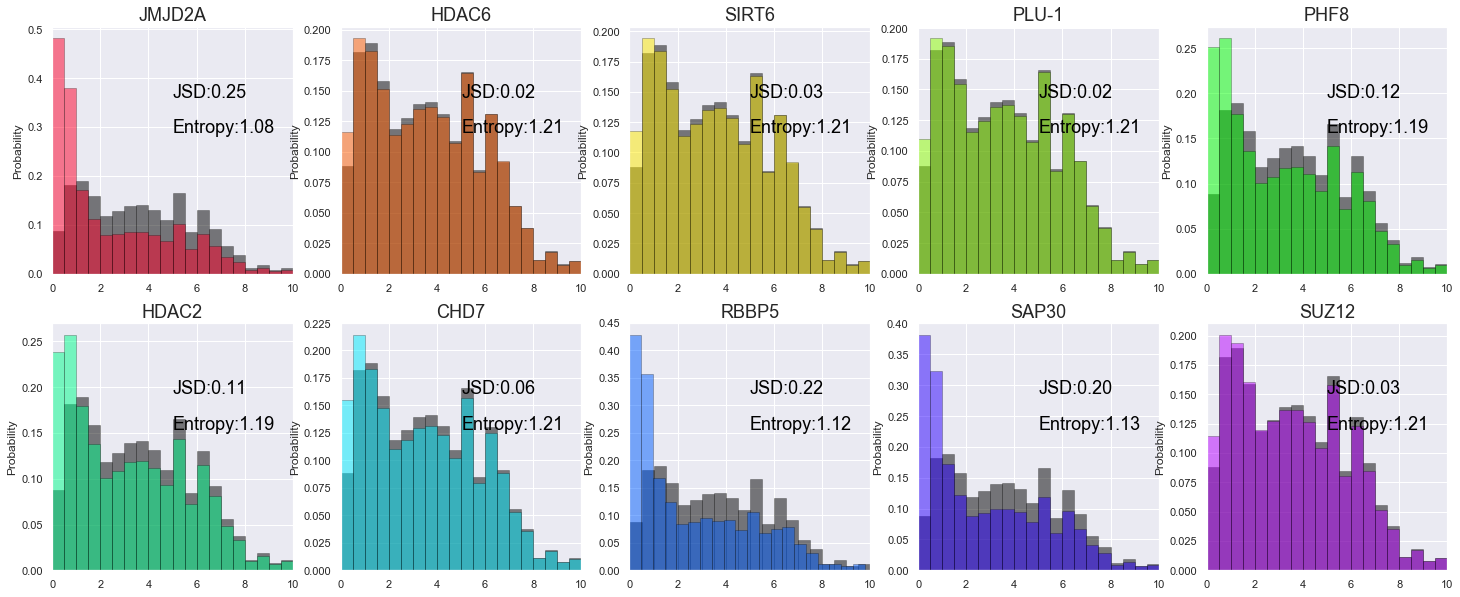

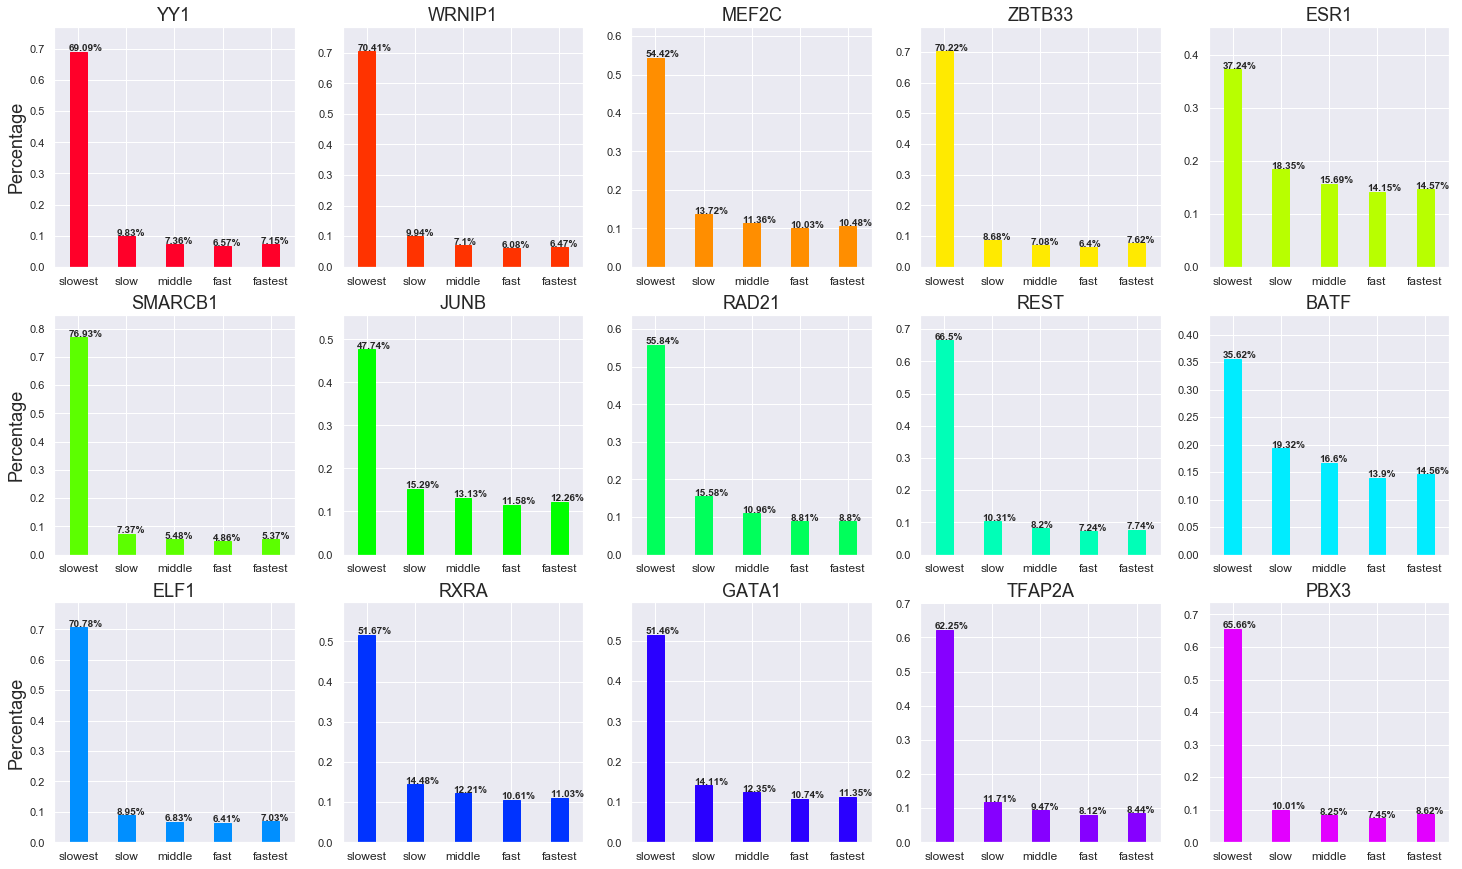

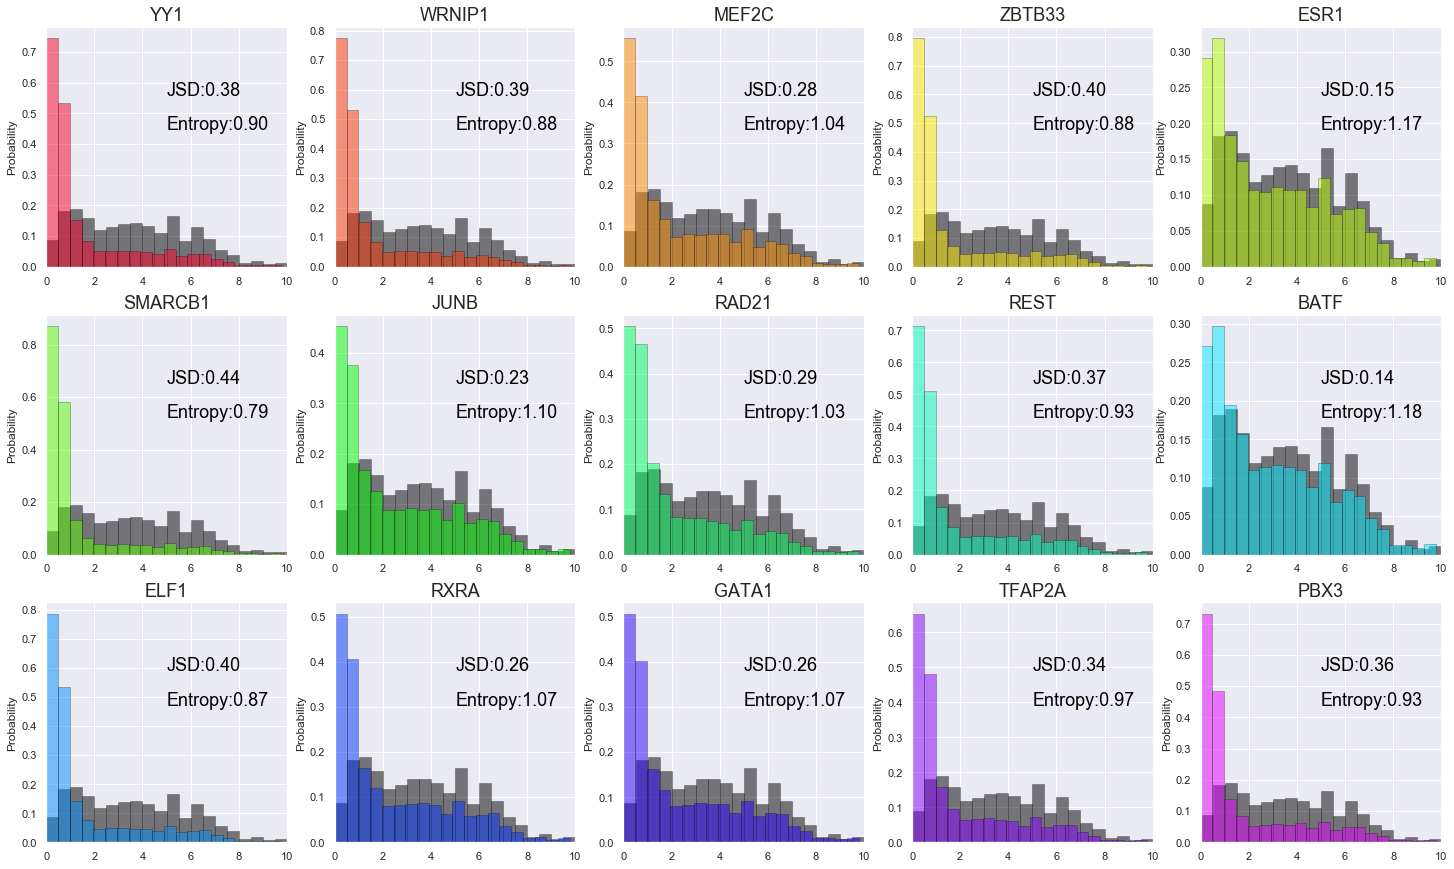

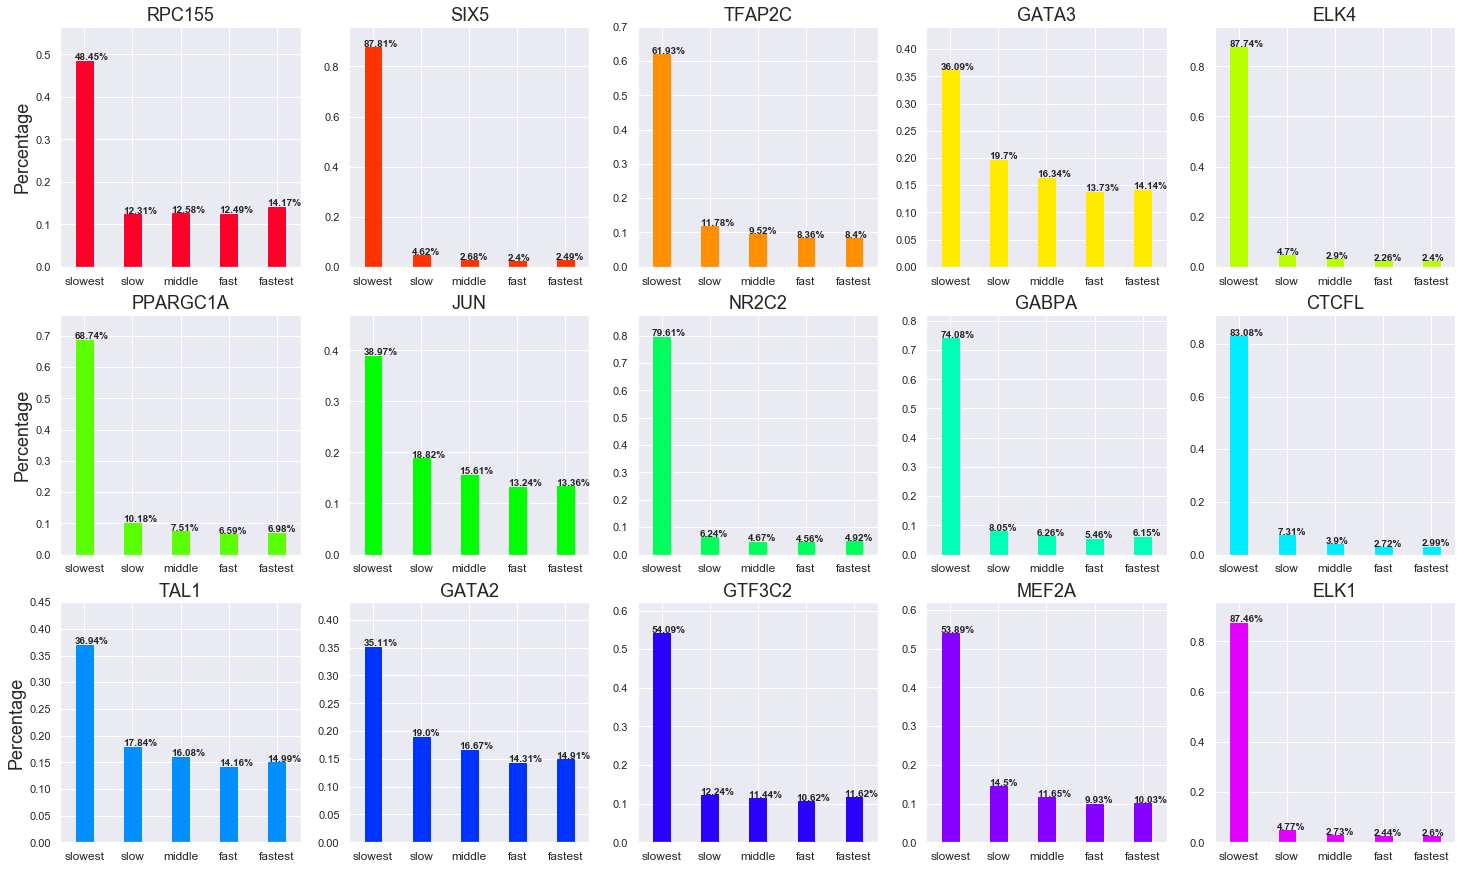

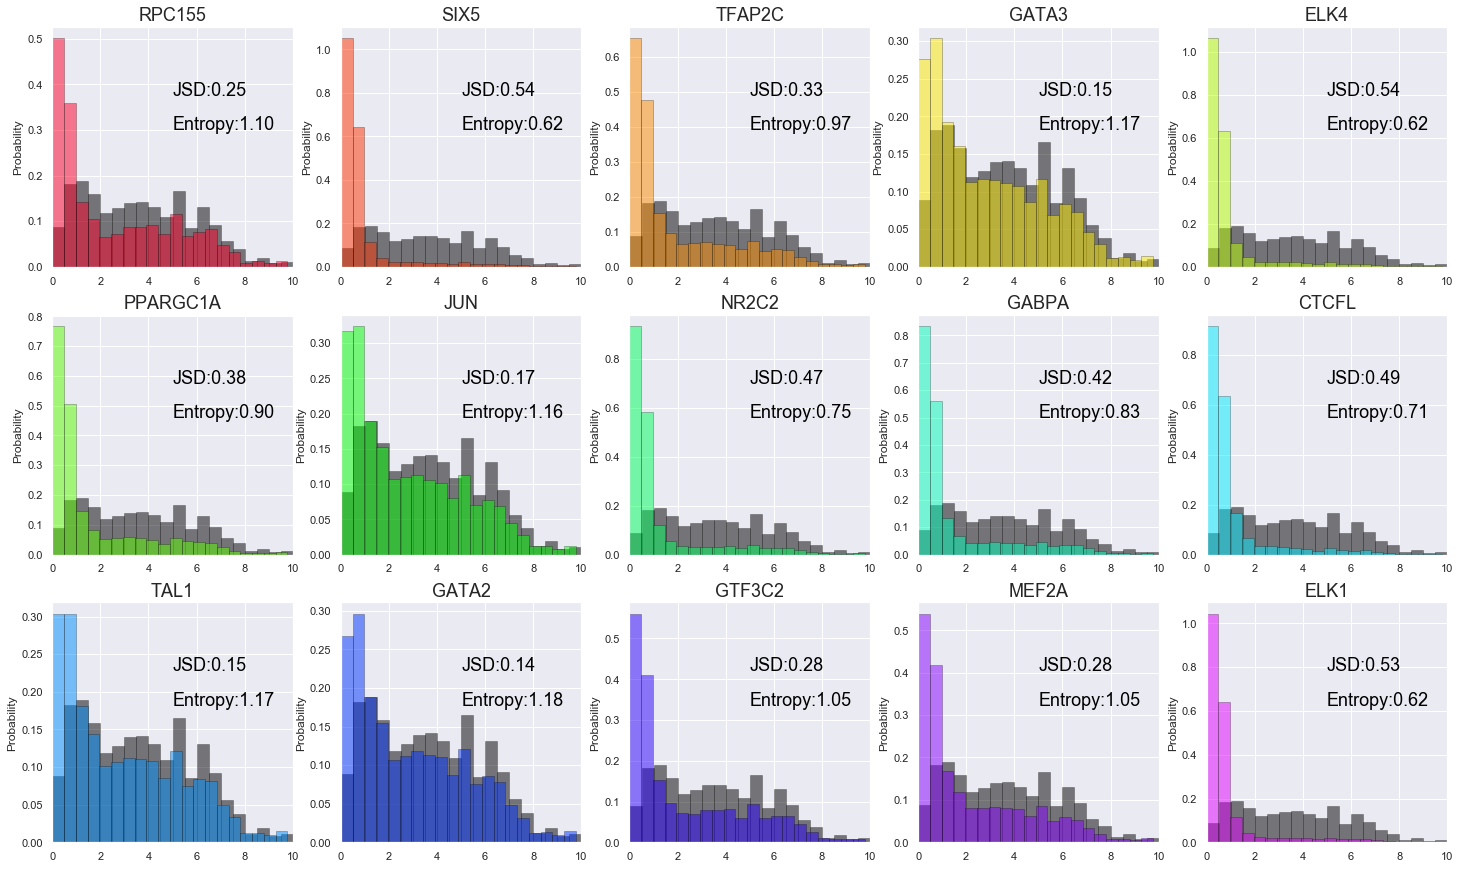

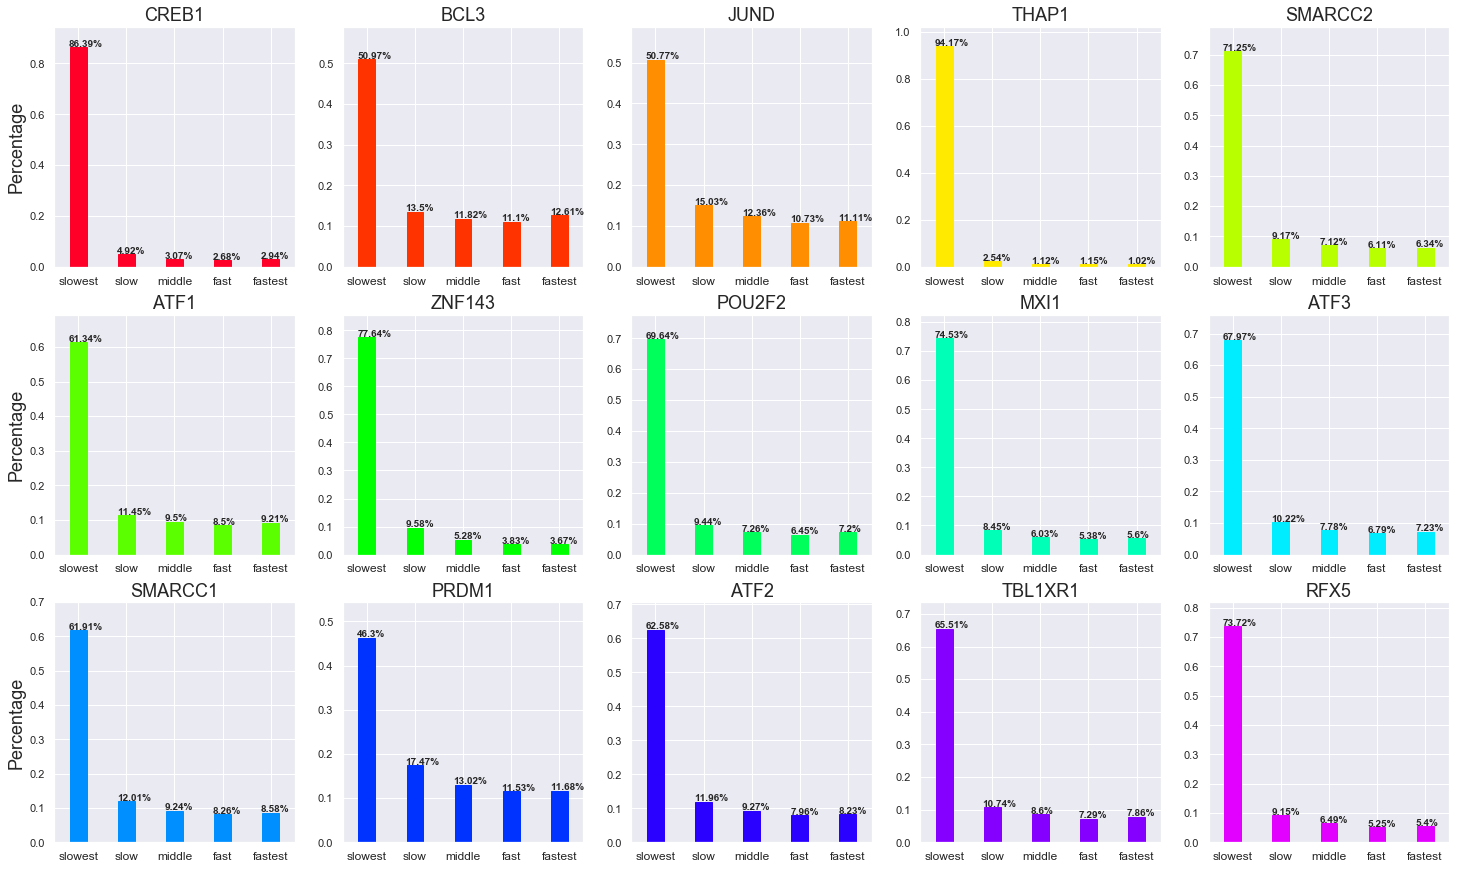

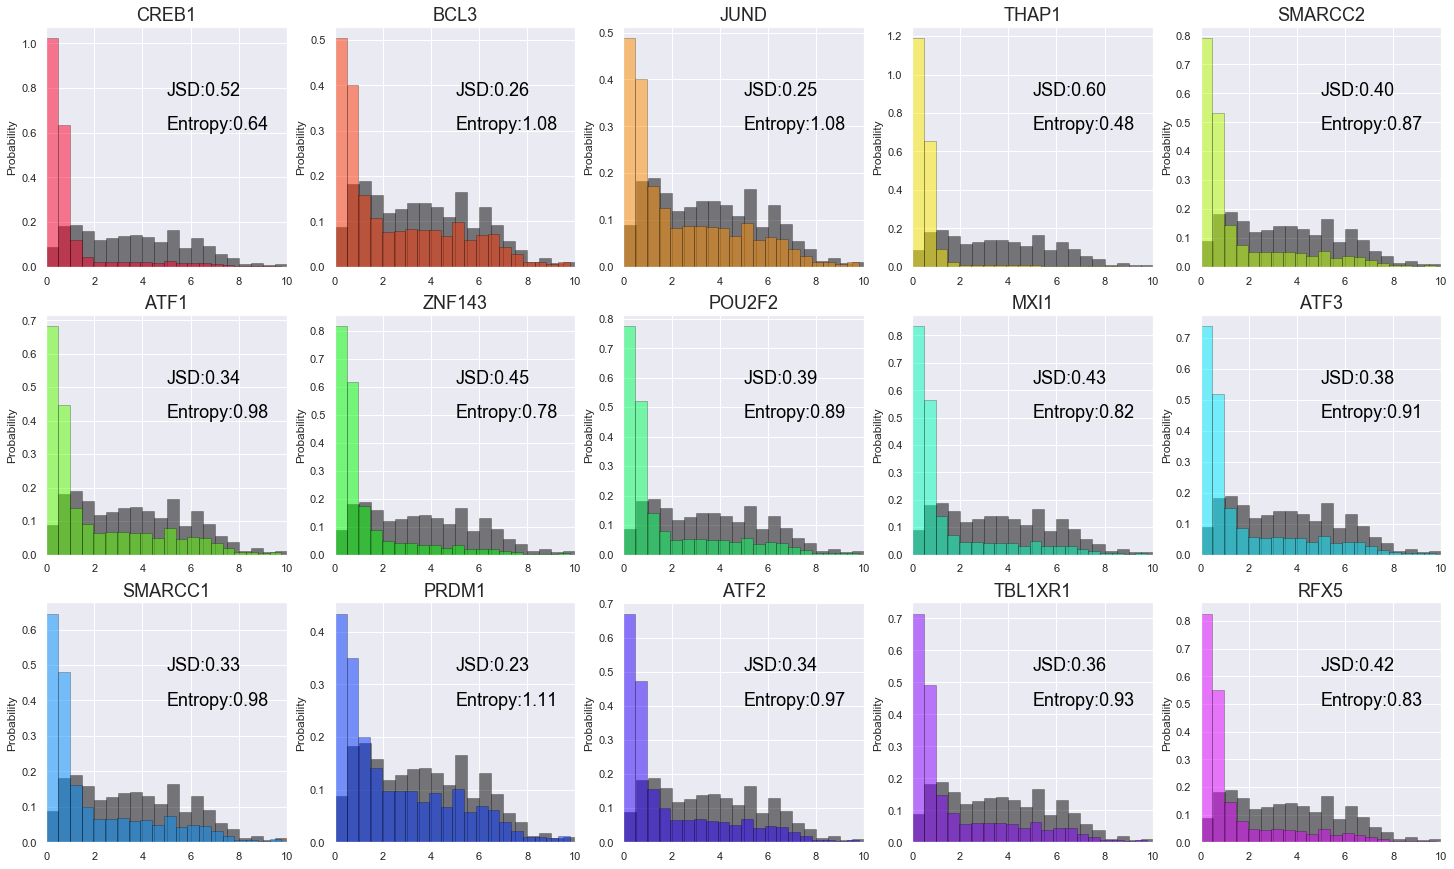

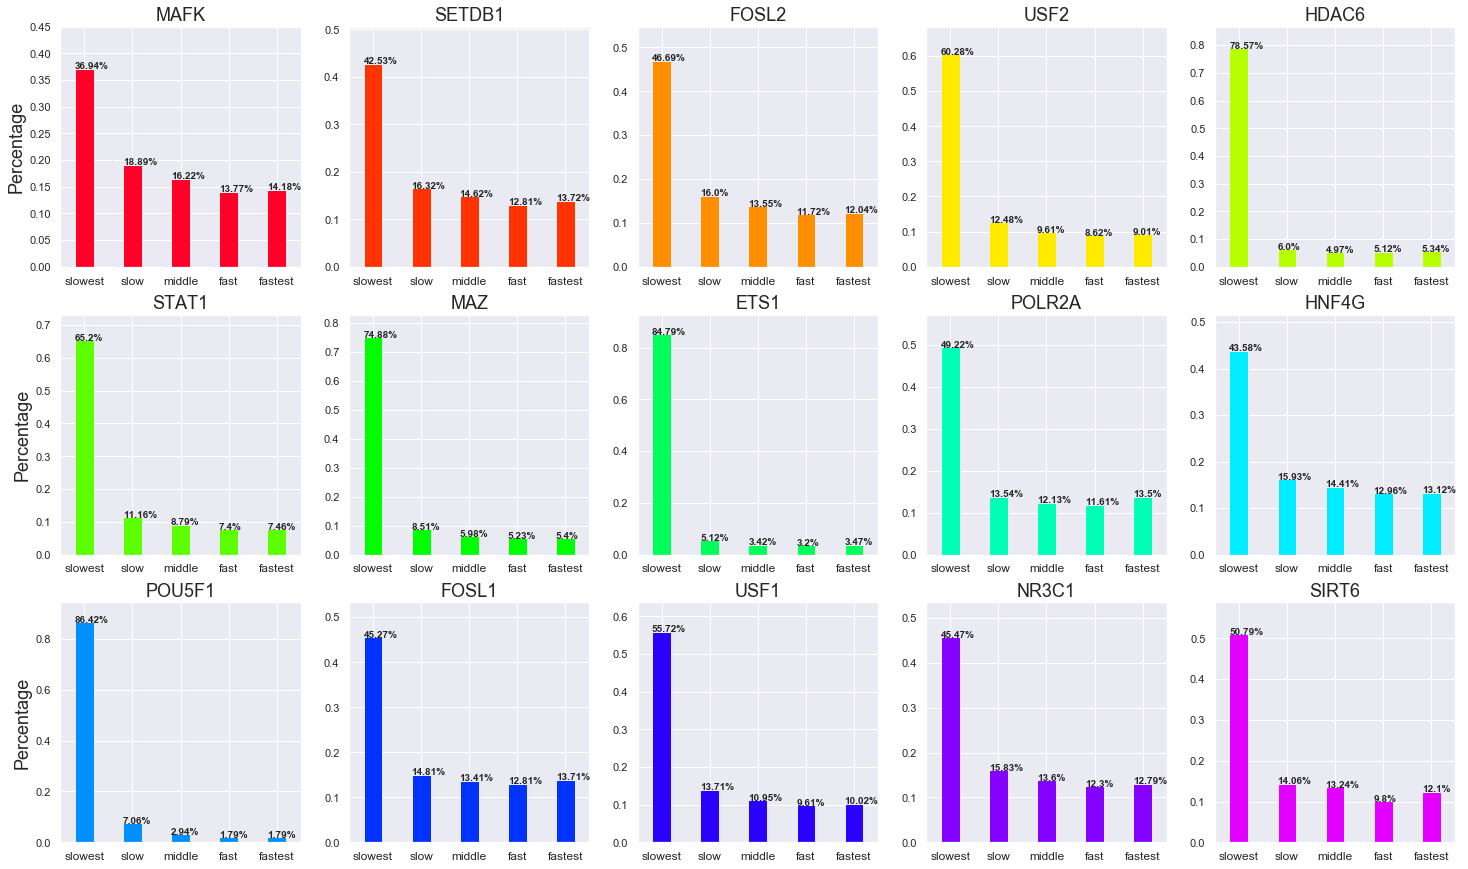

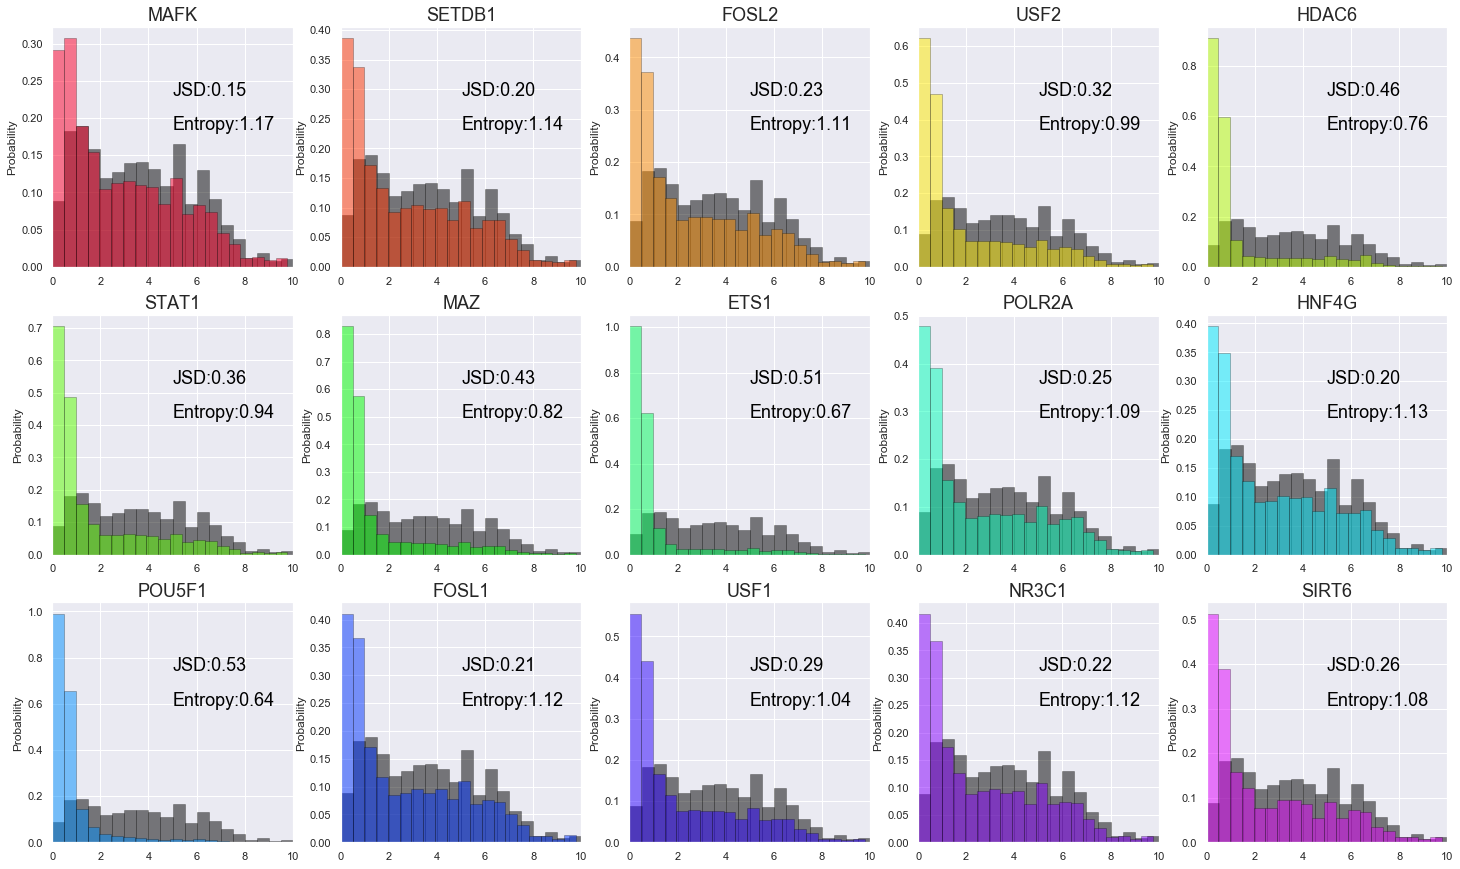

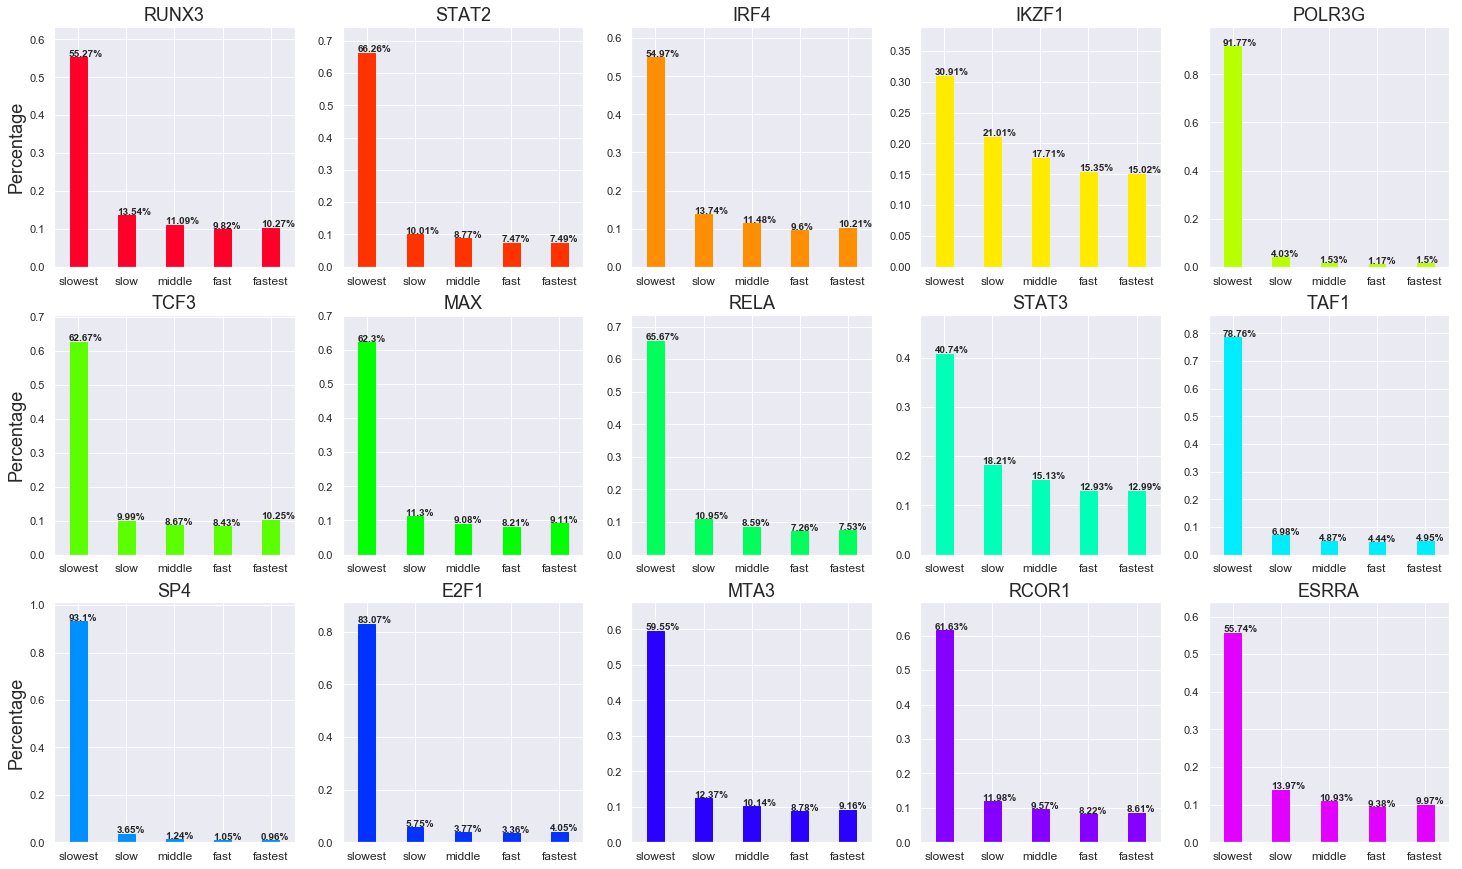

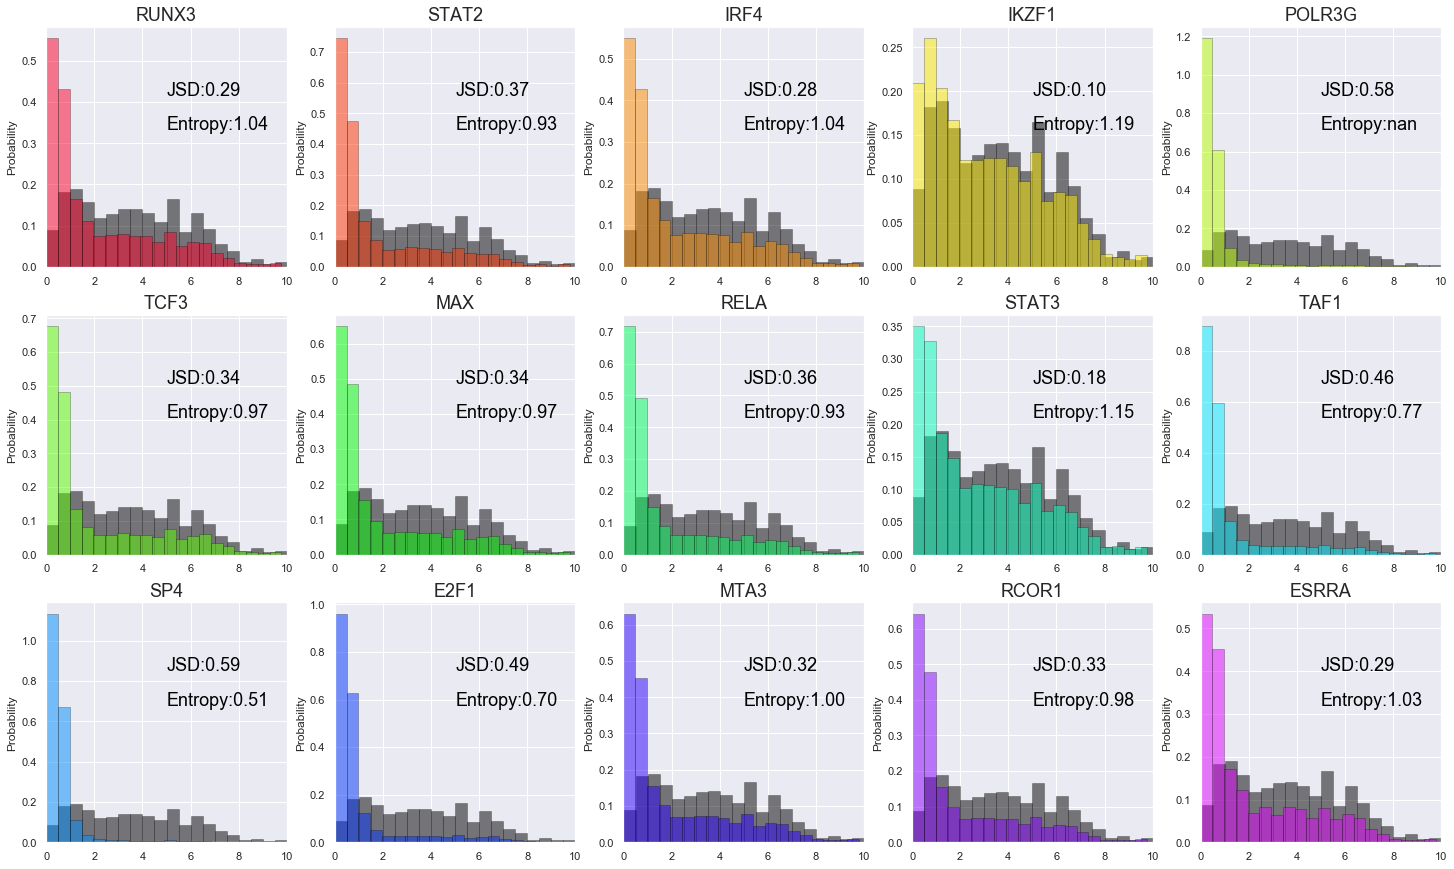

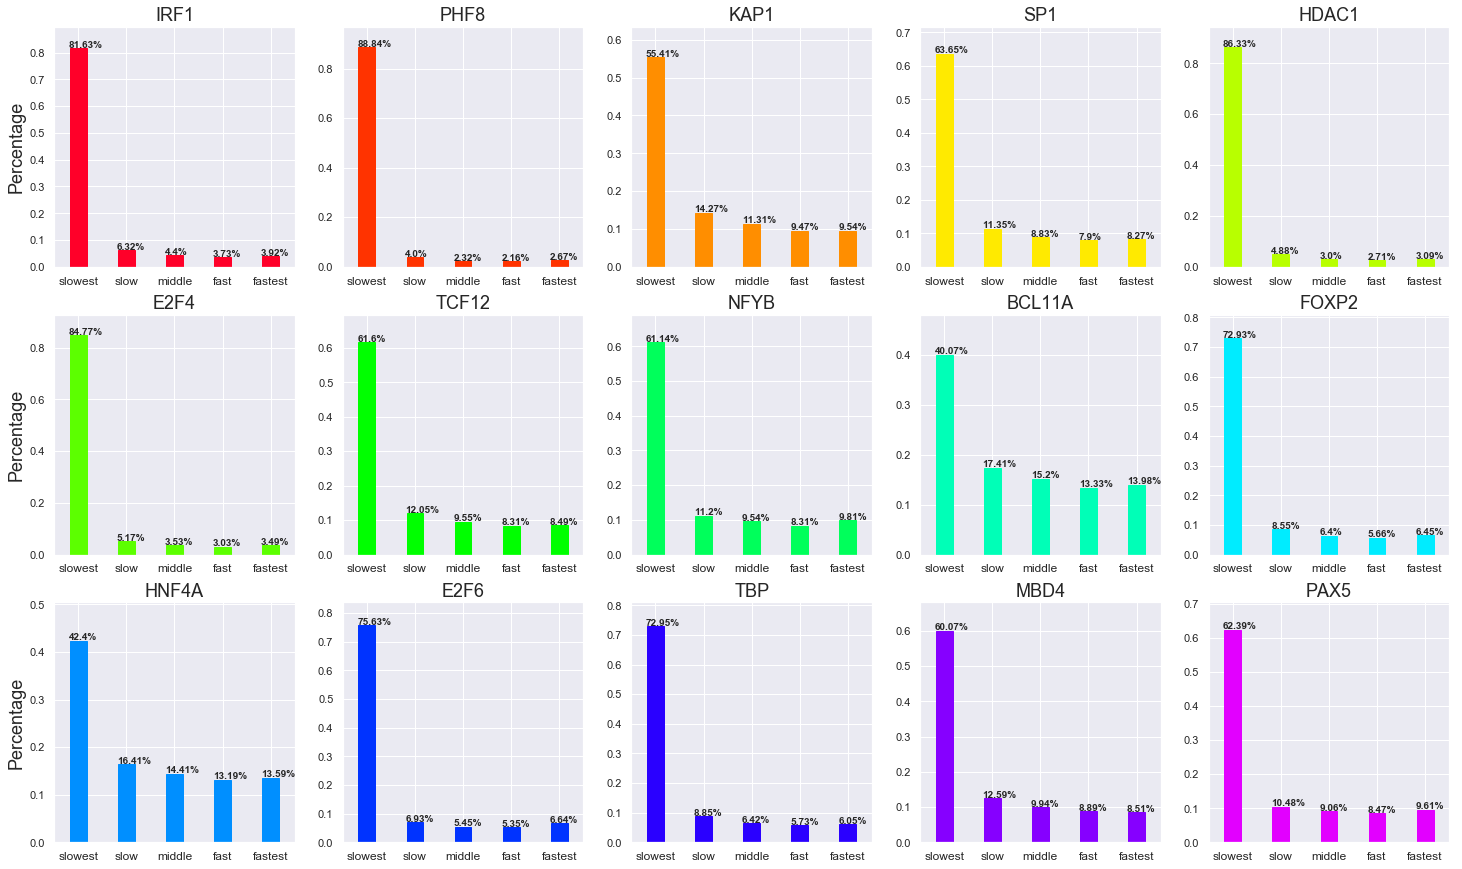

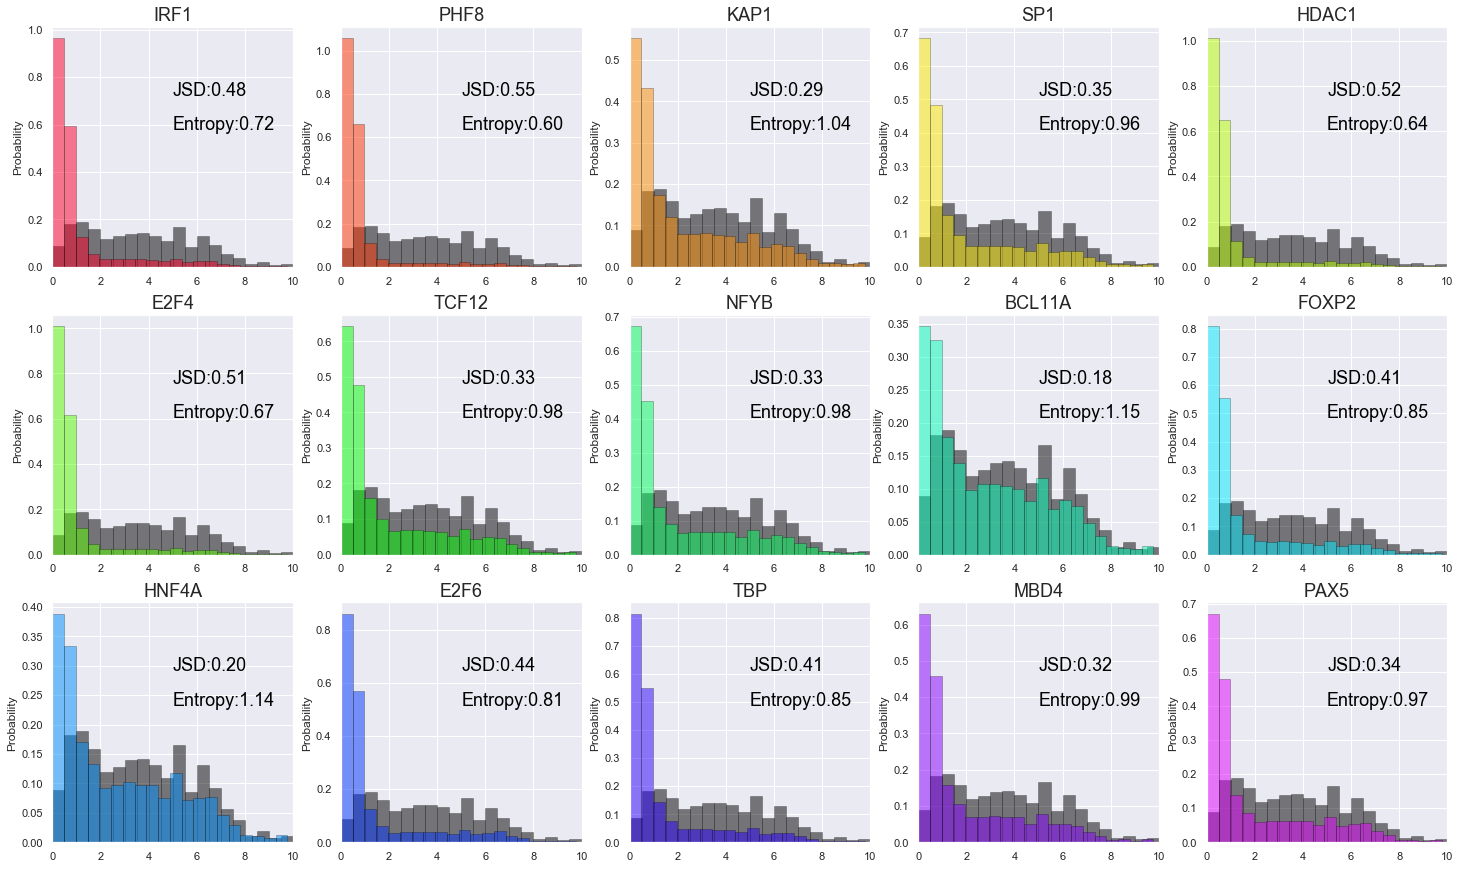

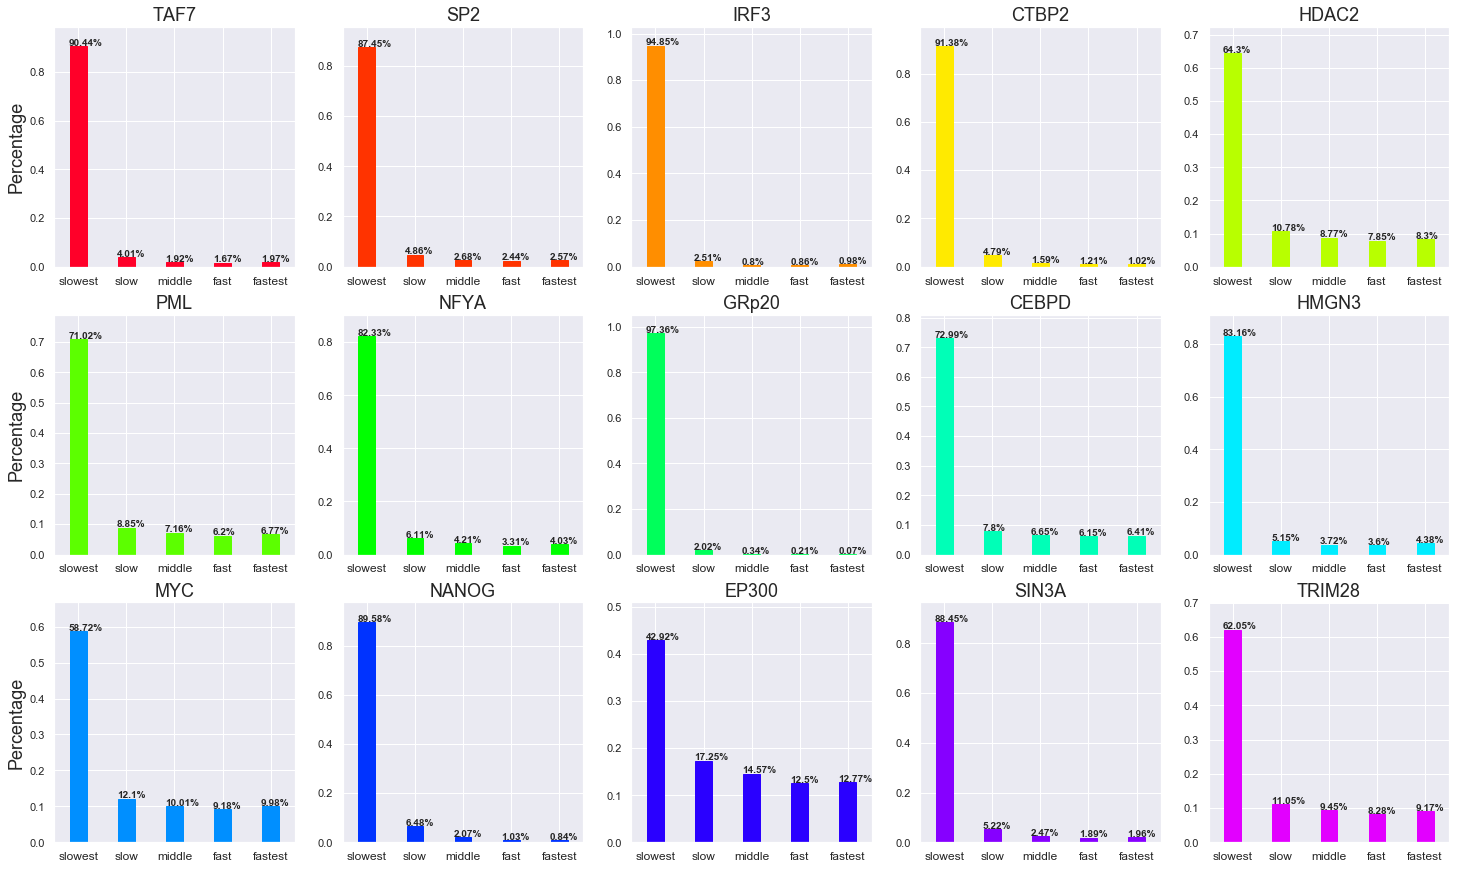

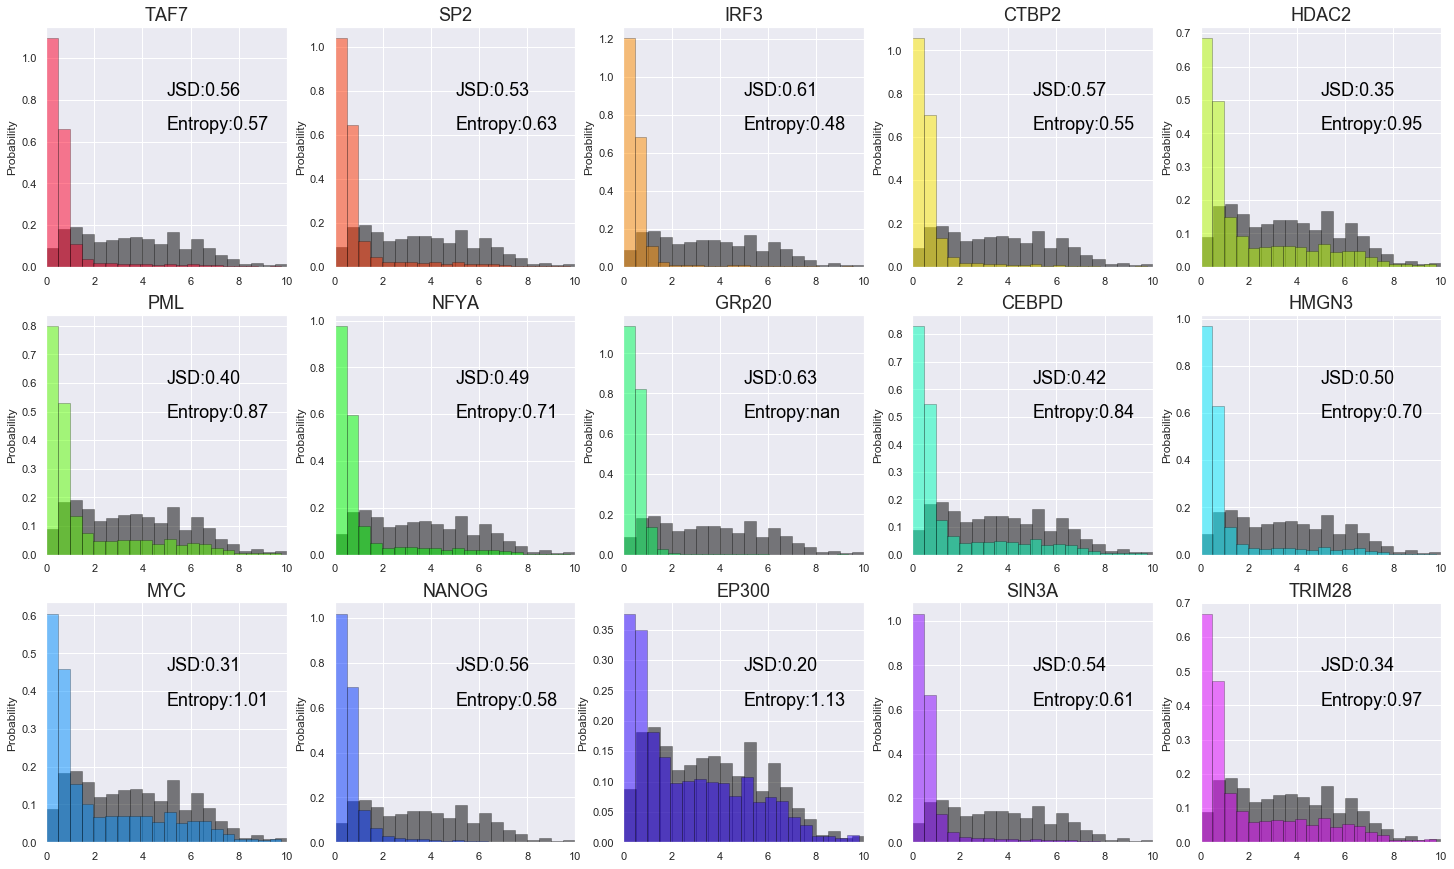

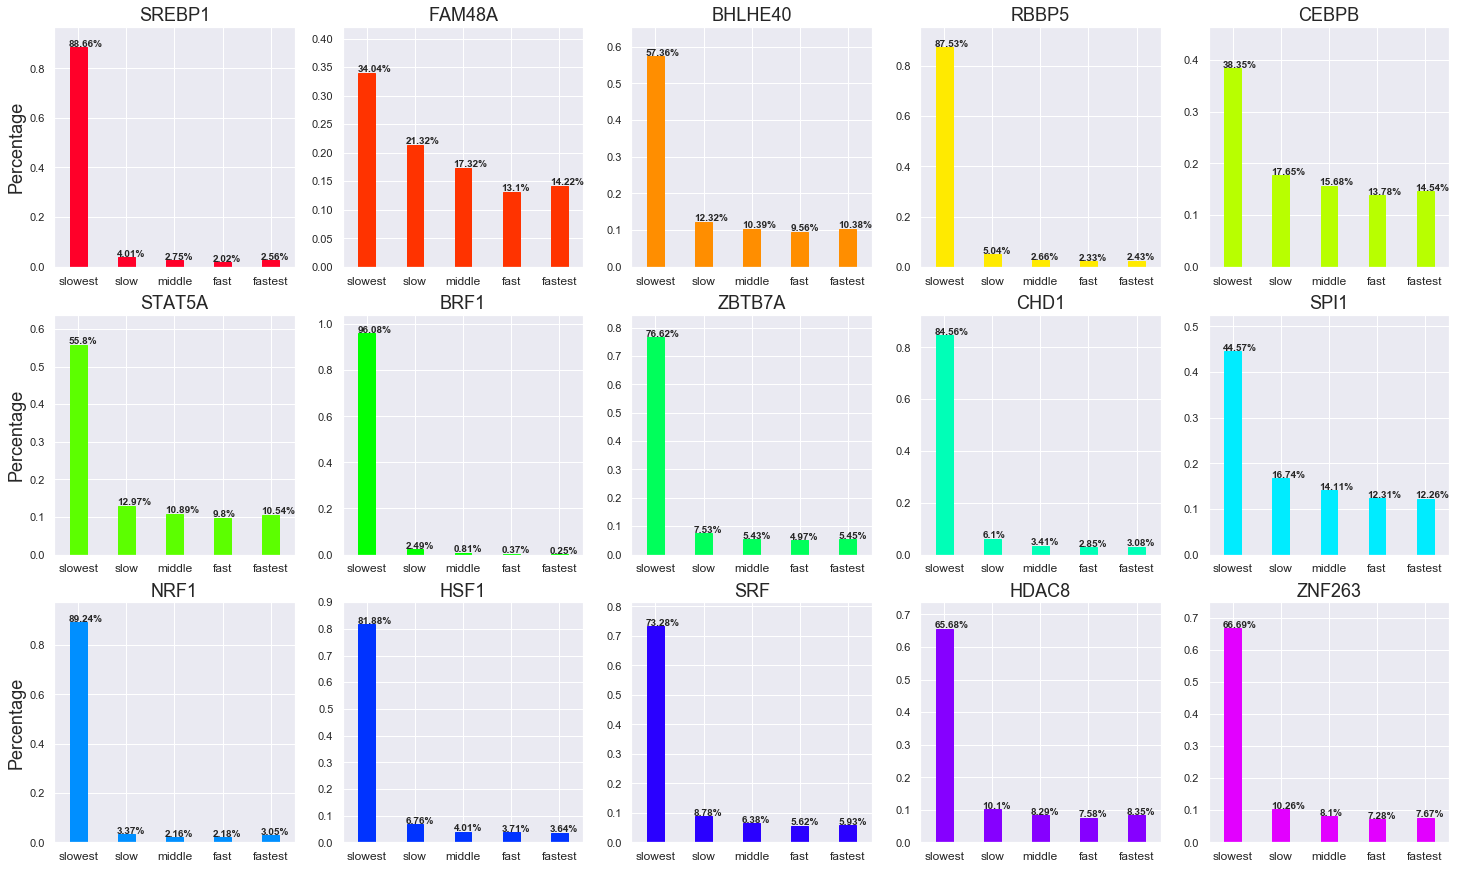

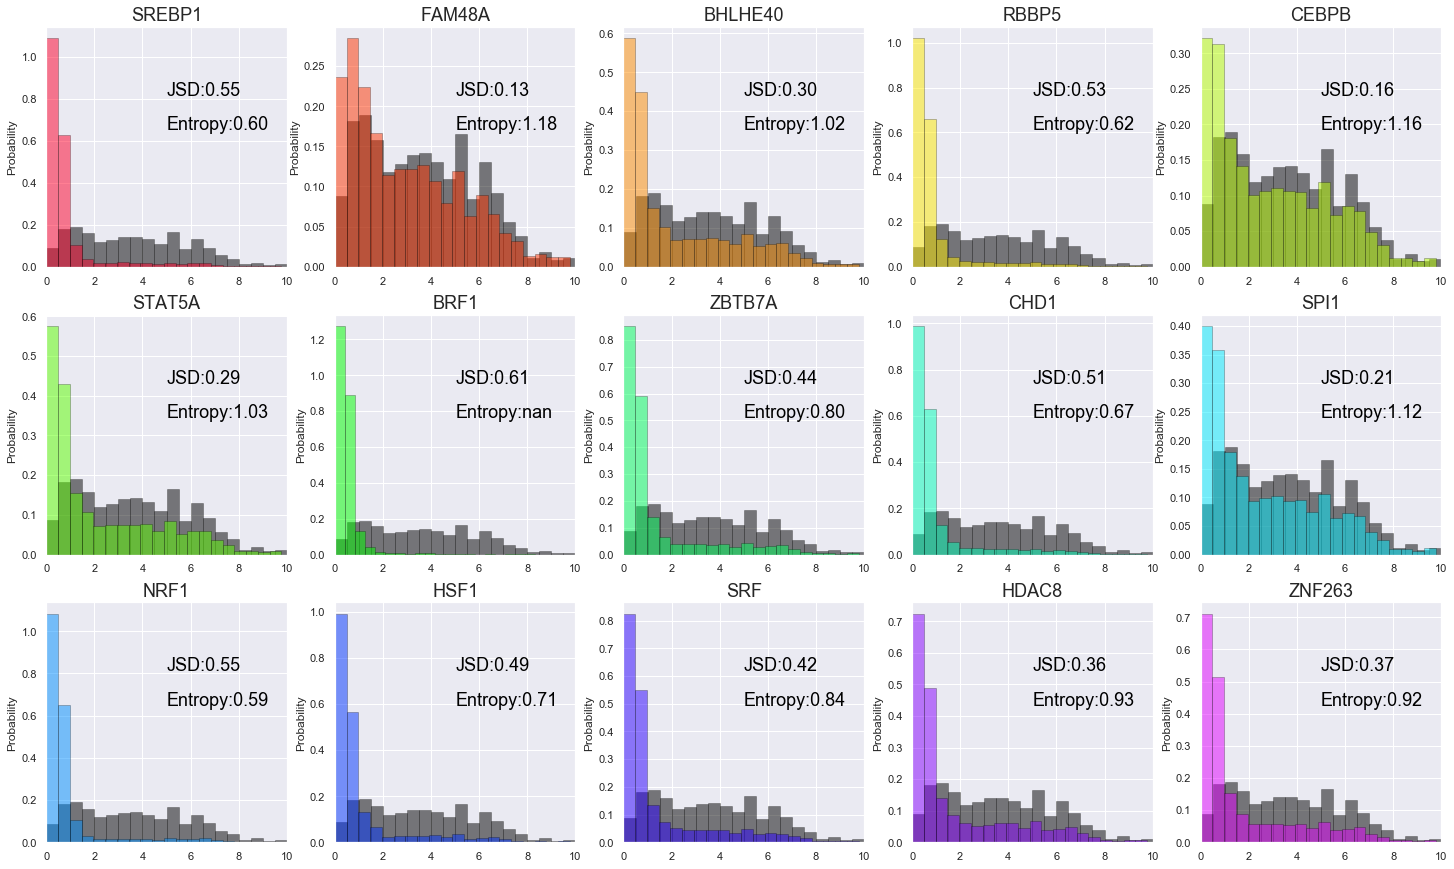

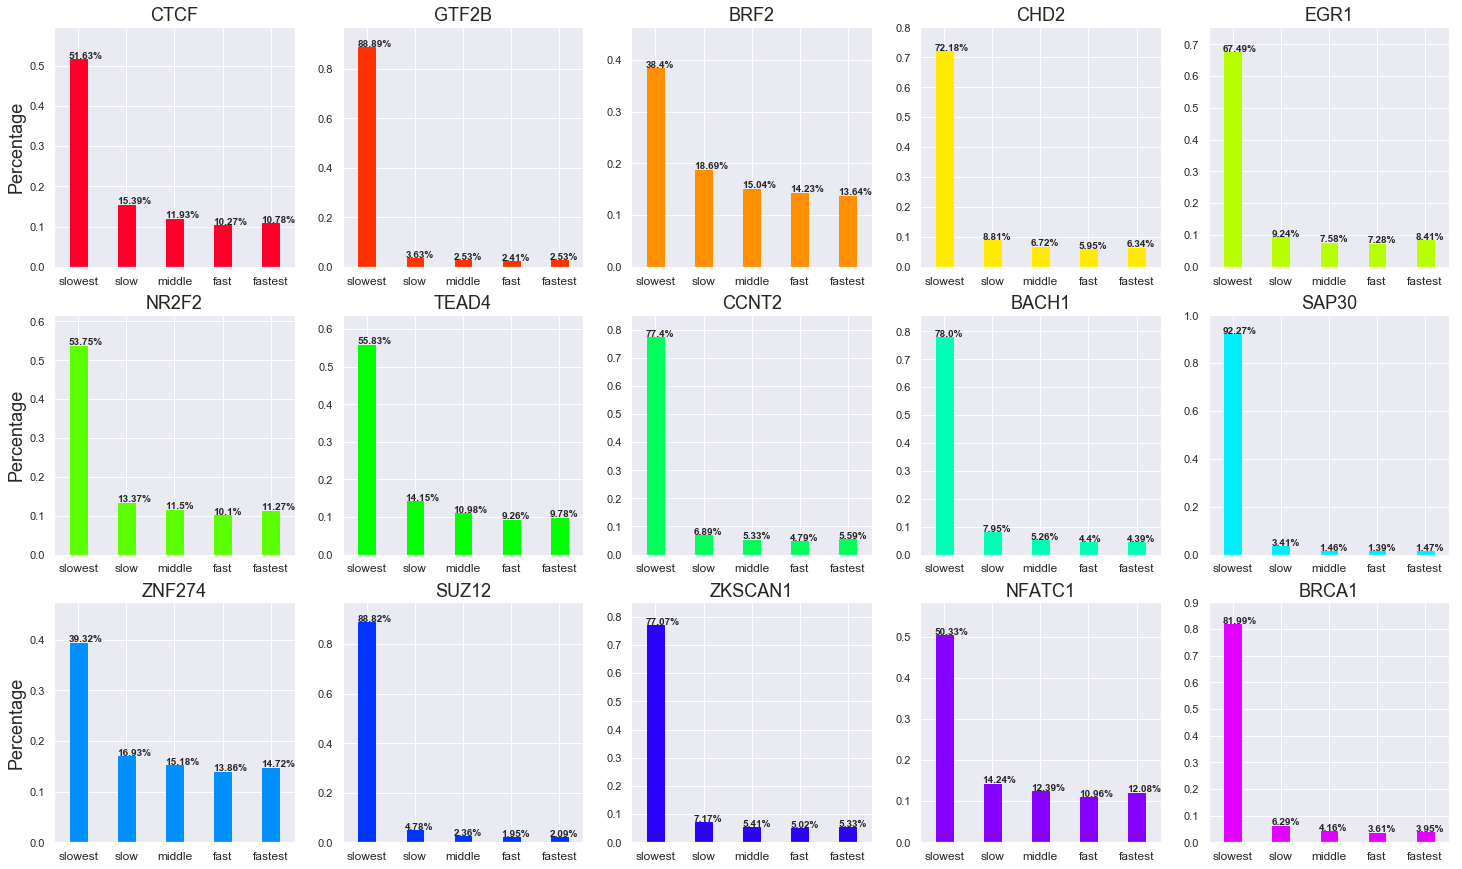

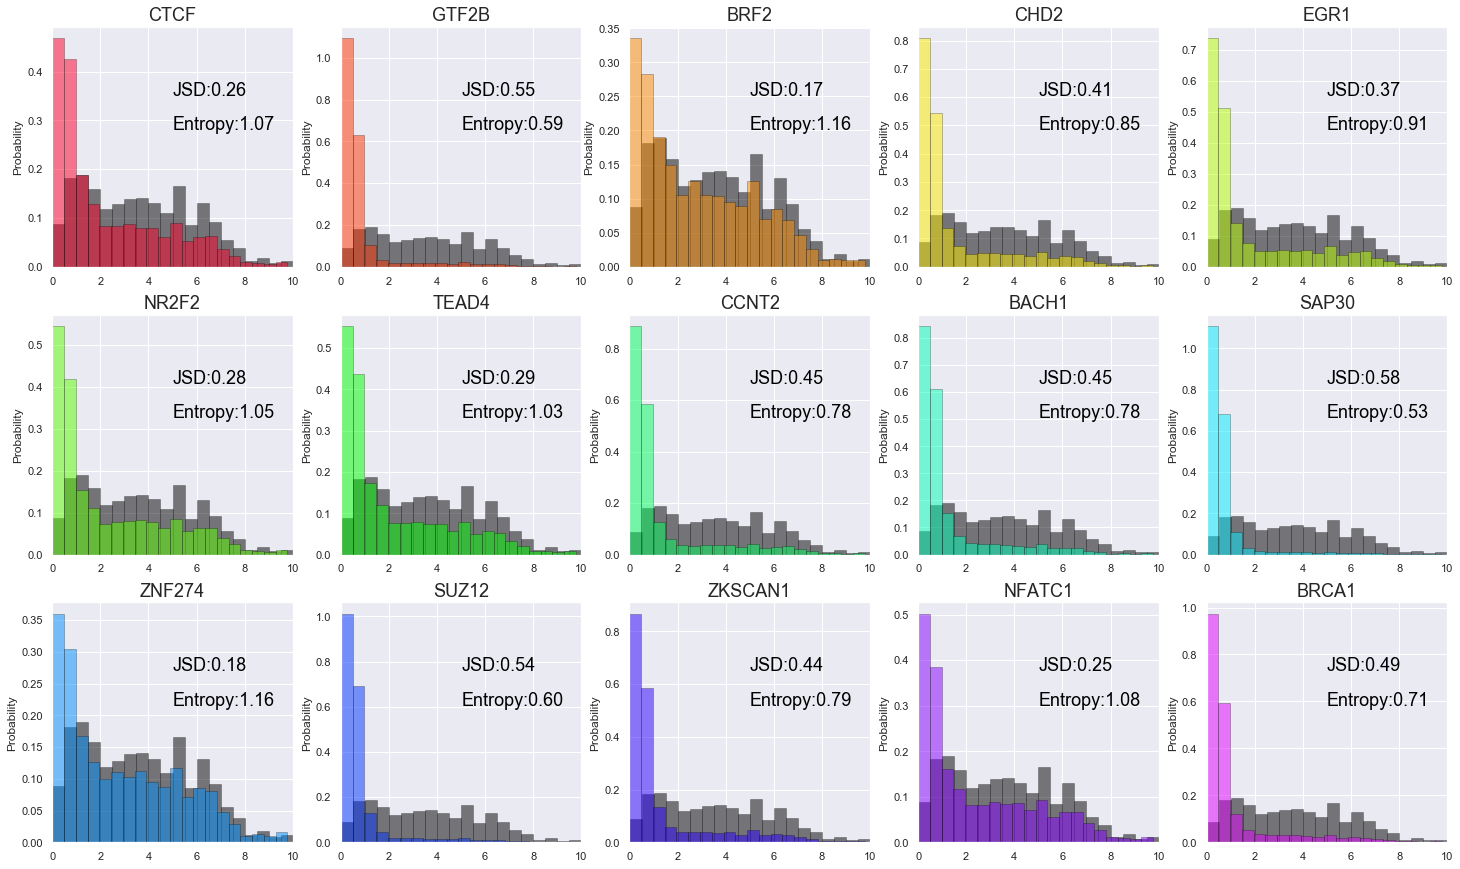

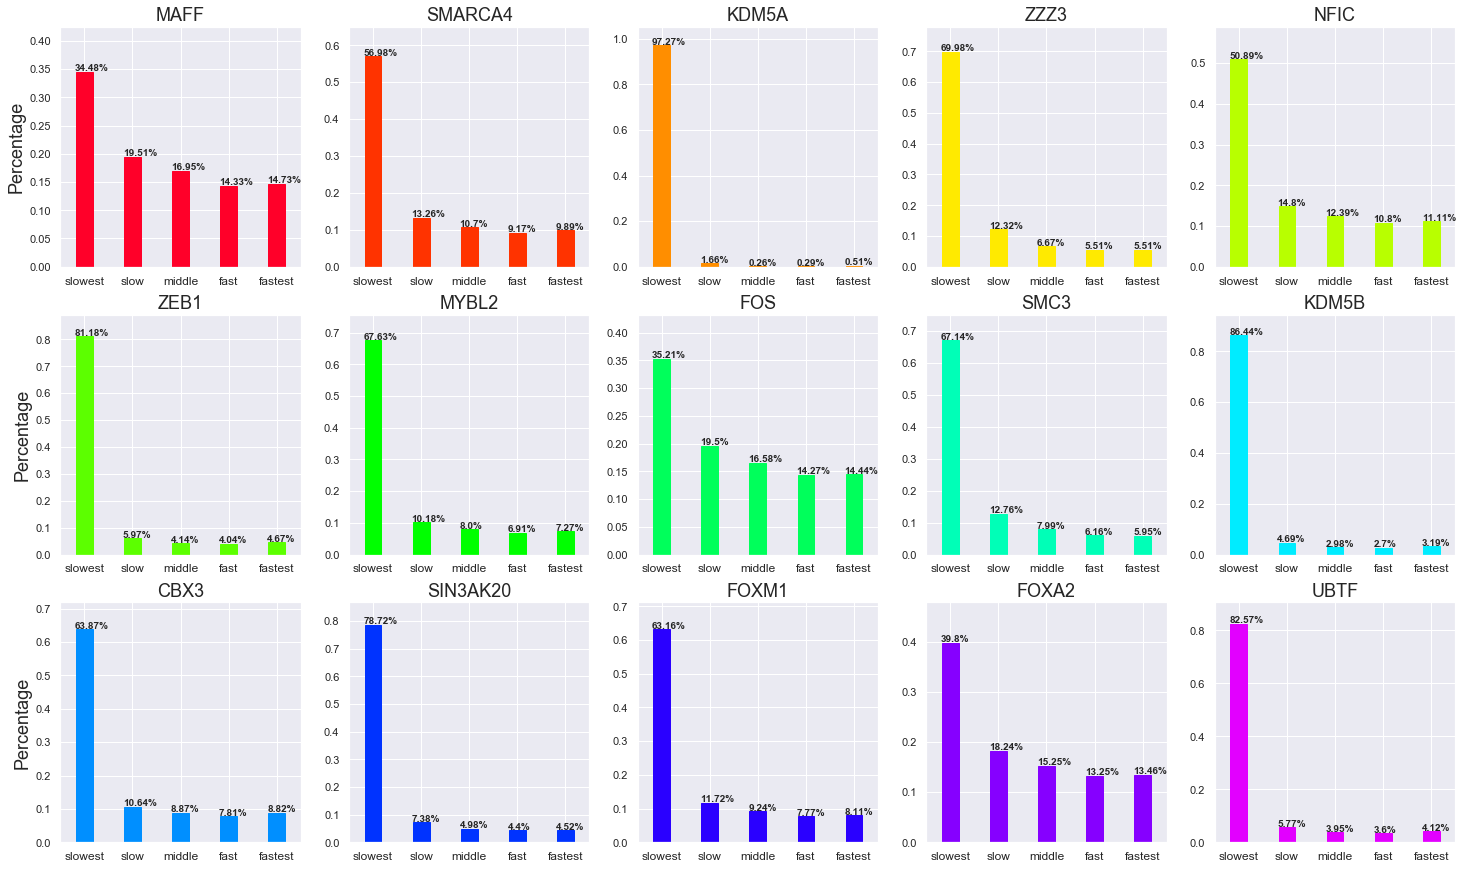

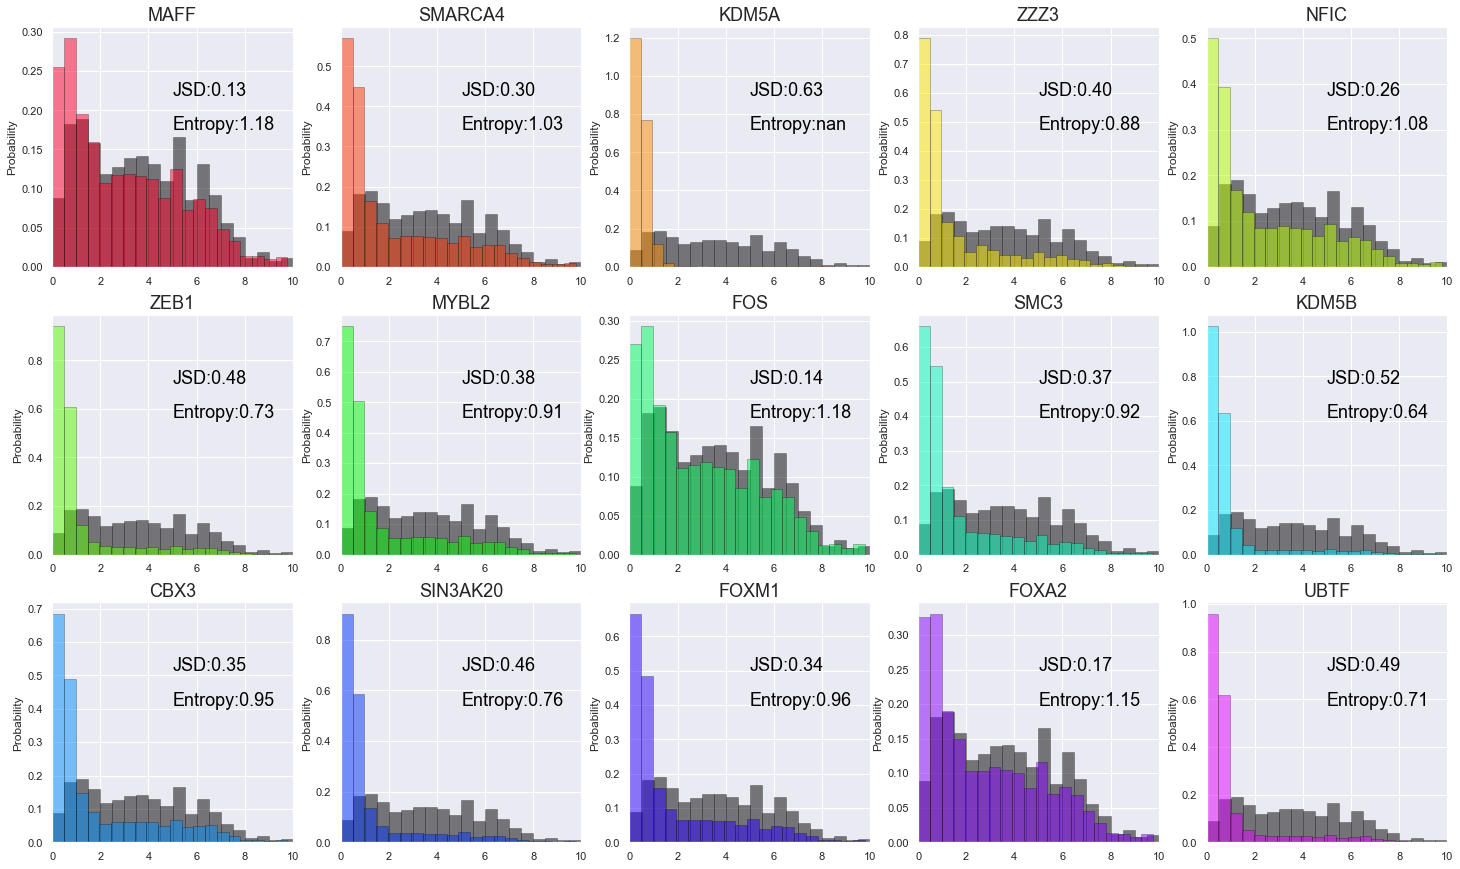

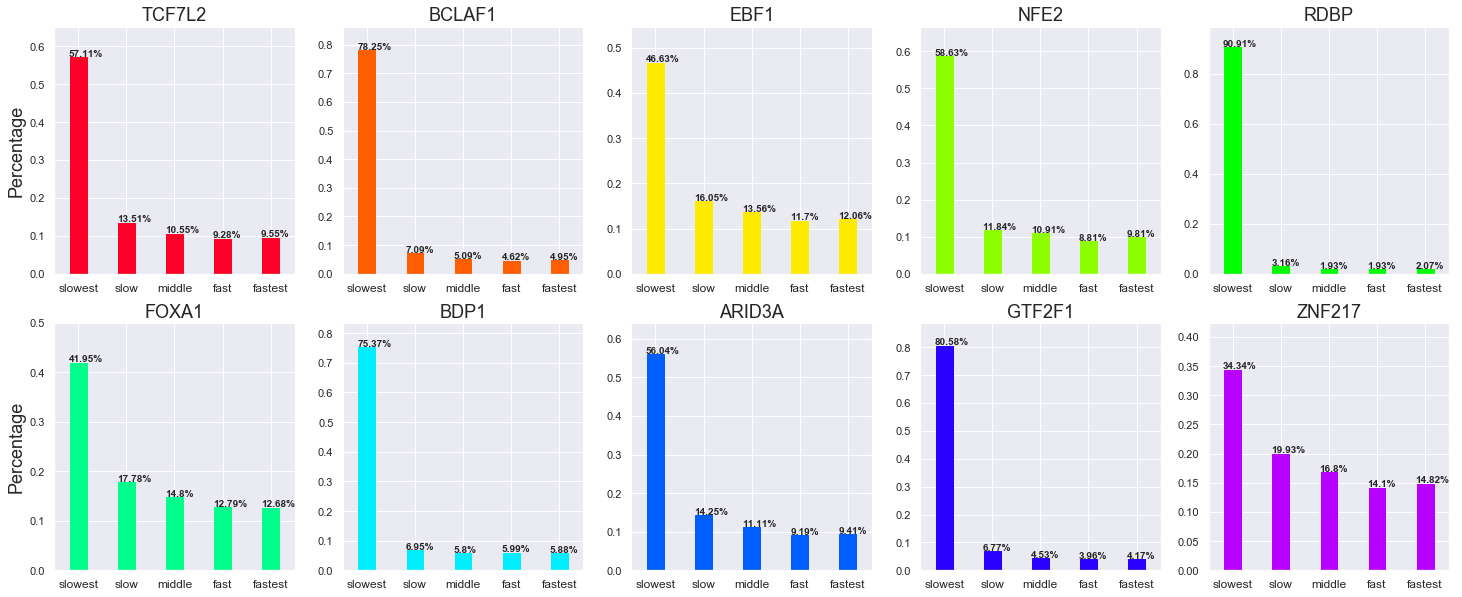

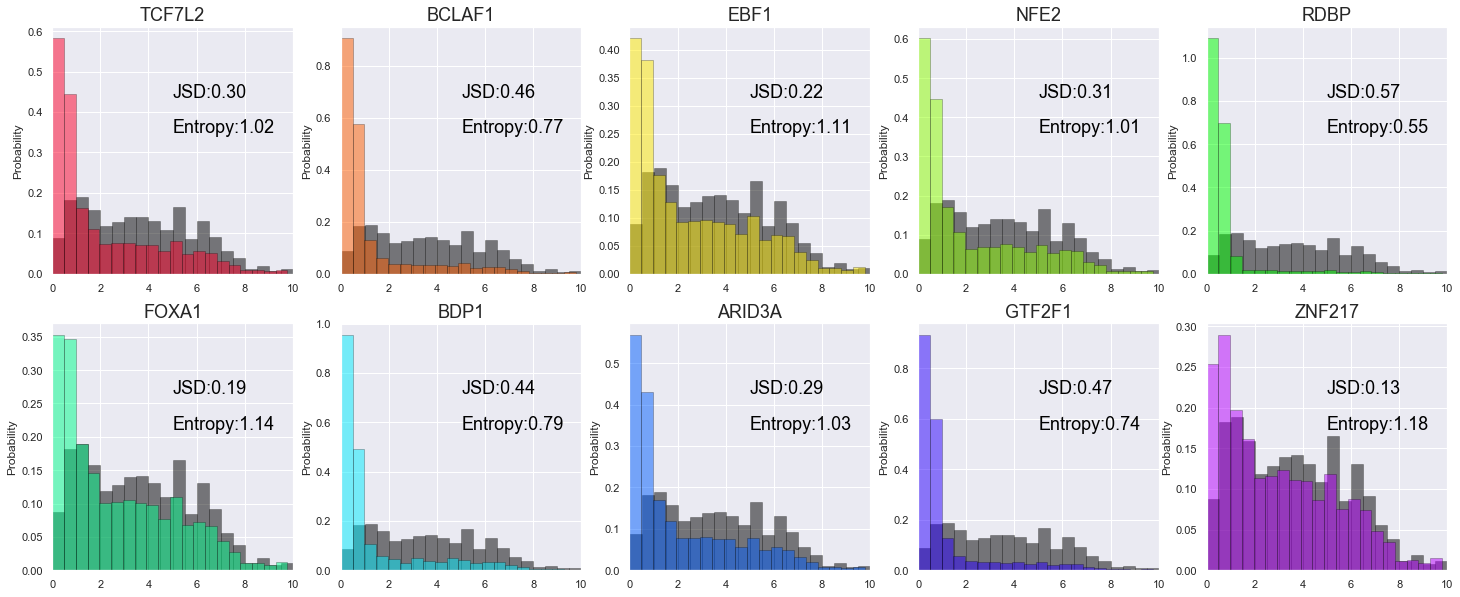

In [15]:
LOG_SCALE = False
JSD = True # Using JSD or Mutual information
HISTOGRAM = False # plot histogram or the distribution by pdf
MI_BIN = 10
All_data = []
for K_analyze in [False, True]:#, True
    data_arr = []
    NBIN=20 if LOG_SCALE else 20
    METRIC ="JSD" if JSD else "1-MI"
    if K_analyze:
        if LOG_SCALE:
            sub_fig_dir= "K_Log10"
        else:
            sub_fig_dir= "K"
    else:
        sub_fig_dir= "Methy"
    print(sub_fig_dir + "_" + METRIC)
    FIGURE_DIR = os.path.join("../FIGURES/FEATURE_ANALYSIS/", sub_fig_dir)
    if not os.path.exists(FIGURE_DIR):
        os.makedirs(FIGURE_DIR)
    intersected_dir_name = "K_intersected" if K_analyze else "Methy_intersected"
    CLASS_LABELS = ['slowest', 'slow', 'middle', 'fast', 'fastest'] if K_analyze else ['<25%', '25%-50%', '50%-65%', '>65%']
    N_CLASSES = len(CLASS_LABELS)
    percentile_names = [str(i*20) for i in range(1, N_CLASSES + 1)]
    out_data_fp = os.path.join(FIGURE_DIR, sub_fig_dir + "_" + METRIC+".txt")
    elem = plot_ChrMM()
    data_arr.append(elem)
    regions = ["General", "Genomic_Regions", "Histone_Modification", "Histone_Modification_Enzyme", "TFBS"] #
    for REGION in regions:
        elem = plot_K_hist_in_different_markers(os.path.join(GENOMIC_FEATURES_DIR, REGION, intersected_dir_name),REGION)
        data_arr.append(elem)
    All_data.append(data_arr)

In [303]:
LOG_SCALE = False
JSD = True # Using JSD or Mutual information
METRIC ="JSD" if JSD else "1-MI"
annotations = ["ChrmoHMM","General", "Genomic_Regions", "Histone_Modification", "Histone_Modification_Enzyme", "TFBS"] #
FIG_DIR = os.path.join("../FIGURES/FEATURE_ANALYSIS/", METRIC + "_COMPARISON")
if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)
for aid, anno in enumerate(annotations):
    out_fp = os.path.join(FIG_DIR, anno + ".tsv")
    ltws = [] # Lines to write
    line_dict = {}
    for kid, K_analyze in enumerate([False, True]):
        data_dict = All_data[kid][aid][0]
        for k, v in data_dict.items():
            if k not in line_dict.keys():
                line_dict[k] = []
            line_dict[k].append(v)
    
    for k, v in line_dict.items():
        diff = math.fabs(v[0] - v[1])
        line = "\t".join([k, str(round(v[0], 2)), str(round(v[1], 2)), str(round(diff, 2))])
        ltws.append(line)
    with open(out_fp, "w") as out_f:
        line = "\n".join(ltws)
        out_f.write(line)
        out_f.write("\n")
        print("write %s successful!" % out_fp)

write ../FIGURES/FEATURE_ANALYSIS/JSD_COMPARISON/ChrmoHMM.tsv successful!
write ../FIGURES/FEATURE_ANALYSIS/JSD_COMPARISON/General.tsv successful!
write ../FIGURES/FEATURE_ANALYSIS/JSD_COMPARISON/Genomic_Regions.tsv successful!
write ../FIGURES/FEATURE_ANALYSIS/JSD_COMPARISON/Histone_Modification.tsv successful!
write ../FIGURES/FEATURE_ANALYSIS/JSD_COMPARISON/Histone_Modification_Enzyme.tsv successful!
write ../FIGURES/FEATURE_ANALYSIS/JSD_COMPARISON/TFBS.tsv successful!
